# Preamble

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext rpy2.ipython

In [ ]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from lib.pandas import idxwhere
import numpy as np
from tqdm import tqdm
import lib.project_data
import lib.plot
import lib.engraftment
import lib.project_style
from lib.dissimilarity import (
    dmatrix,
    align_dmatrices,
    mask_dmatrix,
    triu_stack,
    diss_table,
    partial_mantel_test,
    mantel_test,
)
import scipy as sp
import scipy.stats
import statsmodels.formula.api as smf
from statsmodels import api as sm
from warnings import warn
from itertools import product

np.random.seed(1)


def _print_visual_separator(n=100):
    print("\n" + "-" * n + "\n")


sns.set_context("paper")
# mpl.rcParams["figure.dpi"] = 200  # For publication images
mpl.rcParams["figure.dpi"] = 100  # For notebook use images

# Load Data

In [ ]:
con = sqlite3.connect("sdata/database.db")

## Subject / Visit Data

In [ ]:
subject_x_visit_type = lib.project_data.load_subject_x_visit_type_table(con)
print(
    subject_x_visit_type.days_post_fmt.unstack().loc[
        :, lib.project_data.VISIT_TYPE_ORDER
    ]
)

visit_type  colonoscopy_1  maintenance_1  maintenance_2  maintenance_3  \
subject_id                                                               
S0001                 0.0            7.0           14.0           22.0   
S0004                 0.0            6.0           13.0           20.0   
S0007                 0.0            6.0           14.0           21.0   
S0008                 0.0            7.0           13.0           21.0   
S0013                 0.0            7.0           16.0           23.0   
S0017                 0.0            7.0           14.0           21.0   
S0021                 0.0            6.0           14.0           20.0   
S0024                 0.0            7.0           12.0           21.0   
S0027                 0.0            5.0           10.0           17.0   
S0029                 0.0            8.0           13.0           21.0   
S0031                 0.0            7.0           13.0           21.0   
S0037                 0.0            7

In [ ]:
subject = lib.project_data.load_subject_table(con)
recipient_x_sample_type = lib.project_data.load_recipient_x_sample_type_table(con)
recipient = subject.assign(
    remission_=lambda x: x.remission.where(~x.withdrawal_due_to_failure, np.nan),
    responder_=lambda x: x.responder.where(~x.withdrawal_due_to_failure, np.nan),
    mayo_endo_improved_=lambda x: x.mayo_endo_improved.where(
        ~x.withdrawal_due_to_failure, np.nan
    ),
)[lambda x: x.recipient]

recipient.sort_values(["arm"])[lib.project_data.RECIPIENT_SUMMARIZE_COLUMNS]

,arm,sex,donor_subject_id,withdrawal_due_to_failure,mayo_total_start,mayo_total_end,remission,responder
subject_id,,,,,,,,
S0047,ABX+/CAPS,male,D0044,False,4.0,1.0,True,True
S0068,ABX+/CAPS,female,D0485,<NA>,NaN,NaN,<NA>,<NA>
S0066,ABX+/CAPS,male,D0485,<NA>,NaN,NaN,<NA>,<NA>
S0063,ABX+/CAPS,female,D0065,False,5.0,2.0,True,True
S0053,ABX+/CAPS,male,D0044,False,6.0,1.0,True,True
S0027,ABX+/CAPS,female,D0097,False,5.0,0.0,True,True
S0037,ABX+/CAPS,male,D0485,True,8.0,NaN,False,False
S0064,ABX+/ENMA,male,D0485,False,6.0,2.0,True,True
S0060,ABX+/ENMA,male,D0044,False,6.0,8.0,False,False


In [ ]:
recipient.shape

(30, 21)

## Microbiome Data

In [ ]:
donor_means_list = ["D0044_mean", "D0097_mean", "D0485_mean"]

In [ ]:
sample_x_rotu_cvrg = lib.project_data.load_sample_x_rotu_cvrg_table(con)
sample_x_rotu = lib.project_data.load_sample_x_rotu_rabund_table(con)

low_mgen_coverage_samples = ["SS01011"]  # See data_checkup.ipynb

sample_x_motu = lib.project_data.load_sample_x_motu_rabund_table(con).drop(
    low_mgen_coverage_samples, errors="ignore"
)
sample_x_sotu = lib.project_data.load_sample_x_sotu_rabund_table(con).drop(
    low_mgen_coverage_samples, errors="ignore"
)

In [ ]:
sample_x_ko_cvrg = lib.project_data.load_sample_x_ko_table(con).drop(
    low_mgen_coverage_samples, errors="ignore"
)

In [ ]:
sample_x_chem_ba = lib.project_data.load_sample_x_chem_ba_table(con)
sample_x_chem_ba_std2 = sample_x_chem_ba.apply(lambda x: x / np.sqrt(np.mean(x ** 2)))

In [ ]:
sample = lib.project_data.load_sample_table(con)
recipient_has_mgen_data_list = sample.loc[
    list(set(recipient_x_sample_type["sample_id"]) & set(sample_x_ko_cvrg.index))
].subject_id.unique()

In [ ]:
sample_x_motu[100022].sort_values(ascending=False).head(20)

sample_id
DS0044_006    0.152174
DS0044_009    0.103879
SS01148       0.088235
SS01145       0.080646
SS01105       0.077779
D0044_mean    0.068596
SS01033       0.063600
SS01139       0.060779
SS01134       0.060040
DS0097_006    0.057485
SS01142       0.055676
DS0097_022    0.053872
SS01027       0.052720
DS0097_034    0.051043
SS01151       0.049468
DS0097_025    0.046021
DS0097_009    0.045934
DS0097_024    0.045610
SS01169       0.044627
DS0097_031    0.044512
Name: 100022, dtype: float64

In [ ]:
sample_x_sotu.loc[["SS01009", "SS01057"], "100022":"100023"].sum(1)

sample_id
SS01009    0.000196
SS01057    0.002239
dtype: float64

In [ ]:
donor_order = ["D0044", "D0097", "D0485"]

subject_has_mgen_list = []

for donor_subject_id in donor_order:
    subject_has_mgen_list.append(donor_subject_id)
    _donor_subject_list = idxwhere(
        (recipient.donor_subject_id == donor_subject_id)
        & recipient.index.to_series().isin(recipient_has_mgen_data_list)
    )
    subject_has_mgen_list.extend(_donor_subject_list)

subject_has_mgen_order = (
    subject.loc[subject_has_mgen_list]
    .sort_values(["donor_subject_id", "recipient", "subject_id"], ascending=True)
    .index.to_list()
)

recipient_has_mgen_order = [
    subject_id for subject_id in subject_has_mgen_order if subject_id not in donor_order
]


# recipient_has_mgen_order = idxwhere((
#     recipient_x_sample_type
#     .sample_id
#     .unstack('sample_type')
#     .reindex(columns=lib.project_data.SAMPLE_TYPE_ORDER)
# ).isin(sample_x_sotu.index).sum(1) > 2)


subject_has_mgen_order, recipient_has_mgen_order

(['D0044',
  'S0041',
  'S0047',
  'S0053',
  'S0055',
  'S0056',
  'D0097',
  'S0001',
  'S0004',
  'S0013',
  'S0021',
  'S0024',
  'S0027',
  'D0485',
  'S0007',
  'S0008'],
 ['S0041',
  'S0047',
  'S0053',
  'S0055',
  'S0056',
  'S0001',
  'S0004',
  'S0013',
  'S0021',
  'S0024',
  'S0027',
  'S0007',
  'S0008'])

In [ ]:
subject_color_palette = lib.plot.construct_ordered_pallete(
    subject_has_mgen_order,
    cm="rainbow",
)

lib.plot.demo_pallete(subject_color_palette)

   D0044     S0041     S0047     S0053     S0055     S0056     D0097  \
0    0.5  0.374510  0.249020  0.123529  0.001961  0.127451  0.252941   
1    0.0  0.195845  0.384106  0.557489  0.709281  0.833602  0.925638   
2    1.0  0.995147  0.980635  0.956604  0.923289  0.881012  0.830184   
3    1.0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

      S0001     S0004     S0013     S0021     S0024     S0027     D0485  \
0  0.378431  0.503922  0.629412  0.754902  0.880392  1.000000  1.000000   
1  0.981823  0.999981  0.979410  0.920906  0.826734  0.700543  0.547220   
2  0.771298  0.704926  0.631711  0.552365  0.467658  0.378411  0.285492   
3  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

      S0007     S0008  
0  1.000000  1.000000  
1  0.372702  0.183750  
2  0.189801  0.092268  
3  1.000000  1.000000  


### Taxonomy

In [ ]:
motu_to_taxonomy = lib.project_data.load_motu_to_taxonomy_table(con)

In [ ]:
sotu_to_motu = sample_x_sotu.columns.to_series(name="motu_id").str[:6].astype(int)
sotu_to_taxonomy = (
    sotu_to_motu.astype(str)
    .to_frame()
    .join(motu_to_taxonomy.set_index(motu_to_taxonomy.index.astype(str)), on="motu_id")
    .assign(motu_id=lambda x: x.motu_id.astype(int))
)
sotu_to_taxonomy.head(2)

,motu_id,d__,p__,c__,o__,f__,g__,s__
sotu_id,,,,,,,,
100002-other,100002,d__Bacteria;,d__Bacteria;p__Firmicutes_A;,d__Bacteria;p__Firmicutes_A;c__Clostridia;,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...
100002-s001,100002,d__Bacteria;,d__Bacteria;p__Firmicutes_A;,d__Bacteria;p__Firmicutes_A;c__Clostridia;,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...


#### Slice/Merge Taxa

In [ ]:
sample_x_sotu_bacteroidota = sample_x_sotu.loc[
    :,
    sample_x_sotu.columns.isin(
        idxwhere(sotu_to_taxonomy.p__.isin(["d__Bacteria;p__Bacteroidota;"]))
    ),
].apply(lib.stats.normalize, axis=1)
sample_x_sotu_firmicutes_A = sample_x_sotu.loc[
    :,
    sample_x_sotu.columns.isin(
        idxwhere(sotu_to_taxonomy.p__.isin(["d__Bacteria;p__Firmicutes_A;"]))
    ),
].apply(lib.stats.normalize, axis=1)
sample_x_sotu_firmicutes_C = sample_x_sotu.loc[
    :,
    sample_x_sotu.columns.isin(
        idxwhere(sotu_to_taxonomy.p__.isin(["d__Bacteria;p__Firmicutes_C;"]))
    ),
].apply(lib.stats.normalize, axis=1)
sample_x_sotu_firmicutes = sample_x_sotu.loc[
    :,
    sample_x_sotu.columns.isin(
        idxwhere(sotu_to_taxonomy.p__.isin(["d__Bacteria;p__Firmicutes;"]))
    ),
].apply(lib.stats.normalize, axis=1)
sample_x_sotu_actinobacteria = sample_x_sotu.loc[
    :,
    sample_x_sotu.columns.isin(
        idxwhere(sotu_to_taxonomy.p__.isin(["d__Bacteria;p__Actinobacteriota;"]))
    ),
].apply(lib.stats.normalize, axis=1)
sample_x_sotu_proteobacteria = sample_x_sotu.loc[
    :,
    sample_x_sotu.columns.isin(
        idxwhere(sotu_to_taxonomy.p__.isin(["d__Bacteria;p__Proteobacteria;"]))
    ),
].apply(lib.stats.normalize, axis=1)

In [ ]:
sample_x_family = sample_x_sotu.groupby(sotu_to_taxonomy.f__, axis="columns").sum()
sample_x_family_bacteroidota = sample_x_sotu_bacteroidota.groupby(
    sotu_to_taxonomy.f__, axis="columns"
).sum()
sample_x_family_firmicutes = sample_x_sotu_firmicutes.groupby(
    sotu_to_taxonomy.f__, axis="columns"
).sum()
sample_x_family_firmicutes_A = sample_x_sotu_firmicutes_A.groupby(
    sotu_to_taxonomy.f__, axis="columns"
).sum()
sample_x_family_firmicutes_C = sample_x_sotu_firmicutes_C.groupby(
    sotu_to_taxonomy.f__, axis="columns"
).sum()
sample_x_family_actinobacteria = sample_x_sotu_actinobacteria.groupby(
    sotu_to_taxonomy.f__, axis="columns"
).sum()
sample_x_family_proteobacteria = sample_x_sotu_proteobacteria.groupby(
    sotu_to_taxonomy.f__, axis="columns"
).sum()

In [ ]:
sample_x_motu = sample_x_sotu.groupby(sotu_to_taxonomy.motu_id, axis="columns").sum()
sample_x_motu_bacteroidota = sample_x_sotu_bacteroidota.groupby(
    sotu_to_taxonomy.motu_id, axis="columns"
).sum()
sample_x_motu_firmicutes = sample_x_sotu_firmicutes.groupby(
    sotu_to_taxonomy.motu_id, axis="columns"
).sum()
sample_x_motu_firmicutes_A = sample_x_sotu_firmicutes_A.groupby(
    sotu_to_taxonomy.motu_id, axis="columns"
).sum()
sample_x_motu_firmicutes_C = sample_x_sotu_firmicutes_C.groupby(
    sotu_to_taxonomy.motu_id, axis="columns"
).sum()
sample_x_motu_actinobacteria = sample_x_sotu_actinobacteria.groupby(
    sotu_to_taxonomy.motu_id, axis="columns"
).sum()
sample_x_motu_proteobacteria = sample_x_sotu_proteobacteria.groupby(
    sotu_to_taxonomy.motu_id, axis="columns"
).sum()

In [ ]:
sample_x_family = sample_x_motu.groupby(motu_to_taxonomy.f__, axis="columns").sum()
sample_x_phylum = sample_x_motu.groupby(motu_to_taxonomy.p__, axis="columns").sum()

## Sample Metadata

In [ ]:
sample = (
    lib.project_data.load_sample_table(con)
    .assign(
        has_mgen=lambda x: x.index.isin(idxwhere(sample_x_ko_cvrg.sum(1) > 1e6)),
        has_chem=lambda x: x.index.isin(sample_x_chem_ba.index),
        has_rrs=lambda x: x.index.isin(sample_x_rotu.index),
    )
    .sort_values(["subject_id", "days_post_fmt"])
)

In [ ]:
recipient_x_sample_type = lib.project_data.load_recipient_x_sample_type_table(con)

print(recipient_x_sample_type["sample_id"].unstack())

sample_type baseline followup_1 followup_2 followup_3 post_antibiotic  \
subject_id                                                              
S0001        SS01002    SS01026    SS01048    SS01070             NaN   
S0004        SS01000    SS01018    SS01042    SS01067         SS01001   
S0007        SS01020    SS01046    SS01062    SS01093             NaN   
S0008        SS01038    SS01063    SS01087    SS01119             NaN   
S0013        SS01013    SS01037    SS01053    SS01089             NaN   
S0017        SS01021        NaN    SS00999        NaN             NaN   
S0021        SS01068    SS01086    SS01105        NaN         SS01069   
S0024        SS01057    SS01088    SS01098    SS01124         SS01056   
S0027        SS01090    SS01108    SS01125    SS01132         SS01091   
S0029        SS01058        NaN    SS01106        NaN             NaN   
S0031        SS01041    SS01061        NaN        NaN             NaN   
S0037        SS01095        NaN        NaN        N

# Results

## Subsection: Study design and subject demographics

In [ ]:
# TODO: Build demographics table?

In [ ]:
recipient_has_efficacy_list = idxwhere(recipient.remission.notna())

(
    subject_x_visit_type.loc[recipient_has_efficacy_list]
    .groupby(level="visit_type")
    .days_post_fmt.quantile([0.0, 0.25, 0.5, 0.75, 1.0])
    .unstack()
)

,0.00,0.25,0.50,0.75,1.00
visit_type,,,,,
colonoscopy_1,-1.0,0.00,0.0,0.00,0.0
colonoscopy_2,42.0,50.50,56.0,56.00,84.0
followup_1_month,71.0,89.25,93.5,102.75,118.0
followup_3_month,115.0,153.00,153.5,178.00,216.0
maintenance_1,4.0,5.00,6.0,7.00,7.0
maintenance_2,10.0,12.00,13.5,14.00,16.0
maintenance_3,17.0,20.00,21.0,21.00,23.0
maintenance_4,22.0,27.00,28.0,28.00,35.0
maintenance_5,29.0,33.00,35.0,35.00,61.0


In [ ]:
(
    sample[lambda x: x.subject_id.isin(recipient_has_efficacy_list)]
    .groupby("sample_type")
    .days_post_fmt.quantile([0.0, 0.25, 0.5, 0.75, 1.0])
    .unstack()
)

,0.00,0.25,0.50,0.75,1.00
sample_type,,,,,
baseline,-15.0,-7.25,-5.0,-1.75,0.0
followup_1,46.0,48.00,53.0,55.00,82.0
followup_2,71.0,90.50,95.0,102.00,118.0
followup_3,152.0,153.00,153.0,160.00,196.0
post_antibiotic,-2.0,-2.00,-2.0,-1.00,-1.0
pre_maintenance_1,4.0,5.00,5.5,6.25,7.0
pre_maintenance_2,10.0,11.00,12.5,14.00,16.0
pre_maintenance_3,16.0,19.00,19.5,20.00,23.0
pre_maintenance_4,22.0,26.00,27.0,28.00,34.0


In [ ]:
(
    sample[lambda x: x.subject_id.isin(recipient_has_efficacy_list)]
    .groupby("sample_type")
    .days_post_fmt.quantile([0.0, 0.25, 0.5, 0.75, 1.0])
    .unstack()
)

,0.00,0.25,0.50,0.75,1.00
sample_type,,,,,
baseline,-15.0,-7.25,-5.0,-1.75,0.0
followup_1,46.0,48.00,53.0,55.00,82.0
followup_2,71.0,90.50,95.0,102.00,118.0
followup_3,152.0,153.00,153.0,160.00,196.0
post_antibiotic,-2.0,-2.00,-2.0,-1.00,-1.0
pre_maintenance_1,4.0,5.00,5.5,6.25,7.0
pre_maintenance_2,10.0,11.00,12.5,14.00,16.0
pre_maintenance_3,16.0,19.00,19.5,20.00,23.0
pre_maintenance_4,22.0,26.00,27.0,28.00,34.0


In [ ]:
d0 = subject_x_visit_type.days_post_fmt.unstack()[lib.project_data.VISIT_TYPE_ORDER]
d1 = pd.DataFrame(
    d0[lib.project_data.VISIT_TYPE_ORDER[1:]].values
    - d0[lib.project_data.VISIT_TYPE_ORDER[:-1]].values,
    index=d0.index,
    columns=lib.project_data.VISIT_TYPE_ORDER[1:],
)
print(d1)

            maintenance_1  maintenance_2  maintenance_3  maintenance_4  \
subject_id                                                               
S0001                 7.0            7.0            8.0            6.0   
S0004                 6.0            7.0            7.0            7.0   
S0007                 6.0            8.0            7.0            7.0   
S0008                 7.0            6.0            8.0            7.0   
S0013                 7.0            9.0            7.0            6.0   
S0017                 7.0            7.0            7.0            7.0   
S0021                 6.0            8.0            6.0            7.0   
S0024                 7.0            5.0            9.0            7.0   
S0027                 5.0            5.0            7.0            7.0   
S0029                 8.0            5.0            8.0            7.0   
S0031                 7.0            6.0            8.0            NaN   
S0037                 7.0            7

## Subsection: FMT efficacy and impacts of treatment

In [ ]:
recipient[~recipient["withdrawal_due_to_failure"].isna()][
    lib.project_data.RECIPIENT_SUMMARIZE_COLUMNS
]

,arm,sex,donor_subject_id,withdrawal_due_to_failure,mayo_total_start,mayo_total_end,remission,responder
subject_id,,,,,,,,
S0001,ABX-/ENMA,female,D0097,False,8.0,4.0,False,True
S0004,ABX+/ENMA,male,D0097,False,4.0,0.0,True,True
S0007,ABX-/CAPS,male,D0485,False,6.0,7.0,False,False
S0008,ABX-/CAPS,male,D0485,False,5.0,1.0,True,True
S0013,ABX-/ENMA,male,D0097,False,4.0,3.0,False,False
S0017,ABX-/ENMA,female,D0097,True,5.0,9.0,False,False
S0021,ABX+/ENMA,female,D0097,False,4.0,8.0,False,False
S0024,ABX+/ENMA,male,D0097,False,6.0,4.0,False,False
S0027,ABX+/CAPS,female,D0097,False,5.0,0.0,True,True


In [ ]:
(
    recipient
    [
        lambda x: True
        & (~x.withdrawal_due_to_failure.isna())
        # & x.index.isin(sample[sample.has_chem].subject_id.unique())
    ]
    [lib.project_data.RECIPIENT_SUMMARIZE_COLUMNS]
    .groupby(['donor_subject_id', 'sex'])
    .apply(len)
    .unstack('sex', fill_value=0)
)

# D0485 got only male participants. So there's certainly some confounding of donor by sex.
# This is relevant particularly in the bile-acid analysis, because there are known sex differences in BA
# profiles.

sex,female,male
donor_subject_id,,
D0044,3,5
D0065,1,0
D0097,5,3
D0485,0,5


In [ ]:
(
    recipient
    [
        lambda x: True
        & (~x.withdrawal_due_to_failure.isna())
        & x.index.isin(sample[sample.has_chem].subject_id.unique())
    ]
    [lib.project_data.RECIPIENT_SUMMARIZE_COLUMNS]
    .groupby(['donor_subject_id', 'sex'])
    .apply(len)
    .unstack('sex', fill_value=0)
)



sex,female,male
donor_subject_id,,
D0044,3,2
D0097,3,3
D0485,0,2


In [ ]:
recipient[recipient["withdrawal_due_to_failure"]][
    lib.project_data.RECIPIENT_SUMMARIZE_COLUMNS
]

,arm,sex,donor_subject_id,withdrawal_due_to_failure,mayo_total_start,mayo_total_end,remission,responder
subject_id,,,,,,,,
S0017,ABX-/ENMA,female,D0097,True,5.0,9.0,False,False
S0037,ABX+/CAPS,male,D0485,True,8.0,NaN,False,False
S0043,ABX+/ENMA,female,D0097,True,10.0,NaN,False,False


### Remission and responder status

In [ ]:
# 'remission_' and 'responder_' are both strict definitions,
# excluding participants that did not complete the trial.
for endpoint in [
    "remission",
    "remission_",
    "responder",
    "responder_",
    "mayo_endo_improved",
]:

    print(recipient.groupby([endpoint]).apply(len).fillna(0).astype(int))
    _print_visual_separator()

remission
False    14
True      8
dtype: int64

----------------------------------------------------------------------------------------------------

remission_
False    11
True      8
dtype: int64

----------------------------------------------------------------------------------------------------

responder
False    12
True     10
dtype: int64

----------------------------------------------------------------------------------------------------

responder_
False     9
True     10
dtype: int64

----------------------------------------------------------------------------------------------------

mayo_endo_improved
False    11
True     11
dtype: int64

----------------------------------------------------------------------------------------------------



#### Antibiotics

In [ ]:
# 'remission_' and 'responder_' are both strict definitions,
# excluding participants that did not complete the trial.
for endpoint in [
    "remission",
    "remission_",
    "responder",
    "responder_",
    "mayo_endo_improved",
]:
    contingency = (
        recipient.groupby(["antibiotics_", endpoint])
        .apply(len)
        .unstack()
        .fillna(0)
        .astype(int)
    )

    print(contingency)
    print(sp.stats.fisher_exact(contingency))
    _print_visual_separator()

remission     False  True
antibiotics_             
ABX+              5     6
ABX-              9     2
(0.18518518518518517, 0.1826625386996899)

----------------------------------------------------------------------------------------------------

remission_    False  True
antibiotics_             
ABX+              3     6
ABX-              8     2
(0.125, 0.0697785186949274)

----------------------------------------------------------------------------------------------------

responder     False  True
antibiotics_             
ABX+              5     6
ABX-              7     4
(0.47619047619047616, 0.6699214098594914)

----------------------------------------------------------------------------------------------------

responder_    False  True
antibiotics_             
ABX+              3     6
ABX-              6     4
(0.3333333333333333, 0.36984996427720923)

----------------------------------------------------------------------------------------------------

mayo_endo_improved

In [ ]:
d = recipient.assign(
    **{
        endpoint: recipient[endpoint].astype(
            float
        )  # Use float instead of pd.Boolean dtype.
        for endpoint in [
            "remission",
            "remission_",
            "responder",
            "responder_",
            "mayo_endo_improved",
            "mayo_endo_improved_",
        ]
    }
)

for formula in [
    "remission ~ antibiotics_",
    "remission_ ~ antibiotics_",
    "responder ~ antibiotics_",
    "responder_ ~ antibiotics_",
    "mayo_endo_improved ~ antibiotics_",
    "mayo_endo_improved_ ~ antibiotics_",
]:
    fit = smf.logit(formula, data=d).fit()
    print(fit.summary())
    print(fit.conf_int())
    _print_visual_separator()

Optimization terminated successfully.
         Current function value: 0.581574
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              remission   No. Observations:                   22
Model:                          Logit   Df Residuals:                       20
Method:                           MLE   Df Model:                            1
Date:                Fri, 14 Jan 2022   Pseudo R-squ.:                  0.1128
Time:                        13:15:46   Log-Likelihood:                -12.795
converged:                       True   LL-Null:                       -14.421
Covariance Type:            nonrobust   LLR p-value:                   0.07134
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1823      0.606      0.301      0.763      -1.004       1.369

#### Enema vs. Capsules

In [ ]:
# 'remission_' and 'responder_' are both strict definitions,
# excluding participants that did not complete the trial.
for endpoint in [
    "remission",
    "remission_",
    "responder",
    "responder_",
    "mayo_endo_improved",
]:
    contingency = (
        recipient.groupby(["maintenance_", endpoint])
        .apply(len)
        .unstack()
        .fillna(0)
        .astype(int)
    )

    print(contingency)
    print(sp.stats.fisher_exact(contingency.values))
    _print_visual_separator()

remission     False  True
maintenance_             
CAPS              5     5
ENMA              9     3
(0.3333333333333333, 0.37770897832817296)

----------------------------------------------------------------------------------------------------

remission_    False  True
maintenance_             
CAPS              4     5
ENMA              7     3
(0.34285714285714286, 0.36984996427720895)

----------------------------------------------------------------------------------------------------

responder     False  True
maintenance_             
CAPS              4     6
ENMA              8     4
(0.3333333333333333, 0.39128363896165874)

----------------------------------------------------------------------------------------------------

responder_    False  True
maintenance_             
CAPS              3     6
ENMA              6     4
(0.3333333333333333, 0.36984996427720923)

----------------------------------------------------------------------------------------------------

may

In [ ]:
d = recipient.assign(
    **{
        endpoint: recipient[endpoint].astype(
            float
        )  # Use float instead of pd.Boolean dtype.
        for endpoint in [
            "remission",
            "remission_",
            "responder",
            "responder_",
            "mayo_endo_improved",
            "mayo_endo_improved_",
        ]
    }
)

for formula in [
    "remission ~ maintenance_",
    "remission_ ~ maintenance_",
    "responder ~ maintenance_",
    "responder_ ~ maintenance_",
    "mayo_endo_improved ~ maintenance_",
    "mayo_endo_improved_ ~ maintenance_",
]:
    fit = smf.logit(formula, data=d).fit()
    print(fit.summary())
    print(fit.conf_int())
    _print_visual_separator()

Optimization terminated successfully.
         Current function value: 0.621795
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              remission   No. Observations:                   22
Model:                          Logit   Df Residuals:                       20
Method:                           MLE   Df Model:                            1
Date:                Fri, 14 Jan 2022   Pseudo R-squ.:                 0.05139
Time:                        13:15:46   Log-Likelihood:                -13.679
converged:                       True   LL-Null:                       -14.421
Covariance Type:            nonrobust   LLR p-value:                    0.2234
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -2.668e-16      0.632  -4.22e-16      1.000      -1.240       1.240

#### Donor

In [ ]:
d = recipient[
    lambda x: x.donor_subject_id != "D0065"
].assign(  # Drop the single subject who received donor 65.
    **{
        endpoint: recipient[endpoint].astype(
            float
        )  # Use float instead of pd.Boolean dtype.
        for endpoint in [
            "remission",
            "remission_",
            "responder",
            "responder_",
            "mayo_endo_improved",
            "mayo_endo_improved_",
        ]
    }
)

for formula in [
    "remission ~ donor_subject_id",
    "remission_ ~ donor_subject_id",
    "responder ~ donor_subject_id",
    "responder_ ~ donor_subject_id",
    "mayo_endo_improved ~ donor_subject_id",
    "mayo_endo_improved_ ~ donor_subject_id",
]:
    print(smf.logit(formula, data=d).fit().summary())
    _print_visual_separator()

Optimization terminated successfully.
         Current function value: 0.588687
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              remission   No. Observations:                   21
Model:                          Logit   Df Residuals:                       18
Method:                           MLE   Df Model:                            2
Date:                Fri, 14 Jan 2022   Pseudo R-squ.:                 0.07514
Time:                        13:15:47   Log-Likelihood:                -12.362
converged:                       True   LL-Null:                       -13.367
Covariance Type:            nonrobust   LLR p-value:                    0.3663
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.0986      0.816     -1.346      0.178      -2.

### Mayo Score Improvement

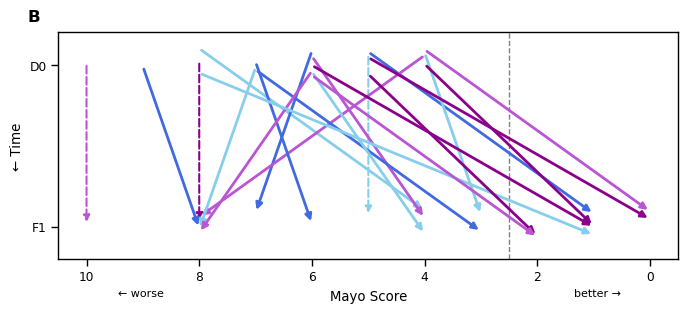

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))

d0 = recipient.assign(
    withdrawal_due_to_failure=lambda x: x.withdrawal_due_to_failure.astype(float)
).assign(jitter=lambda x: np.linspace(-0.1, 0.1, num=len(x)))
# d0 = recipient.dropna(subset=['mayo_total_start', 'mayo_total_end'])
# x_shift_range = np.linspace(-0.001, 0.001, num=d0.shape[0])
# d0 = d0.sort_values(['mayo_total_start', 'mayo_total_end'], ascending=False).assign(offset=x_shift_range)

plot_kwsA = dict(alpha=1.0)
for subject_id, d1 in d0.iterrows():
    if np.isnan(d1.mayo_total_start):
        continue
    elif d1.withdrawal_due_to_failure == 1.0:
        plot_kwsB = dict(linestyle="--", lw=1.5)
        d1["mayo_total_end"] = d1["mayo_total_start"]
    elif np.isnan(d1.mayo_total_end):
        continue
    else:
        plot_kwsB = dict(linestyle="-", lw=2)
    ax.annotate(
        "",
        xytext=(d1["mayo_total_start"], 0 + d1["jitter"]),
        xy=(d1["mayo_total_end"], 1 + d1["jitter"]),
        arrowprops=dict(
            arrowstyle="-|>",
            color=lib.project_style.DEFAULT_COLOR_PALETTE[d1["arm"]],
            **plot_kwsA,
            **plot_kwsB,
        ),
        # #         marker=lib.project_style.DEFAULT_MARKER_PALETTE[d1['donor_subject_id']],
        # #         marker='o',
        #         color=lib.project_style.DEFAULT_COLOR_PALETTE[d1['arm']],
        #         label='__nolegend__',
        #         **plot_kwsA,
        #         **plot_kwsB,
    )

for arm in lib.project_style.ARM_ORDER:
    ax.plot(
        [],
        [],
        color=lib.project_style.DEFAULT_COLOR_PALETTE[arm],
        label=arm,
        lw=2,
        **plot_kwsA,
    )
# for donor_subject_id in ['D0044', 'D0097', 'D0485', 'D0065']:
#     ax.plot([], [], linestyle='none', marker=lib.project_style.DEFAULT_MARKER_PALETTE[donor_subject_id], color='grey', label=donor_subject_id)

# ax.legend(bbox_to_anchor=(1, 1))
ax.axvline(
    2.5,
    lw=1,
    linestyle="--",
    color="grey",
    zorder=0,
)
ax.set_xlabel("Mayo Score")
ax.set_yticks([0, 1])
ax.set_ylim(-0.2, 1.2)
ax.set_xlim(-0.5, 10.5)
ax.set_yticklabels(["D0", "F1"])
ax.invert_xaxis()
ax.invert_yaxis()

ax.set_ylabel("← Time")
ax.text(0.2, 0.0, "← worse", fontsize=8, transform=fig.transFigure)
ax.text(0.77, 0.0, "better →", fontsize=8, transform=fig.transFigure)

plt.text(
    -0.05, 1.05, "B", fontsize=12, fontweight="heavy", transform=plt.gca().transAxes
)

fig.savefig("fig/mayo_endpoint_arrows.pdf", bbox_inches="tight")

In [ ]:
d = recipient.dropna(subset=["mayo_total_start", "mayo_total_end"])

sp.stats.wilcoxon(
    d.mayo_total_start, d.mayo_total_end, "pratt", correction=True, mode="exact"
)

WilcoxonResult(statistic=41.0, pvalue=0.01531219482421875)

#### GEE with Partial Mayo Scores

In [ ]:
## TODO: See "strain_species_analysis.ipynb" GEE sections.

In [ ]:
efficacy_gee_data = (
    subject_x_visit_type.reset_index()
    .set_index("visit_id")
    .join(recipient, on="subject_id")
    .assign(
        remission=lambda x: x.remission.astype(float),
        responder=lambda x: x.responder.astype(float),
        mayo_endo_improved=lambda x: x.mayo_endo_improved.astype(float),
        weeks_post_fmt=lambda x: x.days_post_fmt / 7,
    )
    .drop(
        columns=[
            "treatment_abx_pre",
            "withdrawal_due_to_failure",
            "remission_",
            "responder_",
            "mayo_endo_improved_",
        ]
    )[lambda x: x.visit_class.isin(["maintenance", "followup"])]
    .sort_values(["subject_id", "weeks_post_fmt"])
)

In [ ]:
%%R -i efficacy_gee_data

library("geepack")

variables = c("weeks_post_fmt", "antibiotics_", "donor_subject_id", "maintenance_", "status_mayo_score_stool_frequency", "status_mayo_score_rectal_bleeding")
efficacy_gee_data$subject_id <- as.factor(efficacy_gee_data$subject_id)

efficacy_gee_data <- efficacy_gee_data[complete.cases(efficacy_gee_data[variables]),]

confint.geeglm <- function(object, parm, level = 0.95) {
    cc <- coef(summary(object))
    mult <- qnorm((1+level)/2)
    citab <- with(as.data.frame(cc),
                  cbind(lwr=Estimate-mult*Std.err,
                        upr=Estimate+mult*Std.err))
    rownames(citab) <- rownames(cc)
    citab[parm,]
}
# engraftment_gee_data_sr <- engraftment_gee_data[complete.cases(engraftment_gee_data[c('subject_rabund', variables)]),]
# engraftment_gee_data_db <- engraftment_gee_data[complete.cases(engraftment_gee_data[c('donor_bc', variables)]),]
# engraftment_gee_data_sb <- engraftment_gee_data[complete.cases(engraftment_gee_data[c('baseline_bc', variables)]),]

#### Null Model

In [ ]:
%%R

# WARNING: d$subject_id (or whatever "id" is, must be sorted)

lm0_mayo_sf <- geeglm(
    status_mayo_score_stool_frequency ~ weeks_post_fmt,
    id=subject_id,
    data=efficacy_gee_data,
    corstr="ar1",
    waves=efficacy_gee_data$weeks_post_fmt,
)
print(summary(lm0_mayo_sf))
print('--------')

lm0_mayo_rb <- geeglm(
    status_mayo_score_rectal_bleeding ~ weeks_post_fmt,
    id=subject_id,
    data=efficacy_gee_data,
    corstr="ar1",
    waves=efficacy_gee_data$weeks_post_fmt,
)
print(summary(lm0_mayo_rb))
print('--------')


Call:
geeglm(formula = status_mayo_score_stool_frequency ~ weeks_post_fmt, 
    data = efficacy_gee_data, id = subject_id, waves = efficacy_gee_data$weeks_post_fmt, 
    corstr = "ar1")

 Coefficients:
               Estimate  Std.err  Wald Pr(>|W|)    
(Intercept)     1.64747  0.18061 83.21  < 2e-16 ***
weeks_post_fmt -0.04386  0.01313 11.15 0.000839 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = ar1 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)   0.7742  0.1232
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha        0       0
Number of clusters:   24  Maximum cluster size: 9 
[1] "--------"

Call:
geeglm(formula = status_mayo_score_rectal_bleeding ~ weeks_post_fmt, 
    data = efficacy_gee_data, id = subject_id, waves = efficacy_gee_data$weeks_post_fmt, 
    corstr = "ar1")

 Coefficients:
               Estimate  Std.err Wald Pr(>|W|)    
(Intercept)     0.80939  0.16067 25.4

In [ ]:
%%R

# WARNING: d$subject_id (or whatever "id" is, must be sorted)

lm_abx_mayo_sf <- geeglm(
    status_mayo_score_stool_frequency ~ weeks_post_fmt + antibiotics_,
    id=subject_id,
    data=efficacy_gee_data,
    corstr="ar1",
    waves=efficacy_gee_data$weeks_post_fmt,
)
print(summary(lm_abx_mayo_sf))
print(confint.geeglm(lm_abx_mayo_sf))
print(anova(lm0_mayo_sf, lm_abx_mayo_sf))
print('--------')

lm_abx_mayo_rb <- geeglm(
    status_mayo_score_rectal_bleeding ~ weeks_post_fmt + antibiotics_,
    id=subject_id,
    data=efficacy_gee_data,
    corstr="ar1",
    waves=efficacy_gee_data$weeks_post_fmt,
)
print(summary(lm_abx_mayo_rb))
print(confint.geeglm(lm_abx_mayo_rb))
print(anova(lm0_mayo_rb, lm_abx_mayo_rb))
print('--------')


Call:
geeglm(formula = status_mayo_score_stool_frequency ~ weeks_post_fmt + 
    antibiotics_, data = efficacy_gee_data, id = subject_id, 
    waves = efficacy_gee_data$weeks_post_fmt, corstr = "ar1")

 Coefficients:
                 Estimate Std.err  Wald Pr(>|W|)    
(Intercept)        1.5221  0.2026 56.44  5.8e-14 ***
weeks_post_fmt    -0.0426  0.0129 10.99  0.00092 ***
antibiotics_ABX+   0.2705  0.2998  0.81  0.36679    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = ar1 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)    0.756   0.112
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha        0       0
Number of clusters:   24  Maximum cluster size: 9 
                     lwr     upr
(Intercept)       1.1250  1.9191
weeks_post_fmt   -0.0679 -0.0174
antibiotics_ABX+ -0.3170  0.8581
Analysis of 'Wald statistic' Table

Model 1 status_mayo_score_stool_frequency ~ weeks_post_fmt + antibi

In [ ]:
%%R

# WARNING: d$subject_id (or whatever "id" is, must be sorted)

lm_dnr_mayo_sf <- geeglm(
    status_mayo_score_stool_frequency ~ weeks_post_fmt + donor_subject_id,
    id=subject_id,
    data=efficacy_gee_data,
    corstr="ar1",
    waves=efficacy_gee_data$weeks_post_fmt,
)
print(summary(lm_dnr_mayo_sf))
print(confint.geeglm(lm_dnr_mayo_sf))
print(anova(lm0_mayo_sf, lm_dnr_mayo_sf))
print('--------')

lm_dnr_mayo_rb <- geeglm(
    status_mayo_score_rectal_bleeding ~ weeks_post_fmt + donor_subject_id,
    id=subject_id,
    data=efficacy_gee_data,
    corstr="ar1",
    waves=efficacy_gee_data$weeks_post_fmt,
)
print(summary(lm_dnr_mayo_rb))
print(confint.geeglm(lm_dnr_mayo_rb))
print(anova(lm0_mayo_rb, lm_dnr_mayo_rb))
print('--------')


Call:
geeglm(formula = status_mayo_score_stool_frequency ~ weeks_post_fmt + 
    donor_subject_id, data = efficacy_gee_data, id = subject_id, 
    waves = efficacy_gee_data$weeks_post_fmt, corstr = "ar1")

 Coefficients:
                      Estimate Std.err  Wald Pr(>|W|)    
(Intercept)             1.9417  0.2038 90.75   <2e-16 ***
weeks_post_fmt         -0.0396  0.0132  9.04   0.0026 ** 
donor_subject_idD0065  -0.0657  0.1778  0.14   0.7119    
donor_subject_idD0097  -0.6214  0.3031  4.20   0.0404 *  
donor_subject_idD0485  -0.3449  0.3360  1.05   0.3047    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = ar1 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)    0.701   0.119
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha        0       0
Number of clusters:   24  Maximum cluster size: 9 
                          lwr     upr
(Intercept)            1.5422  2.3412
weeks_post_fmt     

In [ ]:
%%R

# WARNING: d$subject_id (or whatever "id" is, must be sorted)

lm_mnt_mayo_sf <- geeglm(
    status_mayo_score_stool_frequency ~ weeks_post_fmt + maintenance_,
    id=subject_id,
    data=efficacy_gee_data,
    corstr="ar1",
    waves=efficacy_gee_data$weeks_post_fmt,
)
print(summary(lm_mnt_mayo_sf))
print(confint.geeglm(lm_mnt_mayo_sf))
print(anova(lm0_mayo_sf, lm_mnt_mayo_sf))
print('--------')

lm_mnt_mayo_rb <- geeglm(
    status_mayo_score_rectal_bleeding ~ weeks_post_fmt + maintenance_,
    id=subject_id,
    data=efficacy_gee_data,
    corstr="ar1",
    waves=efficacy_gee_data$weeks_post_fmt,
)
print(summary(lm_mnt_mayo_rb))
print(confint.geeglm(lm_mnt_mayo_rb))
print(anova(lm0_mayo_rb, lm_mnt_mayo_rb))
print('--------')


Call:
geeglm(formula = status_mayo_score_stool_frequency ~ weeks_post_fmt + 
    maintenance_, data = efficacy_gee_data, id = subject_id, 
    waves = efficacy_gee_data$weeks_post_fmt, corstr = "ar1")

 Coefficients:
                 Estimate Std.err  Wald Pr(>|W|)    
(Intercept)        1.7362  0.1975 77.32  < 2e-16 ***
weeks_post_fmt    -0.0443  0.0133 11.09  0.00087 ***
maintenance_ENMA  -0.1582  0.2788  0.32  0.57028    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = ar1 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)    0.768   0.124
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha        0       0
Number of clusters:   24  Maximum cluster size: 9 
                     lwr     upr
(Intercept)       1.3492  2.1232
weeks_post_fmt   -0.0703 -0.0182
maintenance_ENMA -0.7046  0.3881
Analysis of 'Wald statistic' Table

Model 1 status_mayo_score_stool_frequency ~ weeks_post_fmt + mainte

## Subsection: Multi-modal longitudinal characterization of the microbiome

### Data sizes

In [ ]:
d = sample_x_rotu_cvrg.drop(donor_means_list)

d.sum().sum() / len(d.index)

336683.22222222225

In [ ]:
# 16S ASVs
d = sample_x_rotu.drop(donor_means_list)

thresh = 1e-3

((d > thresh).sum() >= 2).sum()

857

In [ ]:
# UHGG Species
d = sample_x_motu.drop(donor_means_list)

thresh = 1e-3

((d > thresh).sum() >= 2).sum()

371

In [ ]:
# Hybrid species/StrainFinder haplotypes

# TODO: Figure out why I'm not seeing any strain columns for species that were not
# deconvolved.

thresh = 1e-3

d = sample_x_sotu.drop(donor_means_list)

((d > thresh).sum() >= 1).sum()

3846

In [ ]:
# KO Annotations

d = sample_x_ko_cvrg.drop(donor_means_list)
((d >= 1).sum() >= 2).sum()

7587

In [ ]:
len(sample_x_chem_ba.columns)

51

## Subsection: Subject and donor clustering within datasets

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/1673015093.py:109: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/1673015093.py:157: UserWarning: Tight layout not applied. The left and 

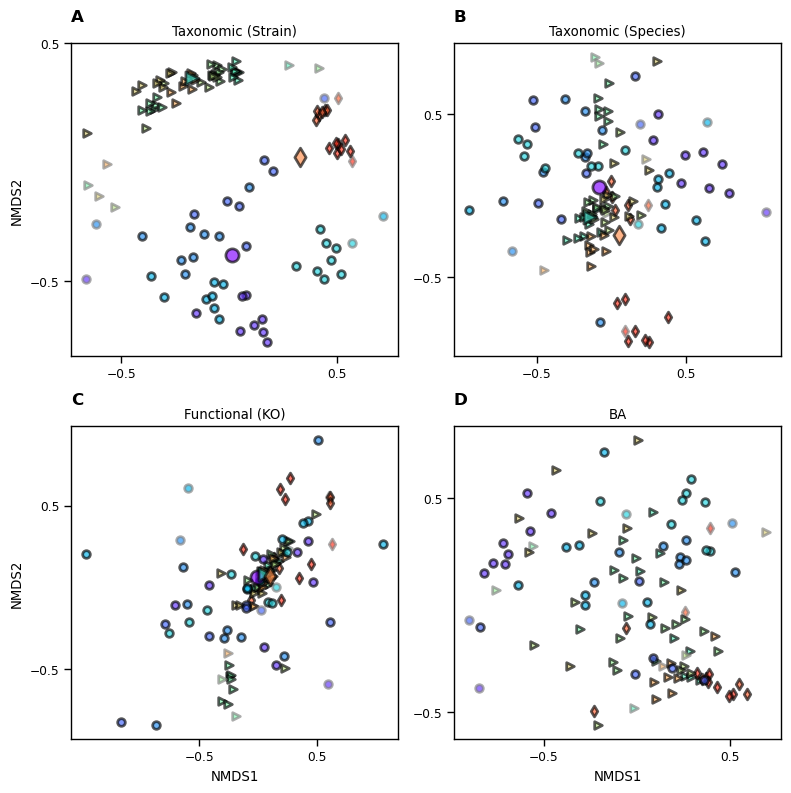

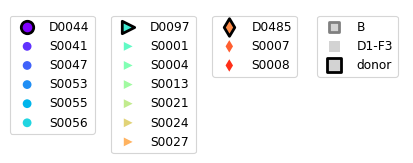

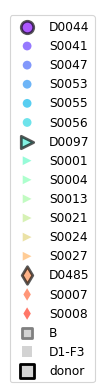

In [ ]:
m = (
    sample.join(subject, on="subject_id", lsuffix="_")
    .assign(subject_type=lambda x: x.recipient.map({True: "recipient", False: "donor"}))
    .assign(zorder=lambda x: x.recipient.map({True: 0, False: 1}))
)

s = m.sample_type.isin(lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE + ["donor_mean"])
edgecolor_palette = {
    "donor": "black",
    "baseline": "grey",
    "maintenance": "none",
    "followup": "none",
}

markersize_palette = {
    "recipient": 30,
    "donor": 90,
}

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for (name, d, metric, panel), ax in zip(
    [
        ("sotu", sample_x_sotu, "braycurtis", "A"),
        ("motu", sample_x_motu, "braycurtis", "B"),
        #     ('eggnog', sample_x_eggnog_cvrg, 'cosine'),
        ("ko", sample_x_ko_cvrg, "cosine", "C"),
        ("chem_ba", sample_x_chem_ba_std2, "cosine", "D"),
    ],
    axs.flatten(),
):
    ax, _ = lib.plot.ordination_plot(
        data=d,
        meta=m,
        subset=s,
        ordin_kws=dict(metric=metric),
        xy=("PC1", "PC2"),
        colorby="subject_id",
        color_palette=subject_color_palette,
        colorby_order=list(subject_color_palette),
        edgecolorby="sample_class",
        edgecolor_palette=edgecolor_palette,
        edgecolorby_order=list(edgecolor_palette),
        markerby="donor_subject_id",
        marker_palette=lib.project_style.DEFAULT_MARKER_PALETTE,
        markersizeby="subject_type",
        markersize_palette=markersize_palette,
        markersizeby_order=list(markersize_palette),
        zorderby="zorder",
        scatter_kws=dict(lw=2, alpha=0.65),
        frac_explained_label=False,
        ax=ax,
        fill_legend=False,
    )
    ax.set_title(lib.project_style.OMICS_NAME[name])
    ax.get_legend().set_visible(False)
    ax.set_xticks([-0.5, 0.5])
    ax.set_yticks([-0.5, 0.5])
    ax.text(-0.0, 1.07, panel, fontsize=12, fontweight="heavy", transform=ax.transAxes)
    ax.set_ylabel("")
    ax.set_xlabel("")

for ax in axs[-1, :]:
    ax.set_xlabel("NMDS1")
for ax in axs[:, 0]:
    ax.set_ylabel("NMDS2")

fig.tight_layout()
fig.savefig("fig/multiomics_ordination_by_subject.pdf", bbox_inches="tight")


# Legend
fig, axs = plt.subplots(1, 4, figsize=(5, 0.5))

donor_ax = {"D0044": 0, "D0097": 1, "D0485": 2, "other": 3}

for subject_id, d in subject.loc[subject_has_mgen_order].iterrows():
    s = {True: 40, False: 80}[d.recipient]
    marker = lib.project_style.DEFAULT_MARKER_PALETTE[d.donor_subject_id]
    lw, edgecolor = {True: (0, "none"), False: (2, "black")}[d.recipient]
    c = subject_color_palette[subject_id]
    axs[donor_ax[d.donor_subject_id]].scatter(
        [], [], c=[c], s=s, marker=marker, lw=lw, edgecolor=edgecolor, label=subject_id
    )

for sample_class, label in {"baseline": "B", "maintenance": "D1-F3"}.items():
    s = 60
    marker = "s"
    lw, edgecolor = 2, edgecolor_palette[sample_class]
    c = "lightgrey"
    axs[donor_ax["other"]].scatter(
        [], [], c=[c], s=s, marker=marker, lw=lw, edgecolor=edgecolor, label=label
    )

for subject_type in ["donor"]:
    s = markersize_palette[subject_type]
    marker = "s"
    c = "lightgrey"
    edgecolor = edgecolor_palette[subject_type]
    axs[donor_ax["other"]].scatter(
        [], [], c=[c], lw=2, edgecolor=edgecolor, s=s, marker=marker, label=subject_type
    )

for ax in axs:
    ax.legend()
    for spines in ["top", "right", "bottom", "left"]:
        ax.spines[spines].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig("fig/ordination_by_subject_legend.pdf", bbox_inches="tight")

# Legend
fig, ax = plt.subplots(figsize=(0.5, 0.5))

donor_ax = {"D0044": 0, "D0097": 1, "D0485": 2, "other": 3}

for subject_id, d in subject.loc[subject_has_mgen_order].iterrows():
    s = {True: 40, False: 80}[d.recipient]
    marker = lib.project_style.DEFAULT_MARKER_PALETTE[d.donor_subject_id]
    lw, edgecolor = {True: (0, "none"), False: (2, "black")}[d.recipient]
    c = subject_color_palette[subject_id]
    ax.scatter(
        [],
        [],
        c=[c],
        s=s,
        marker=marker,
        lw=lw,
        edgecolor=edgecolor,
        label=subject_id,
        alpha=0.65,
    )

for sample_class, label in {"baseline": "B", "maintenance": "D1-F3"}.items():
    s = 60
    marker = "s"
    lw, edgecolor = 2, edgecolor_palette[sample_class]
    c = "lightgrey"
    ax.scatter(
        [], [], c=[c], s=s, marker=marker, lw=lw, edgecolor=edgecolor, label=label
    )

for subject_type in ["donor"]:
    s = markersize_palette[subject_type]
    marker = "s"
    c = "lightgrey"
    edgecolor = edgecolor_palette[subject_type]
    ax.scatter(
        [], [], c=[c], lw=2, edgecolor=edgecolor, s=s, marker=marker, label=subject_type
    )

ax.legend()
for spines in ["top", "right", "bottom", "left"]:
    ax.spines[spines].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
fig.savefig("fig/ordination_by_subject_legend_vertical.pdf", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


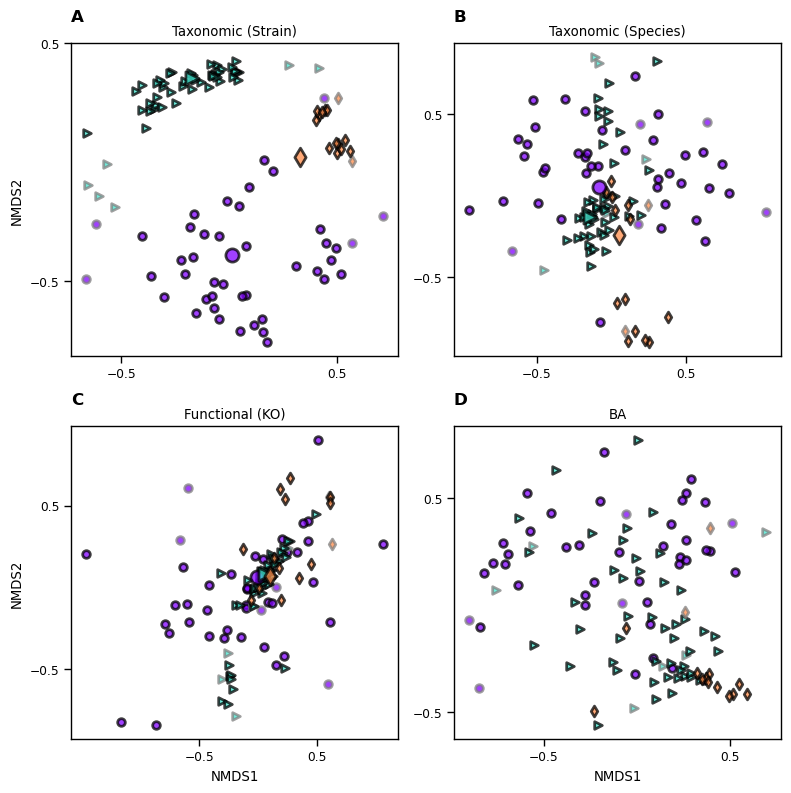

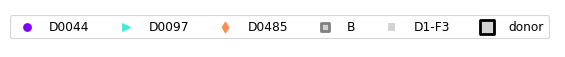

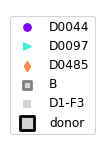

In [ ]:
m = (
    sample.join(subject, on="subject_id", lsuffix="_")
    .assign(subject_type=lambda x: x.recipient.map({True: "recipient", False: "donor"}))
    .assign(zorder=lambda x: x.recipient.map({True: 0, False: 1}))
)

s = m.sample_type.isin(lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE + ["donor_mean"])
edgecolor_palette = {
    "donor": "black",
    "baseline": "grey",
    "maintenance": "none",
    "followup": "none",
}

markersize_palette = {
    "recipient": 30,
    "donor": 90,
}

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for (name, d, metric, panel), ax in zip(
    [
        ("sotu", sample_x_sotu, "braycurtis", "A"),
        ("motu", sample_x_motu, "braycurtis", "B"),
        #     ('eggnog', sample_x_eggnog_cvrg, 'cosine'),
        ("ko", sample_x_ko_cvrg, "cosine", "C"),
        ("chem_ba", sample_x_chem_ba_std2, "cosine", "D"),
    ],
    axs.flatten(),
):
    ax, _ = lib.plot.ordination_plot(
        data=d,
        meta=m,
        subset=s,
        ordin_kws=dict(metric=metric),
        xy=("PC1", "PC2"),
        colorby="donor_subject_id",
        color_palette=subject_color_palette,
        colorby_order=list(subject_color_palette),
        edgecolorby="sample_class",
        edgecolor_palette=edgecolor_palette,
        edgecolorby_order=list(edgecolor_palette),
        markerby="donor_subject_id",
        marker_palette=lib.project_style.DEFAULT_MARKER_PALETTE,
        markersizeby="subject_type",
        markersize_palette=markersize_palette,
        markersizeby_order=list(markersize_palette),
        zorderby="zorder",
        scatter_kws=dict(lw=2, alpha=0.75),
        frac_explained_label=False,
        ax=ax,
        fill_legend=False,
    )
    ax.set_title(lib.project_style.OMICS_NAME[name])
    ax.get_legend().set_visible(False)
    ax.set_xticks([-0.5, 0.5])
    ax.set_yticks([-0.5, 0.5])
    ax.text(-0.0, 1.07, panel, fontsize=12, fontweight="heavy", transform=ax.transAxes)
    ax.set_ylabel("")
    ax.set_xlabel("")

for ax in axs[-1, :]:
    ax.set_xlabel("NMDS1")
for ax in axs[:, 0]:
    ax.set_ylabel("NMDS2")

fig.tight_layout()
fig.savefig("fig/multiomics_ordination_by_donor.pdf", bbox_inches="tight")


# Legend as a figure
fig, ax = plt.subplots(1, 1, figsize=(1, 0.5))

for donor_subject_id in donor_order:
    s = markersize_palette["recipient"]
    marker = lib.project_style.DEFAULT_MARKER_PALETTE[donor_subject_id]
    c = subject_color_palette[donor_subject_id]
    ax.scatter([], [], c=[c], s=s, marker=marker, label=donor_subject_id)

for sample_class, label in {"baseline": "B", "maintenance": "D1-F3"}.items():
    s = markersize_palette["recipient"]
    marker = "s"
    lw, edgecolor = 2, edgecolor_palette[sample_class]
    c = "lightgrey"
    ax.scatter(
        [], [], c=[c], s=s, marker=marker, lw=lw, edgecolor=edgecolor, label=label
    )

for subject_type in ["donor"]:
    s = markersize_palette[subject_type]
    marker = "s"
    c = "lightgrey"
    edgecolor = edgecolor_palette[subject_type]
    ax.scatter(
        [], [], c=[c], lw=2, edgecolor=edgecolor, s=s, marker=marker, label=subject_type
    )

ax.legend(ncol=6)
for spines in ["top", "right", "bottom", "left"]:
    ax.spines[spines].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig("fig/ordination_by_donor_legend_horizontal.pdf", bbox_inches="tight")


# Legend as a figure
fig, ax = plt.subplots(1, 1, figsize=(1, 0.5))

for donor_subject_id in donor_order:
    s = markersize_palette["recipient"]
    marker = lib.project_style.DEFAULT_MARKER_PALETTE[donor_subject_id]
    c = subject_color_palette[donor_subject_id]
    ax.scatter([], [], c=[c], s=s, marker=marker, label=donor_subject_id)

for sample_class, label in {"baseline": "B", "maintenance": "D1-F3"}.items():
    s = markersize_palette["recipient"]
    marker = "s"
    lw, edgecolor = 2, edgecolor_palette[sample_class]
    c = "lightgrey"
    ax.scatter(
        [], [], c=[c], s=s, marker=marker, lw=lw, edgecolor=edgecolor, label=label
    )

for subject_type in ["donor"]:
    s = markersize_palette[subject_type]
    marker = "s"
    c = "lightgrey"
    edgecolor = edgecolor_palette[subject_type]
    ax.scatter(
        [], [], c=[c], lw=2, edgecolor=edgecolor, s=s, marker=marker, label=subject_type
    )

ax.legend(ncol=1)
for spines in ["top", "right", "bottom", "left"]:
    ax.spines[spines].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig("fig/ordination_by_donor_legend_vertical.pdf", bbox_inches="tight")

In [ ]:
grouping = "donor_subject_id"

donor_anosim_results = []
for dname, d, metric in tqdm(
    [
        ("sotu", sample_x_sotu, "braycurtis"),
        ("motu", sample_x_motu, "braycurtis"),
        ("rotu", sample_x_rotu, "braycurtis"),
        #     ('eggnog', sample_x_eggnog_cvrg, 'cosine'),
        ("ko", sample_x_ko_cvrg, "cosine"),
        #     ('keggmodule', sample_x_keggmodule_cvrg, 'cosine'),
        #     ('chem', sample_x_chem_std2, 'cosine'),
        ("chem_ba", sample_x_chem_ba_std2, "cosine"),
    ],
    ascii=True,
):
    for sample_type in lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE:
        m = sample.join(subject, on="subject_id", lsuffix="_").assign(
            subject_type=lambda x: x.recipient.map({True: "recipient", False: "donor"})
        )
        d, m = lib.pandas.align_indexes(d, m)
        dmat = lib.dissimilarity.dmatrix(d, metric=metric)
        donor_anosim_results.append(
            (
                dname,
                sample_type,
                *lib.stats.anosim(
                    dmat, m[grouping], subset=m.sample_type.isin([sample_type]), n=9999
                )[["test statistic", "p-value"]],
            )
        )

donor_anosim_results = pd.DataFrame(
    donor_anosim_results, columns=["dataset", "sample_type", "r", "p"]
)

donor_anosim_r = donor_anosim_results.set_index(["sample_type", "dataset"])[
    "r"
].unstack()
donor_anosim_p = donor_anosim_results.set_index(["sample_type", "dataset"])[
    "p"
].unstack()

donor_anosim_r

100%|##########################################################################################################################| 5/5 [00:30<00:00,  6.10s/it]


dataset,chem_ba,ko,motu,rotu,sotu
sample_type,,,,,
baseline,-0.051775,0.238166,0.014793,-0.094482,-0.090237
followup_1,0.183432,0.174556,0.334320,0.136054,0.961538
followup_2,0.223373,-0.031065,0.180473,0.240870,0.928994
pre_maintenance_1,0.088000,0.248000,0.344000,0.284382,1.000000
pre_maintenance_2,0.095238,0.092437,0.532213,0.399111,1.000000
pre_maintenance_3,0.109467,0.211538,0.439349,0.211462,1.000000
pre_maintenance_4,0.008876,0.109467,0.375740,0.404755,0.998521
pre_maintenance_5,0.140533,0.337566,0.422222,0.302871,0.995767
pre_maintenance_6,0.034056,-0.021672,0.151703,0.181818,1.000000


In [ ]:
donor_anosim_p

dataset,chem_ba,ko,motu,rotu,sotu
sample_type,,,,,
baseline,0.6146,0.0390,0.4453,0.6787,0.7454
followup_1,0.0922,0.1084,0.0126,0.1125,0.0002
followup_2,0.0599,0.5375,0.0889,0.0478,0.0001
pre_maintenance_1,0.2464,0.0462,0.0491,0.0298,0.0077
pre_maintenance_2,0.2360,0.2647,0.0040,0.0140,0.0009
pre_maintenance_3,0.1991,0.0701,0.0022,0.0372,0.0001
pre_maintenance_4,0.4307,0.1988,0.0052,0.0027,0.0001
pre_maintenance_5,0.1403,0.0168,0.0029,0.0173,0.0004
pre_maintenance_6,0.3786,0.5140,0.1665,0.1327,0.0001


/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/4114870097.py:34: RuntimeWarning: Second argument 'r' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax.plot(
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/4114870097.py:34: RuntimeWarning: Second argument 'r' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax.plot(
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/4114870097.py:34: RuntimeWarning: Second argument 'r' is ambiguous: could be a format string bu

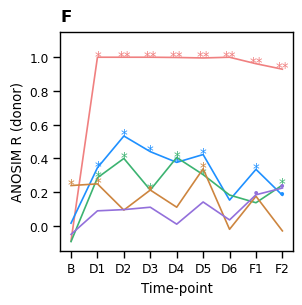

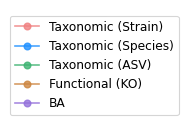

In [ ]:
def _p_to_s(p):
    if p < 0.05:
        return 40
    elif p < 0.10:
        return 15
    else:
        return 0


sample_type_order_idx = pd.Series(
    {v: i for i, v in enumerate(lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE)}
)
sample_type_tick_labels = [
    lib.project_style.SAMPLE_TYPE_LABELS[sample_type]
    for sample_type in lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE
]

assert len(sample_type_tick_labels) == len(sample_type_order_idx)

datatypes = ["sotu", "motu", "rotu", "ko", "chem_ba"]
zorder_palette = {"sotu": 0, "motu": 1, "rotu": 2, "ko": 3, "chem_ba": 4}

fig, ax = plt.subplots(figsize=(3, 2.9))

for col in datatypes:
    d0 = pd.DataFrame(
        dict(
            r=donor_anosim_r[col],
            p=donor_anosim_p[col],
            s=donor_anosim_p[col].map(_p_to_s),
            x=sample_type_order_idx,
        )
    ).sort_values("x")
    ax.plot(
        "x",
        "r",
        data=d0,
        label="__nolegend__",
        c=lib.project_style.DEFAULT_COLOR_PALETTE[col],
        alpha=1.0,
        zorder=zorder_palette[col],
    )
    ax.plot(
        [],
        [],
        marker="o",
        linestyle="-",
        label=lib.project_style.OMICS_NAME[col],
        c=lib.project_style.DEFAULT_COLOR_PALETTE[col],
        alpha=1.0,
    )
    for _, d1 in d0.iterrows():
        annotation = lib.project_style.pvalue_to_annotation(d1.p)
        if annotation == "∙":
            yoffset = 0.02
        elif annotation == "**":
            yoffset = 0.01
        elif annotation == "*":
            yoffset = 0.01
        elif annotation == "":
            yoffset = 0
        ax.annotate(
            annotation,
            xy=(d1.x, d1.r + yoffset),
            color=lib.project_style.DEFAULT_COLOR_PALETTE[col],
            ha="center",
            va="center",
            zorder=zorder_palette[col],
        )
#     plt.scatter('x', 'r', data=d, s='s', label='__nolegend__', vmin=0, vmax=1, marker='o')
#     plt.xticks(ticks=d.x, labels=idxwhere(sample_type_order_idx.isin(d.x)), rotation=45, ha='right')

# # Dummy points for legend:
# plt.plot([], [], markersize=_p_to_s(0.04)/5, color='grey', linestyle='-', marker='o', label='p < 0.05')
# plt.plot([], [], markersize=_p_to_s(0.09)/5, color='grey', linestyle='-', marker='o', label='p < 0.10')
# # plt.plot([], [], markersize=_p_to_s(0.051)/6, color='grey', linestyle='-', marker='o', label='p>=0.05')


ax.set_ylim(-0.15, 1.15)
# ax.set_yticklabels([])

# ax.legend(bbox_to_anchor=(0.4, 0.465))
ax.set_ylabel("ANOSIM R (donor)")
ax.set_xlabel("Time-point")
plt.xticks(range(len(sample_type_tick_labels)), sample_type_tick_labels)
# ax.set_title('By Donor')
ax.text(-0.0, 1.05, "F", fontsize=12, fontweight="heavy", transform=plt.gca().transAxes)
fig.savefig("fig/multiomics_anosim_by_donor.pdf", bbox_inches="tight")

# Legend
fig, ax = plt.subplots(figsize=(1, 1))
for col in datatypes:
    ax.plot(
        [],
        [],
        marker="o",
        linestyle="-",
        label=lib.project_style.OMICS_NAME[col],
        c=lib.project_style.DEFAULT_COLOR_PALETTE[col],
        alpha=0.8,
    )
ax.legend()
ax.legend(ncol=1)
for spines in ["top", "right", "bottom", "left"]:
    ax.spines[spines].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

donor_anosim_p
fig.savefig("fig/multiomics_line_point_legend.pdf", bbox_inches="tight")

In [ ]:
grouping = "sex"

_anosim_results = []
for dname, d, metric in tqdm(
    [
        ("sotu", sample_x_sotu, "braycurtis"),
        ("motu", sample_x_motu, "braycurtis"),
        ("rotu", sample_x_rotu, "braycurtis"),
        #     ('eggnog', sample_x_eggnog_cvrg, 'cosine'),
        ("ko", sample_x_ko_cvrg, "cosine"),
        #     ('keggmodule', sample_x_keggmodule_cvrg, 'cosine'),
        #     ('chem', sample_x_chem_std2, 'cosine'),
        ("chem_ba", sample_x_chem_ba_std2, "cosine"),
    ],
    ascii=True,
):
    for sample_type in lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE:
        m = sample.join(subject, on="subject_id", lsuffix="_").assign(
            subject_type=lambda x: x.recipient.map({True: "recipient", False: "donor"})
        )
        d, m = lib.pandas.align_indexes(d, m)
        dmat = lib.dissimilarity.dmatrix(d, metric=metric)
        _anosim_results.append(
            (
                dname,
                sample_type,
                *lib.stats.anosim(
                    dmat, m[grouping], subset=m.sample_type.isin([sample_type]), n=9999
                )[["test statistic", "p-value"]],
            )
        )

_anosim_results = pd.DataFrame(
    _anosim_results, columns=["dataset", "sample_type", "r", "p"]
)

sex_anosim_r = _anosim_results.set_index(["sample_type", "dataset"])[
    "r"
].unstack()
sex_anosim_p = _anosim_results.set_index(["sample_type", "dataset"])[
    "p"
].unstack()

sex_anosim_r

100%|##########################################################################################################################| 5/5 [00:27<00:00,  5.49s/it]


dataset,chem_ba,ko,motu,rotu,sotu
sample_type,,,,,
baseline,0.074074,-0.046296,0.103175,0.024052,-0.023810
followup_1,0.085979,-0.007937,0.003968,0.108844,-0.048942
followup_2,-0.048942,-0.047619,0.011905,0.153790,0.144180
pre_maintenance_1,-0.124000,0.160000,0.432000,0.114742,0.024000
pre_maintenance_2,-0.166667,0.082667,0.042667,0.039444,-0.136000
pre_maintenance_3,-0.070106,-0.064815,-0.095238,0.026476,-0.085979
pre_maintenance_4,-0.051587,0.140212,-0.070106,-0.016741,-0.058201
pre_maintenance_5,-0.015873,0.074074,0.016667,0.064732,-0.133333
pre_maintenance_6,-0.141333,0.144000,0.157333,0.055556,0.085333


/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/1964846424.py:34: RuntimeWarning: Second argument 'r' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax.plot(
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/1964846424.py:34: RuntimeWarning: Second argument 'r' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax.plot(
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/1964846424.py:34: RuntimeWarning: Second argument 'r' is ambiguous: could be a format string bu

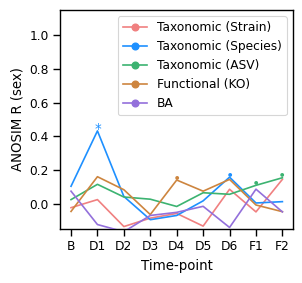

In [ ]:
def _p_to_s(p):
    if p < 0.05:
        return 40
    elif p < 0.10:
        return 15
    else:
        return 0


sample_type_order_idx = pd.Series(
    {v: i for i, v in enumerate(lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE)}
)
sample_type_tick_labels = [
    lib.project_style.SAMPLE_TYPE_LABELS[sample_type]
    for sample_type in lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE
]

assert len(sample_type_tick_labels) == len(sample_type_order_idx)

datatypes = ["sotu", "motu", "rotu", "ko", "chem_ba"]
zorder_palette = {"sotu": 0, "motu": 1, "rotu": 2, "ko": 3, "chem_ba": 4}

fig, ax = plt.subplots(figsize=(3, 2.9))

for col in datatypes:
    d0 = pd.DataFrame(
        dict(
            r=sex_anosim_r[col],
            p=sex_anosim_p[col],
            s=sex_anosim_p[col].map(_p_to_s),
            x=sample_type_order_idx,
        )
    ).sort_values("x")
    ax.plot(
        "x",
        "r",
        data=d0,
        label="__nolegend__",
        c=lib.project_style.DEFAULT_COLOR_PALETTE[col],
        alpha=1.0,
        zorder=zorder_palette[col],
    )
    ax.plot(
        [],
        [],
        marker="o",
        linestyle="-",
        label=lib.project_style.OMICS_NAME[col],
        c=lib.project_style.DEFAULT_COLOR_PALETTE[col],
        alpha=1.0,
    )
    for _, d1 in d0.iterrows():
        annotation = lib.project_style.pvalue_to_annotation(d1.p)
        if annotation == "∙":
            yoffset = 0.02
        elif annotation == "**":
            yoffset = 0.01
        elif annotation == "*":
            yoffset = 0.01
        elif annotation == "":
            yoffset = 0
        ax.annotate(
            annotation,
            xy=(d1.x, d1.r + yoffset),
            color=lib.project_style.DEFAULT_COLOR_PALETTE[col],
            ha="center",
            va="center",
            zorder=zorder_palette[col],
        )
#     plt.scatter('x', 'r', data=d, s='s', label='__nolegend__', vmin=0, vmax=1, marker='o')
#     plt.xticks(ticks=d.x, labels=idxwhere(sample_type_order_idx.isin(d.x)), rotation=45, ha='right')

# # Dummy points for legend:
# plt.plot([], [], markersize=_p_to_s(0.04)/5, color='grey', linestyle='-', marker='o', label='p < 0.05')
# plt.plot([], [], markersize=_p_to_s(0.09)/5, color='grey', linestyle='-', marker='o', label='p < 0.10')
# # plt.plot([], [], markersize=_p_to_s(0.051)/6, color='grey', linestyle='-', marker='o', label='p>=0.05')


ax.set_ylim(-0.15, 1.15)
# ax.set_yticklabels([])

# ax.legend(bbox_to_anchor=(0.4, 0.465))
ax.set_ylabel("ANOSIM R (sex)")
ax.set_xlabel("Time-point")
plt.xticks(range(len(sample_type_tick_labels)), sample_type_tick_labels)


# for col in datatypes:
#     ax.plot(
#         [],
#         [],
#         marker="o",
#         linestyle="-",
#         label=lib.project_style.OMICS_NAME[col],
#         c=lib.project_style.DEFAULT_COLOR_PALETTE[col],
#         alpha=0.8,
#     )
ax.legend()

# ax.set_title('By Donor')
# ax.text(-0.0, 1.05, "F", fontsize=12, fontweight="heavy", transform=plt.gca().transAxes)
fig.savefig("doc/static/multiomics_anosim_by_sex_figure.svg", bbox_inches="tight")

In [ ]:
grouping = "subject_id"
m = sample.join(subject, on="subject_id", lsuffix="_").assign(
    subject_type=lambda x: x.recipient.map({True: "recipient", False: "donor"})
)
subset = m.sample_type.isin(lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE)

subject_anosim_results = []
for dname, d, metric in [
    ("sotu", sample_x_sotu, "braycurtis"),
    ("motu", sample_x_motu, "braycurtis"),
    ("rotu", sample_x_rotu, "braycurtis"),
    #     ('eggnog', sample_x_eggnog_cvrg, 'cosine'),
    ("ko", sample_x_ko_cvrg, "cosine"),
    #     ('keggmodule', sample_x_keggmodule_cvrg, 'cosine'),
    ("chem_ba", sample_x_chem_ba_std2, "cosine"),
    #     ('chem', sample_x_chem_std2, 'cosine'),
]:
    d, m = lib.pandas.align_indexes(d, m)
    dmat = lib.dissimilarity.dmatrix(d, metric="braycurtis")
    subject_anosim_results.append(
        (
            dname,
            *lib.stats.anosim(dmat, m[grouping], subset=subset)[
                ["test statistic", "p-value"]
            ],
        )
    )

subject_anosim_results = pd.DataFrame(
    subject_anosim_results, columns=["dataset", "r", "p"]
)
subject_anosim_results

,dataset,r,p
0,sotu,0.895606,0.001
1,motu,0.723178,0.001
2,rotu,0.736131,0.001
3,ko,0.330117,0.001
4,chem_ba,0.509164,0.001


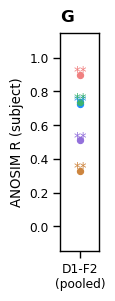

In [ ]:
fig, ax = plt.subplots(figsize=(0.5, 2.9))

datatypes = ["sotu", "motu", "rotu", "ko", "chem_ba"]

d0 = subject_anosim_results.set_index("dataset")

for col in datatypes:
    d1 = d0.loc[col]
    ax.scatter(
        [0],
        d1.r,
        marker="o",
        s=20,
        label=lib.project_style.OMICS_NAME[col],
        c=lib.project_style.DEFAULT_COLOR_PALETTE[col],
        alpha=1.0,
    )
    annotation = lib.project_style.pvalue_to_annotation(d1.p)
    if annotation == "∙":
        yoffset = 0.03
    elif annotation == "**":
        yoffset = 0.02
    elif annotation == "*":
        yoffset = 0.02
    elif annotation == "":
        yoffset = 0
    ax.annotate(
        annotation,
        xy=(0, d1.r + yoffset),
        color=lib.project_style.DEFAULT_COLOR_PALETTE[col],
        ha="center",
        va="center",
        alpha=1.0,
    )

# ax.set_yticks([])
ax.set_ylim(-0.15, 1.15)
ax.set_xticks([0])
ax.set_xticklabels(["D1-F2\n(pooled)"])
plt.ylabel("ANOSIM R (subject)")
# plt.title('By Subject')
plt.text(
    -0.0, 1.05, "G", fontsize=12, fontweight="heavy", transform=plt.gca().transAxes
)
fig.savefig("fig/multiomics_anosim_by_subject.pdf", bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(-0.0, 1.07, 'X')

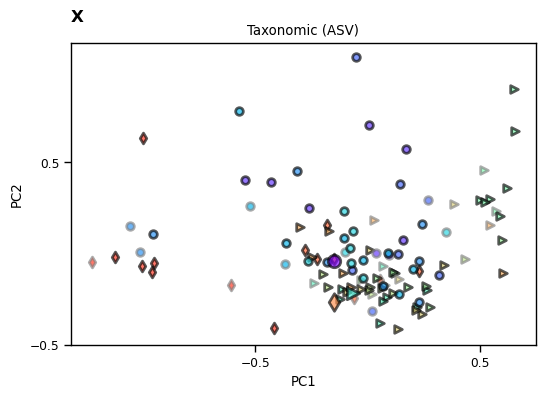

In [ ]:
import skbio as skb

m = (
    sample.join(subject, on="subject_id", lsuffix="_")
    .assign(subject_type=lambda x: x.recipient.map({True: "recipient", False: "donor"}))
    .assign(zorder=lambda x: x.recipient.map({True: 0, False: 1}))
)

tree = skb.io.read(
    "sraw/2020-12-30-Dose_Finding_Study_Box_mirror/16S data files/dada2_optim_tree_OTUtips_FMT_VED_May2019.tre",
    into=skb.TreeNode,
).root_at_midpoint()

s = m.sample_type.isin(lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE + ["donor_mean"])
edgecolor_palette = {
    "donor": "black",
    "baseline": "black",
    "maintenance": "none",
    "followup": "grey",
}

markersize_palette = {
    "recipient": 30,
    "donor": 80,
}

fig, ax = plt.subplots()
name, d, metric, panel, ax = (
    "rotu",
    sample_x_rotu_cvrg.rename(columns=lambda s: s.replace("_", " ")),
    "braycurtis",
    "X",
    ax,
)

ax, _ = lib.plot.ordination_plot(
    data=d,
    meta=m,
    subset=s,
    ordin_kws=dict(
        pdm_func=lambda d: skb.diversity.beta_diversity(
            "weighted_unifrac",
            counts=d,
            ids=d.index,
            otu_ids=d.columns,
            tree=tree,
            normalized=True,
        ).to_data_frame()
    ),
    xy=("PC1", "PC2"),
    colorby="subject_id",
    color_palette=subject_color_palette,
    colorby_order=list(subject_color_palette),
    edgecolorby="sample_class",
    edgecolor_palette=edgecolor_palette,
    edgecolorby_order=list(edgecolor_palette),
    markerby="donor_subject_id",
    marker_palette=lib.project_style.DEFAULT_MARKER_PALETTE,
    markersizeby="subject_type",
    markersize_palette=markersize_palette,
    markersizeby_order=list(markersize_palette),
    zorderby="zorder",
    scatter_kws=dict(lw=2, alpha=0.65),
    frac_explained_label=False,
    ax=ax,
    fill_legend=False,
)
ax.set_title(lib.project_style.OMICS_NAME[name])
ax.get_legend().set_visible(False)
ax.set_xticks([-0.5, 0.5])
ax.set_yticks([-0.5, 0.5])
ax.text(-0.0, 1.07, panel, fontsize=12, fontweight="heavy", transform=ax.transAxes)
# ax.set_ylabel('')
# ax.set_xlabel('')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


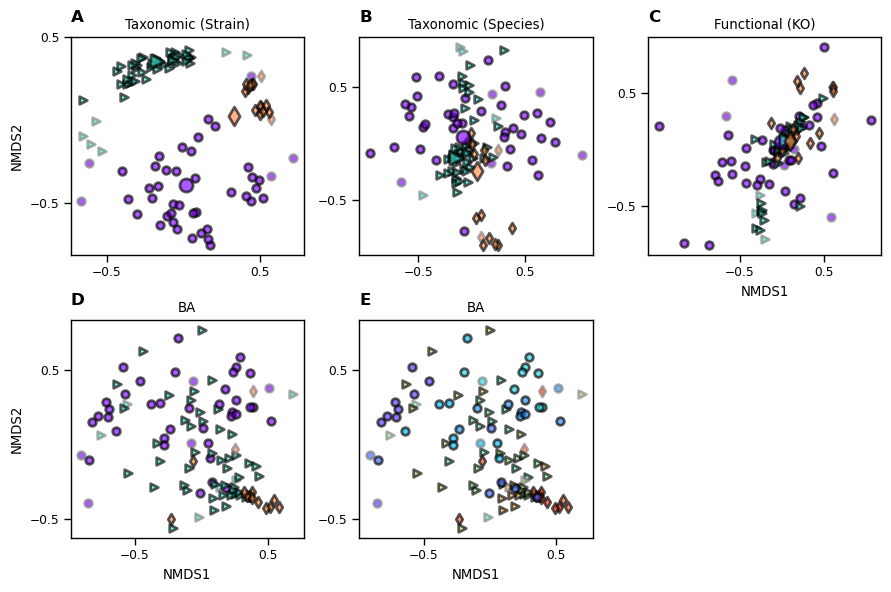

In [ ]:
m = (
    sample.join(subject, on="subject_id", lsuffix="_")
    .assign(subject_type=lambda x: x.recipient.map({True: "recipient", False: "donor"}))
    .assign(zorder=lambda x: x.recipient.map({True: 0, False: 1}))
)

s = m.sample_type.isin(lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE + ["donor_mean"])
edgecolor_palette = {
    "donor": "black",
    "baseline": "grey",
    "maintenance": "none",
    "followup": "none",
}

markersize_palette = {
    "recipient": 30,
    "donor": 90,
}

fig, axs = plt.subplots(2, 3, figsize=(9, 6))
for (name, d, metric, panel, colorby), ax in zip(
    [
        ("sotu", sample_x_sotu, "braycurtis", "A", "donor_subject_id"),
        ("motu", sample_x_motu, "braycurtis", "B", "donor_subject_id"),
        #     ('eggnog', sample_x_eggnog_cvrg, 'cosine', 'donor_subject_id'),
        ("ko", sample_x_ko_cvrg, "cosine", "C", "donor_subject_id"),
        ("chem_ba", sample_x_chem_ba_std2, "cosine", "D", "donor_subject_id"),
        ("chem_ba", sample_x_chem_ba_std2, "cosine", "E", "subject_id"),
    ],
    axs.flatten(),
):
    ax, _ = lib.plot.ordination_plot(
        data=d,
        meta=m,
        subset=s,
        ordin_kws=dict(metric=metric),
        xy=("PC1", "PC2"),
        colorby=colorby,
        color_palette=subject_color_palette,
        colorby_order=list(subject_color_palette),
        edgecolorby="sample_class",
        edgecolor_palette=edgecolor_palette,
        edgecolorby_order=list(edgecolor_palette),
        markerby="donor_subject_id",
        marker_palette=lib.project_style.DEFAULT_MARKER_PALETTE,
        markersizeby="subject_type",
        markersize_palette=markersize_palette,
        markersizeby_order=list(markersize_palette),
        zorderby="zorder",
        scatter_kws=dict(lw=2, alpha=0.65),
        frac_explained_label=False,
        ax=ax,
        fill_legend=False,
    )
    ax.set_title(lib.project_style.OMICS_NAME[name])
    ax.get_legend().set_visible(False)
    ax.set_xticks([-0.5, 0.5])
    ax.set_yticks([-0.5, 0.5])
    ax.text(-0.0, 1.07, panel, fontsize=12, fontweight="heavy", transform=ax.transAxes)
    ax.set_ylabel("")
    ax.set_xlabel("")

for ax in axs[-1, :]:
    ax.set_xlabel("NMDS1")
for ax in axs[:, 0]:
    ax.set_ylabel("NMDS2")

# Remove visual evidence of bottom right axis.
axs[0, -1].set_xlabel("NMDS1")
for spines in ["top", "right", "bottom", "left"]:
    axs[-1, -1].spines[spines].set_visible(False)
axs[-1, -1].set_xticks([])
axs[-1, -1].set_yticks([])
axs[-1, -1].set_xlabel(None)
axs[-1, -1].set_ylabel(None)

fig.tight_layout()
fig.savefig("fig/multiomics_ordination_combo.pdf", bbox_inches="tight")

## Subsection: Transfer and engraftment of donor taxa in patients

In [ ]:
subject_to_baseline_sample = (
    sample[sample.sample_type == "baseline"]
    .reset_index()
    .set_index("subject_id")
    .sample_id
)
donor_to_donor_mean = (
    sample[sample.sample_type == "donor_mean"]
    .reset_index()
    .set_index("subject_id")
    .sample_id.rename_axis("donor_subject_id")
)
all_donor_mean_samples = donor_to_donor_mean.to_list()

assert subject_to_baseline_sample.index.is_unique
assert donor_to_donor_mean.index.is_unique
subject_to_baseline_sample, donor_to_donor_mean

(subject_id
 S0001    SS01002
 S0004    SS01000
 S0007    SS01020
 S0008    SS01038
 S0013    SS01013
 S0017    SS01021
 S0021    SS01068
 S0024    SS01057
 S0027    SS01090
 S0029    SS01058
 S0031    SS01041
 S0037    SS01095
 S0041    SS01117
 S0043    SS01099
 S0047    SS01135
 S0053    SS01134
 S0055    SS01150
 S0056    SS01164
 S0058    SS01178
 S0059    SS01173
 S0060    SS01180
 S0061    SS01179
 S0062    SS01198
 Name: sample_id, dtype: object,
 donor_subject_id
 D0044    D0044_mean
 D0097    D0097_mean
 D0485    D0485_mean
 Name: sample_id, dtype: object)

### ASV-level analysis

In [ ]:
d0 = sample_x_rotu
thresh = 1e-6  # Thresh used for jaccard presence/absence.

taxon_class = {}
taxon_class_rabund = []
taxon_class_count = []
baseline_bc = []
donor_bc = []
baseline_jacc = []
donor_jacc = []


for subject_id, d1 in d0.groupby(sample.subject_id):
    if not subject_id in recipient_has_mgen_order:
        continue

    donor_sample_id = donor_to_donor_mean[subject.loc[subject_id, "donor_subject_id"]]
    other_donor_samples = list(set(all_donor_mean_samples) - set([donor_sample_id]))
    donor_bc.append(
        pd.Series(
            sp.spatial.distance.cdist(
                d0.loc[[donor_sample_id]], d1, metric="braycurtis"
            ).squeeze(),
            index=d1.index,
        )
    )
    donor_jacc.append(
        pd.Series(
            sp.spatial.distance.cdist(
                d0.loc[[donor_sample_id]] > thresh, d1 > thresh, metric="jaccard"
            ).squeeze(),
            index=d1.index,
        )
    )

    if not subject_to_baseline_sample[subject_id] in d0.index:
        warn(f"No baseline sample for {subject_id}. Skipping this subject.")
        continue
    baseline_sample_id = subject_to_baseline_sample[subject_id]
    baseline_bc.append(
        pd.Series(
            sp.spatial.distance.cdist(
                d0.loc[[baseline_sample_id]], d1, metric="braycurtis"
            ).squeeze(),
            index=d1.index,
        )
    )
    baseline_jacc.append(
        pd.Series(
            sp.spatial.distance.cdist(
                d0.loc[[baseline_sample_id]] > thresh, d1 > thresh, metric="jaccard"
            ).squeeze(),
            index=d1.index,
        )
    )

    taxon_class[subject_id] = lib.engraftment.classify_taxon_sets(
        d0, baseline_sample_id, donor_sample_id, thresh=thresh, other_donor_samples=other_donor_samples,
    )
    taxon_class_rabund.append(d1.groupby(taxon_class[subject_id], axis="columns").sum())
    taxon_class_count.append((d1 > thresh).groupby(taxon_class[subject_id], axis="columns").sum())

taxon_class = pd.DataFrame(taxon_class).rename_axis(columns='subject_id').stack().rename('taxon_class')
taxon_class_count = pd.concat(taxon_class_count)
taxon_class_count_frac = taxon_class_count.apply(lib.stats.normalize, axis=1)
taxon_class_rabund = pd.concat(taxon_class_rabund)
braycurtis = pd.DataFrame(
    dict(donor=pd.concat(donor_bc), subject=pd.concat(baseline_bc))
)
jaccard = pd.DataFrame(
    dict(donor=pd.concat(donor_jacc), subject=pd.concat(baseline_jacc))
)

# Final variable naming
rotu_taxon_class = taxon_class
rotu_braycurtis = braycurtis
rotu_jaccard = jaccard
rotu_taxon_class_rabund =taxon_class_rabund
rotu_taxon_class_count = taxon_class_count
rotu_taxon_class_count_frac = taxon_class_count_frac

/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/2321219925.py:37: UserWarning: No baseline sample for S0041. Skipping this subject.
  warn(f"No baseline sample for {subject_id}. Skipping this subject.")
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/2321219925.py:37: UserWarning: No baseline sample for S0056. Skipping this subject.
  warn(f"No baseline sample for {subject_id}. Skipping this subject.")


In [ ]:
(
    sample[sample.sample_type == "followup_1"].join(rotu_taxon_class_count).donor.median(),
    sample[sample.sample_type == "followup_1"].join(rotu_taxon_class_rabund).donor.median(),
)

(113.0, 0.2475699666927062)

In [ ]:
(
    sample[sample.sample_type == "followup_2"].join(rotu_taxon_class_count).donor.median(),
    sample[sample.sample_type == "followup_2"].join(rotu_taxon_class_rabund).donor.median(),
)

(103.0, 0.2019215934542398)

In [ ]:
(
    sample[sample.sample_type == "baseline"]
    .join(rotu_taxon_class_count_frac)
    .shared.median(),
    sample[sample.sample_type == "baseline"].join(rotu_taxon_class_rabund).shared.median(),
)

(0.5391304347826087, 0.6900857493828191)

In [ ]:
_taxon_class_rabund = rotu_taxon_class_rabund
_taxon_class_count_frac = rotu_taxon_class_count_frac
_braycurtis = rotu_braycurtis
_jaccard = rotu_jaccard

_taxon_class_pvalues = []

for score, d0 in dict(
    taxon_class_rabund=_taxon_class_rabund,
    taxon_class_count_frac=_taxon_class_count_frac,
    braycurtis=_braycurtis,
    jaccard=_jaccard,
).items():
    for taxon_class in lib.engraftment.TAXON_CLASS_ORDER:
        if taxon_class not in d0:
            continue
        d1 = (
            d0.join(sample[["subject_id", "sample_type"]])
            .set_index(["subject_id", "sample_type"])[taxon_class]
            .unstack()[lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE]
            .join(subject[["antibiotics_", "maintenance_", "responder", "remission"]])
        )
        for treatment, reference in [
            ("antibiotics_", "ABX-"),
            ("maintenance_", "ENMA"),
            #            ('responder', False),
            ("remission", False),
        ]:
            for sample_type in lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE:
                #                 print(d1.groupby(treatment)[sample_type].median())
                try:
                    mwu = lib.stats.mannwhitneyu(
                        treatment,
                        sample_type,
                        data=d1,
                        reference=reference,
                        alternative="two-sided",
                        na_action="drop",
                    )
                #                     if (score == 'braycurtis') and (taxon_class=='subject') and (treatment=='antibiotics_') and (sample_type=='pre_maintenance_1'):
                #                         print(d2)
                except ValueError:
                    continue
                _taxon_class_pvalues.append(
                    (taxon_class, score, treatment, sample_type, mwu[1])
                )

_taxon_class_pvalues = (
    pd.DataFrame(
        _taxon_class_pvalues,
        columns=["taxon_class", "score", "treatment", "sample_type", "pvalue"],
    )
    .set_index(["treatment", "taxon_class", "score", "sample_type"])
    .squeeze()
)

rotu_taxon_class_pvalues = _taxon_class_pvalues

(
    _taxon_class_pvalues.unstack("sample_type")[
        lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE
    ]
    .stack("sample_type")
    .unstack("treatment")
)

treatment                                         antibiotics_  maintenance_  \
taxon_class score              sample_type                                     
donor       braycurtis         baseline               0.792208      0.792208   
                               pre_maintenance_1      0.150794      0.761905   
                               pre_maintenance_2      1.000000      0.428571   
                               pre_maintenance_3      0.628205      0.294872   
                               pre_maintenance_4      1.000000      0.294872   
...                                                        ...           ...   
subject     taxon_class_rabund pre_maintenance_4      0.051948      0.792208   
                               pre_maintenance_5      0.125541      0.662338   
                               pre_maintenance_6      0.285714      0.904762   
                               followup_1             0.329004      0.051948   
                               followup_2             0.662338      0.177489   

treatment                                         remission  
taxon_class score              sample_type                   
donor       braycurtis         baseline            0.177489  
                               pre_maintenance_1   0.516667  
                               pre_maintenance_2   0.230303  
                               pre_maintenance_3   0.354312  
                               pre_maintenance_4   0.284382  
...                                                     ...  
subject     taxon_class_rabund pre_maintenance_4   0.662338  
                               pre_maintenance_5   0.792208  
                               pre_maintenance_6   1.000000  
                               followup_1          0.329004  
                               followup_2          0.125541  

[126 rows x 3 columns]

### Species-level analysis

In [ ]:
d0 = sample_x_motu
thresh = 1e-6  # Thresh used for jaccard presence/absence.

taxon_class = {}
taxon_class_rabund = []
taxon_class_count = []
baseline_bc = []
donor_bc = []
baseline_jacc = []
donor_jacc = []


for subject_id, d1 in d0.groupby(sample.subject_id):
    if not subject_id in recipient_has_mgen_order:
        continue

    donor_sample_id = donor_to_donor_mean[subject.loc[subject_id, "donor_subject_id"]]
    other_donor_samples = list(set(all_donor_mean_samples) - set([donor_sample_id]))
    donor_bc.append(
        pd.Series(
            sp.spatial.distance.cdist(
                d0.loc[[donor_sample_id]], d1, metric="braycurtis"
            ).squeeze(),
            index=d1.index,
        )
    )
    donor_jacc.append(
        pd.Series(
            sp.spatial.distance.cdist(
                d0.loc[[donor_sample_id]] > thresh, d1 > thresh, metric="jaccard"
            ).squeeze(),
            index=d1.index,
        )
    )

    if not subject_to_baseline_sample[subject_id] in d0.index:
        warn(f"No baseline sample for {subject_id}. Skipping this subject.")
        continue
    baseline_sample_id = subject_to_baseline_sample[subject_id]
    baseline_bc.append(
        pd.Series(
            sp.spatial.distance.cdist(
                d0.loc[[baseline_sample_id]], d1, metric="braycurtis"
            ).squeeze(),
            index=d1.index,
        )
    )
    baseline_jacc.append(
        pd.Series(
            sp.spatial.distance.cdist(
                d0.loc[[baseline_sample_id]] > thresh, d1 > thresh, metric="jaccard"
            ).squeeze(),
            index=d1.index,
        )
    )

    taxon_class[subject_id] = lib.engraftment.classify_taxon_sets(
        d0, baseline_sample_id, donor_sample_id, thresh=thresh, other_donor_samples=other_donor_samples,
    )
    taxon_class_rabund.append(d1.groupby(taxon_class[subject_id], axis="columns").sum())
    taxon_class_count.append((d1 > thresh).groupby(taxon_class[subject_id], axis="columns").sum())

taxon_class = pd.DataFrame(taxon_class).rename_axis(columns='subject_id').stack().rename('taxon_class')
taxon_class_count = pd.concat(taxon_class_count)
taxon_class_count_frac = taxon_class_count.apply(lib.stats.normalize, axis=1)
taxon_class_rabund = pd.concat(taxon_class_rabund)
braycurtis = pd.DataFrame(
    dict(donor=pd.concat(donor_bc), subject=pd.concat(baseline_bc))
)
jaccard = pd.DataFrame(
    dict(donor=pd.concat(donor_jacc), subject=pd.concat(baseline_jacc))
)

# Final variable naming
motu_taxon_class = taxon_class
motu_braycurtis = braycurtis
motu_jaccard = jaccard
motu_taxon_class_rabund =taxon_class_rabund
motu_taxon_class_count = taxon_class_count
motu_taxon_class_count_frac = taxon_class_count_frac

In [ ]:
(
    sample[sample.sample_type == "followup_1"].join(motu_taxon_class_count).donor.median(),
    sample[sample.sample_type == "followup_1"].join(motu_taxon_class_rabund).donor.median(),
)

(77.0, 0.2519716884869385)

In [ ]:
(
    sample[sample.sample_type == "followup_2"].join(motu_taxon_class_count).donor.median(),
    sample[sample.sample_type == "followup_2"].join(motu_taxon_class_rabund).donor.median(),
)

(56.0, 0.12286527987976861)

In [ ]:
(
    sample[sample.sample_type == "baseline"]
    .join(motu_taxon_class_count_frac)
    .shared.median(),
    sample[sample.sample_type == "baseline"].join(motu_taxon_class_rabund).shared.median(),
)

(0.5615384615384615, 0.727468798871346)

In [ ]:
_taxon_class_rabund = motu_taxon_class_rabund
_taxon_class_count_frac = motu_taxon_class_count_frac
_braycurtis = motu_braycurtis
_jaccard = motu_jaccard

_taxon_class_pvalues = []

for score, d0 in dict(
    taxon_class_rabund=_taxon_class_rabund,
    taxon_class_count_frac=_taxon_class_count_frac,
    braycurtis=_braycurtis,
    jaccard=_jaccard,
).items():
    for taxon_class in lib.engraftment.TAXON_CLASS_ORDER:
        if taxon_class not in d0:
            continue
        d1 = (
            d0.join(sample[["subject_id", "sample_type"]])
            .set_index(["subject_id", "sample_type"])[taxon_class]
            .unstack()[lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE]
            .join(subject[["antibiotics_", "maintenance_", "responder", "remission"]])
        )
        for treatment, reference in [
            ("antibiotics_", "ABX-"),
            ("maintenance_", "ENMA"),
            #            ('responder', False),
            ("remission", False),
        ]:
            for sample_type in lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE:
                #                 print(d1.groupby(treatment)[sample_type].median())
                try:
                    mwu = lib.stats.mannwhitneyu(
                        treatment,
                        sample_type,
                        data=d1,
                        reference=reference,
                        alternative="two-sided",
                        na_action="drop",
                    )
                #                     if (score == 'braycurtis') and (taxon_class=='subject') and (treatment=='antibiotics_') and (sample_type=='pre_maintenance_1'):
                #                         print(d2)
                except ValueError:
                    continue
                _taxon_class_pvalues.append(
                    (taxon_class, score, treatment, sample_type, mwu[1])
                )

_taxon_class_pvalues = (
    pd.DataFrame(
        _taxon_class_pvalues,
        columns=["taxon_class", "score", "treatment", "sample_type", "pvalue"],
    )
    .set_index(["treatment", "taxon_class", "score", "sample_type"])
    .squeeze()
)

motu_taxon_class_pvalues = _taxon_class_pvalues

(
    _taxon_class_pvalues.unstack("sample_type")[
        lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE
    ]
    .stack("sample_type")
    .unstack("treatment")
)

treatment                                         antibiotics_  maintenance_  \
taxon_class score              sample_type                                     
donor       braycurtis         baseline               0.945221      0.533800   
                               pre_maintenance_1      0.309524      0.171429   
                               pre_maintenance_2      0.536797      0.536797   
                               pre_maintenance_3      0.445221      0.294872   
                               pre_maintenance_4      0.365967      0.445221   
...                                                        ...           ...   
subject     taxon_class_rabund pre_maintenance_4      0.073427      0.533800   
                               pre_maintenance_5      0.267677      0.876263   
                               pre_maintenance_6      0.315152      0.662338   
                               followup_1             0.365967      0.137529   
                               followup_2             0.445221      0.294872   

treatment                                         remission  
taxon_class score              sample_type                   
donor       braycurtis         baseline            0.284382  
                               pre_maintenance_1   0.666667  
                               pre_maintenance_2   0.412121  
                               pre_maintenance_3   0.354312  
                               pre_maintenance_4   0.832945  
...                                                     ...  
subject     taxon_class_rabund pre_maintenance_4   0.523699  
                               pre_maintenance_5   0.808081  
                               pre_maintenance_6   0.787879  
                               followup_1          0.832945  
                               followup_2          0.065268  

[126 rows x 3 columns]

### Strain-level analysis

In [ ]:
d0 = sample_x_sotu
thresh = 1e-6  # Thresh used for jaccard presence/absence.

taxon_class = {}
taxon_class_rabund = []
taxon_class_count = []
baseline_bc = []
donor_bc = []
baseline_jacc = []
donor_jacc = []


for subject_id, d1 in d0.groupby(sample.subject_id):
    if not subject_id in recipient_has_mgen_order:
        continue

    donor_sample_id = donor_to_donor_mean[subject.loc[subject_id, "donor_subject_id"]]
    other_donor_samples = list(set(all_donor_mean_samples) - set([donor_sample_id]))
    donor_bc.append(
        pd.Series(
            sp.spatial.distance.cdist(
                d0.loc[[donor_sample_id]], d1, metric="braycurtis"
            ).squeeze(),
            index=d1.index,
        )
    )
    donor_jacc.append(
        pd.Series(
            sp.spatial.distance.cdist(
                d0.loc[[donor_sample_id]] > thresh, d1 > thresh, metric="jaccard"
            ).squeeze(),
            index=d1.index,
        )
    )

    if not subject_to_baseline_sample[subject_id] in d0.index:
        warn(f"No baseline sample for {subject_id}. Skipping this subject.")
        continue
    baseline_sample_id = subject_to_baseline_sample[subject_id]
    baseline_bc.append(
        pd.Series(
            sp.spatial.distance.cdist(
                d0.loc[[baseline_sample_id]], d1, metric="braycurtis"
            ).squeeze(),
            index=d1.index,
        )
    )
    baseline_jacc.append(
        pd.Series(
            sp.spatial.distance.cdist(
                d0.loc[[baseline_sample_id]] > thresh, d1 > thresh, metric="jaccard"
            ).squeeze(),
            index=d1.index,
        )
    )

    taxon_class[subject_id] = lib.engraftment.classify_taxon_sets(
        d0, baseline_sample_id, donor_sample_id, thresh=thresh, other_donor_samples=other_donor_samples,
    )
    taxon_class_rabund.append(d1.groupby(taxon_class[subject_id], axis="columns").sum())
    taxon_class_count.append((d1 > thresh).groupby(taxon_class[subject_id], axis="columns").sum())

taxon_class = pd.DataFrame(taxon_class).rename_axis(columns='subject_id').stack().rename('taxon_class')
taxon_class_count = pd.concat(taxon_class_count)
taxon_class_count_frac = taxon_class_count.apply(lib.stats.normalize, axis=1)
taxon_class_rabund = pd.concat(taxon_class_rabund)
braycurtis = pd.DataFrame(
    dict(donor=pd.concat(donor_bc), subject=pd.concat(baseline_bc))
)
jaccard = pd.DataFrame(
    dict(donor=pd.concat(donor_jacc), subject=pd.concat(baseline_jacc))
)

# Final variable naming
sotu_taxon_class = taxon_class
sotu_braycurtis = braycurtis
sotu_jaccard = jaccard
sotu_taxon_class_rabund =taxon_class_rabund
sotu_taxon_class_count = taxon_class_count
sotu_taxon_class_count_frac = taxon_class_count_frac

In [ ]:
taxon_class

sotu_id       subject_id
100002-other  S0001         other_nodonor
              S0004         other_nodonor
              S0007         other_nodonor
              S0008         other_nodonor
              S0013         other_nodonor
                                ...      
104644-s020   S0041         other_nodonor
              S0047         other_nodonor
              S0053         other_nodonor
              S0055         other_nodonor
              S0056         other_nodonor
Name: taxon_class, Length: 127010, dtype: object

In [ ]:
sotu_taxon_class

sotu_id       subject_id
100002-other  S0001         other_nodonor
              S0004         other_nodonor
              S0007         other_nodonor
              S0008         other_nodonor
              S0013         other_nodonor
                                ...      
104644-s020   S0041         other_nodonor
              S0047         other_nodonor
              S0053         other_nodonor
              S0055         other_nodonor
              S0056         other_nodonor
Name: taxon_class, Length: 127010, dtype: object

In [ ]:
sotu_taxon_class

sotu_id       subject_id
100002-other  S0001         other_nodonor
              S0004         other_nodonor
              S0007         other_nodonor
              S0008         other_nodonor
              S0013         other_nodonor
                                ...      
104644-s020   S0041         other_nodonor
              S0047         other_nodonor
              S0053         other_nodonor
              S0055         other_nodonor
              S0056         other_nodonor
Name: taxon_class, Length: 127010, dtype: object

In [ ]:
sample[sample.sample_type == "baseline"].join(sotu_taxon_class_count_frac).shared.median()

0.2398989898989899

In [ ]:
(
    sample[sample.sample_type == "followup_1"].join(sotu_taxon_class_count).donor.median(),
    sample[sample.sample_type == "followup_1"].join(sotu_taxon_class_rabund).donor.median(),
)

(260.0, 0.5730734793850354)

In [ ]:
(
    sample[sample.sample_type == "followup_2"].join(sotu_taxon_class_count).donor.median(),
    sample[sample.sample_type == "followup_2"].join(sotu_taxon_class_rabund).donor.median(),
)

(232.0, 0.5035589175479743)

In [ ]:
(
    sample[sample.sample_type == "baseline"].join(sotu_taxon_class_count).subject.median(),
    sample[sample.sample_type == "baseline"].join(sotu_taxon_class_rabund).subject.median(),
)

(222.0, 0.8758540681347675)

In [ ]:
(
    sample[sample.sample_type == "followup_1"].join(sotu_taxon_class_count).subject.median(),
    sample[sample.sample_type == "followup_1"]
    .join(sotu_taxon_class_rabund)
    .subject.median(),
)

(54.0, 0.11733366182659051)

In [ ]:
(
    sample[sample.sample_type == "followup_1"]
    .join(sotu_taxon_class_rabund)
    .subject.median(),
    sample[sample.sample_type == "followup_2"]
    .join(sotu_taxon_class_rabund)
    .subject.median(),
)

(0.11733366182659051, 0.19969051730761916)

In [ ]:
(
    sample[sample.sample_type == "baseline"].join(sotu_braycurtis).donor.median(),
    sample[sample.sample_type == "followup_1"].join(sotu_braycurtis).donor.median(),
)

(0.9941177512274132, 0.832998039506422)

In [ ]:
sp.stats.mannwhitneyu(
    sample[sample.sample_type == "baseline"].join(sotu_braycurtis).donor.dropna().values,
    sample[sample.sample_type == "followup_1"].join(sotu_braycurtis).donor.dropna().values,
)

MannwhitneyuResult(statistic=169.0, pvalue=1.6496665061862602e-05)

In [ ]:
sample[sample.sample_type == "followup_1"].join(sotu_braycurtis).subject.median()

0.9109994212214586

In [ ]:
wilcoxon_results = []

for sample_type_ref in lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE:
    for score, d0 in dict(
        donor_rabund=sotu_taxon_class_rabund["donor"], donor_braycurtis=sotu_braycurtis["donor"]
    ).items():
        d1 = (
            d0.to_frame(name="score")
            .join(sample[["subject_id", "sample_type"]])
            .set_index(["subject_id", "sample_type"])
            .score.unstack()
        )
        for sample_type in lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE:
            d2 = d1[[sample_type_ref, sample_type]].dropna()
            try:
                wilcoxon_w, wilcoxon_p = sp.stats.wilcoxon(
                    d2[sample_type_ref], d2[sample_type], mode="exact"
                )
            except ValueError:
                wilcoxon_w, wilcoxon_p = np.nan, np.nan
            wilcoxon_results.append(
                (score, sample_type_ref, sample_type, wilcoxon_w, wilcoxon_p)
            )
#             if (sample_type_ref, sample_type) == ('baseline', 'pre_maintenance_1'):
#                 print(d2)

wilcoxon_results = pd.DataFrame(
    wilcoxon_results, columns=["score", "sample_type_ref", "sample_type", "w", "p"]
).set_index(["score", "sample_type_ref", "sample_type"])

In [ ]:
print(wilcoxon_results.xs("donor_rabund", level="score").p.unstack())

sample_type        baseline  followup_1  followup_2  pre_maintenance_1  \
sample_type_ref                                                          
baseline                NaN    0.000244    0.000244           0.001953   
followup_1         0.000244         NaN    0.190918           1.000000   
followup_2         0.000244    0.190918         NaN           0.275391   
pre_maintenance_1  0.001953    1.000000    0.275391                NaN   
pre_maintenance_2  0.000977    0.577148    0.206055           0.300781   
pre_maintenance_3  0.000244    0.892578    0.839355           0.845703   
pre_maintenance_4  0.000244    0.414307    0.216309           0.375000   
pre_maintenance_5  0.000488    0.423828    0.518555           0.652344   
pre_maintenance_6  0.000977    0.764648    0.764648           0.460938   

sample_type        pre_maintenance_2  pre_maintenance_3  pre_maintenance_4  \
sample_type_ref                                                              
baseline                    0

In [ ]:
print(wilcoxon_results.xs("donor_braycurtis", level="score").p.unstack())

sample_type        baseline  followup_1  followup_2  pre_maintenance_1  \
sample_type_ref                                                          
baseline                NaN    0.000244    0.000244           0.001953   
followup_1         0.000244         NaN    0.146484           0.492188   
followup_2         0.000244    0.146484         NaN           0.232422   
pre_maintenance_1  0.001953    0.492188    0.232422                NaN   
pre_maintenance_2  0.000977    0.174805    0.041992           0.074219   
pre_maintenance_3  0.000244    0.216309    0.068115           0.193359   
pre_maintenance_4  0.000244    0.127197    0.039795           0.064453   
pre_maintenance_5  0.000488    0.109863    0.077148           0.300781   
pre_maintenance_6  0.000977    0.365234    0.240234           0.382812   

sample_type        pre_maintenance_2  pre_maintenance_3  pre_maintenance_4  \
sample_type_ref                                                              
baseline                    0

In [ ]:
_taxon_class_rabund = sotu_taxon_class_rabund
_taxon_class_count_frac = sotu_taxon_class_count_frac
_braycurtis = sotu_braycurtis
_jaccard = sotu_jaccard

_taxon_class_pvalues = []

for score, d0 in dict(
    taxon_class_rabund=_taxon_class_rabund,
    taxon_class_count_frac=_taxon_class_count_frac,
    braycurtis=_braycurtis,
    jaccard=_jaccard,
).items():
    for taxon_class in lib.engraftment.TAXON_CLASS_ORDER:
        if taxon_class not in d0:
            continue
        d1 = (
            d0.join(sample[["subject_id", "sample_type"]])
            .set_index(["subject_id", "sample_type"])[taxon_class]
            .unstack()[lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE]
            .join(subject[["antibiotics_", "maintenance_", "responder", "remission"]])
        )
        for treatment, reference in [
            ("antibiotics_", "ABX-"),
            ("maintenance_", "ENMA"),
            #            ('responder', False),
            ("remission", False),
        ]:
            for sample_type in lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE:
                #                 print(d1.groupby(treatment)[sample_type].median())
                try:
                    mwu = lib.stats.mannwhitneyu(
                        treatment,
                        sample_type,
                        data=d1,
                        reference=reference,
                        alternative="two-sided",
                        na_action="drop",
                    )
                #                     if (score == 'braycurtis') and (taxon_class=='subject') and (treatment=='antibiotics_') and (sample_type=='pre_maintenance_1'):
                #                         print(d2)
                except ValueError:
                    continue
                _taxon_class_pvalues.append(
                    (taxon_class, score, treatment, sample_type, mwu[1])
                )

_taxon_class_pvalues = (
    pd.DataFrame(
        _taxon_class_pvalues,
        columns=["taxon_class", "score", "treatment", "sample_type", "pvalue"],
    )
    .set_index(["treatment", "taxon_class", "score", "sample_type"])
    .squeeze()
)

sotu_taxon_class_pvalues = _taxon_class_pvalues

(
    _taxon_class_pvalues.unstack("sample_type")[
        lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE
    ]
    .stack("sample_type")
    .unstack("treatment")
)

treatment                                         antibiotics_  maintenance_  \
taxon_class score              sample_type                                     
donor       braycurtis         baseline               0.365967      0.365967   
                               pre_maintenance_1      1.000000      0.476190   
                               pre_maintenance_2      0.536797      0.792208   
                               pre_maintenance_3      0.073427      0.445221   
                               pre_maintenance_4      0.051282      0.533800   
...                                                        ...           ...   
subject     taxon_class_rabund pre_maintenance_4      0.013986      0.835664   
                               pre_maintenance_5      0.017677      0.530303   
                               pre_maintenance_6      0.163636      0.930736   
                               followup_1             0.013986      0.730769   
                               followup_2             0.365967      0.835664   

treatment                                         remission  
taxon_class score              sample_type                   
donor       braycurtis         baseline            0.523699  
                               pre_maintenance_1   0.516667  
                               pre_maintenance_2   0.527273  
                               pre_maintenance_3   0.724165  
                               pre_maintenance_4   0.943279  
...                                                     ...  
subject     taxon_class_rabund pre_maintenance_4   0.523699  
                               pre_maintenance_5   0.569697  
                               pre_maintenance_6   0.527273  
                               followup_1          0.435120  
                               followup_2          0.724165  

[126 rows x 3 columns]

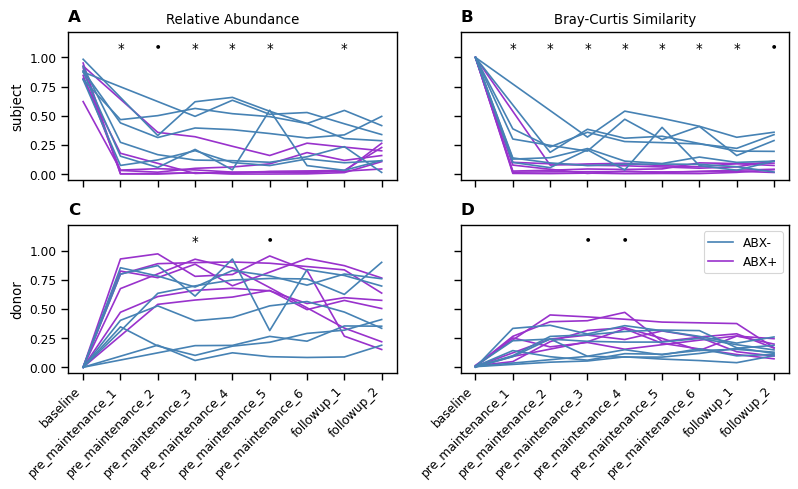

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)
pvalue_for = "antibiotics_"
colorby = "antibiotics_"
colorby_order = lib.project_style.ANTIBIOTICS_ORDER
colorby_pallete = lib.project_style.DEFAULT_COLOR_PALETTE

for (score, (score_title, d0)), ax_col, panel_col in zip(
    dict(
        taxon_class_rabund=("Relative Abundance", sotu_taxon_class_rabund),
        braycurtis=("Bray-Curtis Similarity", 1 - sotu_braycurtis),
    ).items(),
    axs.T,
    [["A", "C"], ["B", "D"]],
):
    d1 = (
        d0.join(sample)
        .join(subject, on="subject_id")
        .join(lib.project_style.SAMPLE_TYPE_INDEX.rename("x"), on="sample_type")
    )
    ax_col[0].set_title(score_title)
    for taxon_class, ax, panel in zip(
        lib.engraftment.TAXON_CLASS_ORDER, ax_col, panel_col
    ):
        for colorby_feat, d2 in d1.groupby(colorby):
            for subject_id, d3 in d2.groupby("subject_id"):
                if taxon_class not in d3:
                    ax.set_visible(False)
                    continue
                ax.plot(
                    "x",
                    taxon_class,
                    data=d3.sort_values("x"),
                    color=lib.project_style.DEFAULT_COLOR_PALETTE[colorby_feat],
                    label="__nolegend__",
                )
        for sample_type, x in lib.project_style.SAMPLE_TYPE_INDEX.to_dict().items():
            try:
                annotation = lib.project_style.pvalue_to_annotation(
                    sotu_taxon_class_pvalues[(pvalue_for, taxon_class, score, sample_type)]
                )
                if annotation == "∙":
                    y = 1.101
                elif annotation == "**":
                    y = 1.08
                elif annotation == "*":
                    y = 1.08
                elif annotation == "":
                    y = 1.08
                ax.annotate(annotation, xy=(x, y), ha="center", va="center")
            except KeyError:
                continue
        ax.text(
            -0.0, 1.07, panel, fontsize=12, fontweight="heavy", transform=ax.transAxes
        )
    ax.set_xticks(
        lib.project_style.SAMPLE_TYPE_INDEX,
    )
    ax.set_xticklabels(lib.project_style.SAMPLE_TYPE_INDEX.index)
    lib.plot.rotate_xticklabels(ax=ax)
    ax.set_ylim(-0.05, 1.22)

for taxon_class, ax in zip(lib.engraftment.TAXON_CLASS_ORDER, axs[:, 0]):
    ax.set_ylabel(taxon_class)

ax = axs[1, 1]
for colorby_feat in colorby_order:
    ax.plot([], [], color=colorby_pallete[colorby_feat], label=colorby_feat)
ax.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()
# fig.savefig('fig/engraftment_profile_antibiotics.png', dpi=250, bbox_inches='tight')
# fig.savefig('fig/engraftment_profile_antibiotics.pdf', dpi=250, bbox_inches='tight')

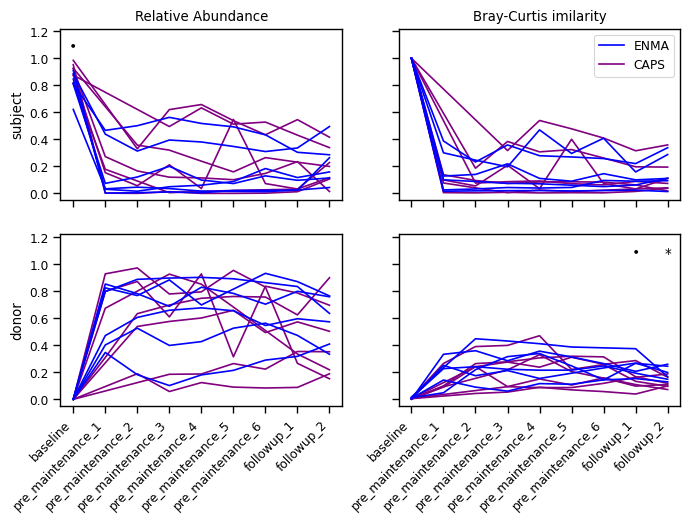

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)
pvalue_for = "maintenance_"
colorby = "maintenance_"
colorby_order = lib.project_style.MAINTENANCE_ORDER
colorby_pallete = lib.project_style.DEFAULT_COLOR_PALETTE

for (score, (score_title, d0)), ax_col in zip(
    dict(
        taxon_class_rabund=("Relative Abundance", sotu_taxon_class_rabund),
        braycurtis=("Bray-Curtis imilarity", 1 - sotu_braycurtis),
    ).items(),
    axs.T,
):
    d1 = (
        d0.join(sample)
        .join(subject, on="subject_id")
        .join(lib.project_style.SAMPLE_TYPE_INDEX.rename("x"), on="sample_type")
    )
    ax_col[0].set_title(score_title)
    for taxon_class, ax in zip(lib.engraftment.TAXON_CLASS_ORDER, ax_col):
        for colorby_feat, d2 in d1.groupby(colorby):
            for subject_id, d3 in d2.groupby("subject_id"):
                if taxon_class not in d3:
                    ax.set_visible(False)
                    continue
                ax.plot(
                    "x",
                    taxon_class,
                    data=d3.sort_values("x"),
                    color=lib.project_style.DEFAULT_COLOR_PALETTE[colorby_feat],
                    label="__nolegend__",
                )
        for sample_type, x in lib.project_style.SAMPLE_TYPE_INDEX.to_dict().items():
            try:
                annotation = lib.project_style.pvalue_to_annotation(
                    sotu_taxon_class_pvalues[(pvalue_for, taxon_class, score, sample_type)]
                )
                if annotation == "∙":
                    y = 1.101
                elif annotation == "**":
                    y = 1.08
                elif annotation == "*":
                    y = 1.08
                elif annotation == "":
                    y = 1.08
                ax.annotate(annotation, xy=(x, y), ha="center", va="center")
            except KeyError:
                continue
    ax.set_xticks(
        lib.project_style.SAMPLE_TYPE_INDEX,
    )
    ax.set_xticklabels(lib.project_style.SAMPLE_TYPE_INDEX.index)
    lib.plot.rotate_xticklabels(ax=ax)
    ax.set_ylim(-0.05, 1.22)

for taxon_class, ax in zip(lib.engraftment.TAXON_CLASS_ORDER, axs[:, 0]):
    ax.set_ylabel(taxon_class)

ax = axs[0, -1]
for colorby_feat in colorby_order:
    ax.plot([], [], color=colorby_pallete[colorby_feat], label=colorby_feat)
ax.legend(bbox_to_anchor=(1, 1))

fig.savefig(
    "fig/engraftment_profile_maintenance_method.pdf", dpi=250, bbox_inches="tight"
)

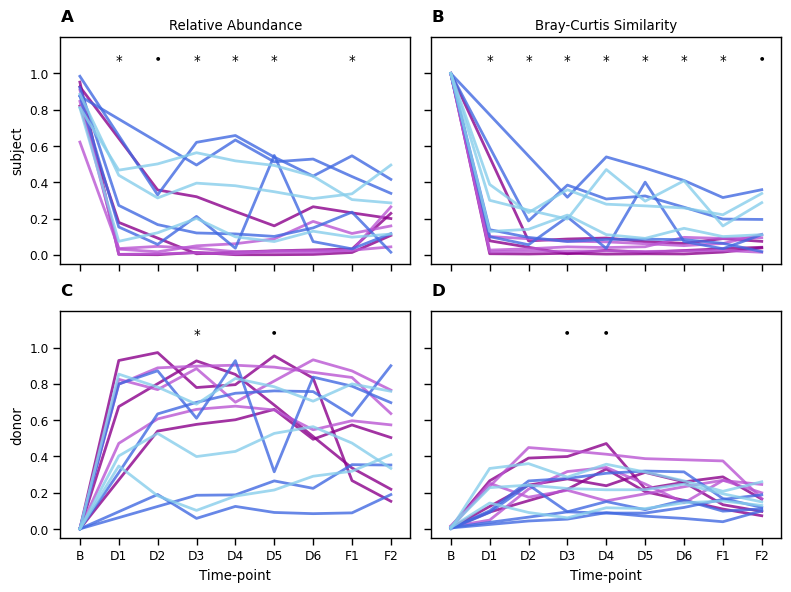

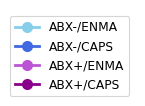

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
pvalue_for = "antibiotics_"
colorby = "arm"
colorby_order = lib.project_style.ARM_ORDER
colorby_pallete = lib.project_style.DEFAULT_COLOR_PALETTE

for (score, (score_title, d0)), ax_col, panel_col in zip(
    dict(
        taxon_class_rabund=("Relative Abundance", sotu_taxon_class_rabund),
        braycurtis=("Bray-Curtis Similarity", 1 - sotu_braycurtis),
    ).items(),
    axs.T,
    [["A", "C"], ["B", "D"]],
):
    d1 = (
        d0.join(sample)
        .join(subject, on="subject_id")
        .join(lib.project_style.SAMPLE_TYPE_INDEX.rename("x"), on="sample_type")
    )
    ax_col[0].set_title(score_title)
    for taxon_class, ax, panel in zip(
        lib.engraftment.TAXON_CLASS_ORDER, ax_col, panel_col
    ):
        for colorby_feat, d2 in d1.groupby(colorby):
            for subject_id, d3 in d2.groupby("subject_id"):
                if taxon_class not in d3:
                    ax.set_visible(False)
                    continue
                ax.plot(
                    "x",
                    taxon_class,
                    data=d3.sort_values("x"),
                    lw=2,
                    color=lib.project_style.DEFAULT_COLOR_PALETTE[colorby_feat],
                    label="__nolegend__",
                    alpha=0.8,
                )
        for sample_type, x in lib.project_style.SAMPLE_TYPE_INDEX.to_dict().items():
            try:
                annotation = lib.project_style.pvalue_to_annotation(
                    sotu_taxon_class_pvalues[(pvalue_for, taxon_class, score, sample_type)]
                )
                if annotation == "∙":
                    y = 1.09
                elif annotation == "**":
                    y = 1.073
                elif annotation == "*":
                    y = 1.073
                elif annotation == "":
                    y = 1.073
                ax.annotate(annotation, xy=(x, y), ha="center", va="center")
            except KeyError:
                continue
        ax.text(
            -0.0, 1.07, panel, fontsize=12, fontweight="heavy", transform=ax.transAxes
        )
    ax.set_xticks(lib.project_style.SAMPLE_TYPE_INDEX)
    ax.set_xticklabels(
        lib.project_style.SAMPLE_TYPE_INDEX.index.to_series().map(
            lib.project_style.SAMPLE_TYPE_LABELS
        )
    )
    #     lib.plot.rotate_xticklabels(ax=ax)
    ax.set_ylim(-0.05, 1.2)
    ax.set_xlim(-0.5, 8.5)
    ax.set_yticks(np.linspace(0, 1, num=6))
    ax.set_xlabel("Time-point")

for taxon_class, ax in zip(lib.engraftment.TAXON_CLASS_ORDER, axs[:, 0]):
    ax.set_ylabel(taxon_class)
fig.tight_layout()
fig.savefig("fig/engraftment_profiles_by_treatment.pdf", bbox_inches="tight")


# Legend
fig, ax = plt.subplots(figsize=(1, 1))
for colorby_feat in colorby_order:
    ax.plot(
        [],
        [],
        marker="o",
        markersize=8,
        markeredgecolor="none",
        lw=2,
        color=colorby_pallete[colorby_feat],
        label=colorby_feat,
    )
ax.legend()
ax.legend(ncol=1)
for spines in ["top", "right", "bottom", "left"]:
    ax.spines[spines].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig("fig/treatment_legend.pdf", bbox_inches="tight")

In [ ]:
d = sotu_taxon_class_rabund.assign(subject_any=lambda x: x.shared + x.subject)
m = sample.join(recipient, on="subject_id")
d.join(m).groupby(["sample_type"])[d.columns].median()

,donor,other_donor,other_nodonor,shared,subject,subject_any
sample_type,,,,,,
baseline,0.000001,0.000001,0.000002,0.124142,0.875854,0.999996
followup_1,0.573073,0.008348,0.107059,0.039751,0.117334,0.231476
followup_2,0.503559,0.013374,0.138167,0.065910,0.199691,0.289163
followup_3,0.375309,0.024521,0.089730,0.082067,0.428373,0.510440
post_antibiotic,0.016345,0.008508,0.439794,0.014645,0.092036,0.287428
pre_maintenance_1,0.736017,0.003868,0.077342,0.059619,0.113698,0.199914
pre_maintenance_2,0.634010,0.013747,0.068618,0.044342,0.121294,0.200998
pre_maintenance_3,0.659148,0.004945,0.066568,0.064082,0.200454,0.230168
pre_maintenance_4,0.698530,0.008971,0.061878,0.064689,0.098940,0.192335


In [ ]:
d = sotu_taxon_class_rabund.assign(subject_any=lambda x: x.shared + x.subject)
m = sample.join(recipient, on="subject_id")
d.join(m).groupby(["antibiotics_", "sample_type"])[d.columns].median()

donor   other_donor  other_nodonor  \
antibiotics_ sample_type                                                
ABX+         baseline           0.000001  8.613767e-07       0.000002   
             followup_1         0.584727  6.101573e-03       0.103991   
             followup_2         0.538584  1.046737e-02       0.127422   
             post_antibiotic    0.016345  8.507932e-03       0.439794   
             pre_maintenance_1  0.797612  4.636043e-03       0.085436   
             pre_maintenance_2  0.768067  2.675684e-03       0.015198   
             pre_maintenance_3  0.831755  3.104671e-03       0.027245   
             pre_maintenance_4  0.746950  5.601914e-03       0.048544   
             pre_maintenance_5  0.682994  3.219126e-03       0.048396   
             pre_maintenance_6  0.688694  7.245964e-03       0.075167   
ABX-         baseline           0.000001  1.180739e-06       0.000002   
             followup_1         0.473159  8.879006e-03       0.107059   
             followup_2         0.409232  1.337362e-02       0.138167   
             followup_3         0.375309  2.452114e-02       0.089730   
             pre_maintenance_1  0.402161  3.099753e-03       0.069247   
             pre_maintenance_2  0.580231  1.407375e-02       0.078773   
             pre_maintenance_3  0.398771  6.816927e-03       0.175819   
             pre_maintenance_4  0.427103  1.185157e-02       0.074513   
             pre_maintenance_5  0.314598  5.958889e-03       0.095579   
             pre_maintenance_6  0.563631  1.010409e-02       0.073038   

                                  shared   subject  subject_any  
antibiotics_ sample_type                                         
ABX+         baseline           0.121894  0.878103     0.999996  
             followup_1         0.047047  0.028298     0.071290  
             followup_2         0.066486  0.179356     0.277382  
             post_antibiotic    0.014645  0.092036     0.287428  
             pre_maintenance_1  0.059743  0.030948     0.161594  
             pre_maintenance_2  0.097352  0.016321     0.141368  
             pre_maintenance_3  0.066055  0.024230     0.139969  
             pre_maintenance_4  0.098094  0.015666     0.192204  
             pre_maintenance_5  0.038015  0.021901     0.058125  
             pre_maintenance_6  0.093186  0.098544     0.217582  
ABX-         baseline           0.124142  0.875854     0.999996  
             followup_1         0.039751  0.304288     0.383810  
             followup_2         0.019260  0.285950     0.435131  
             followup_3         0.082067  0.428373     0.510440  
             pre_maintenance_1  0.059495  0.272270     0.294273  
             pre_maintenance_2  0.036525  0.239896     0.273050  
             pre_maintenance_3  0.050291  0.395121     0.544502  
             pre_maintenance_4  0.021300  0.380733     0.503213  
             pre_maintenance_5  0.023217  0.492749     0.547414  
             pre_maintenance_6  0.017455  0.309883     0.360344

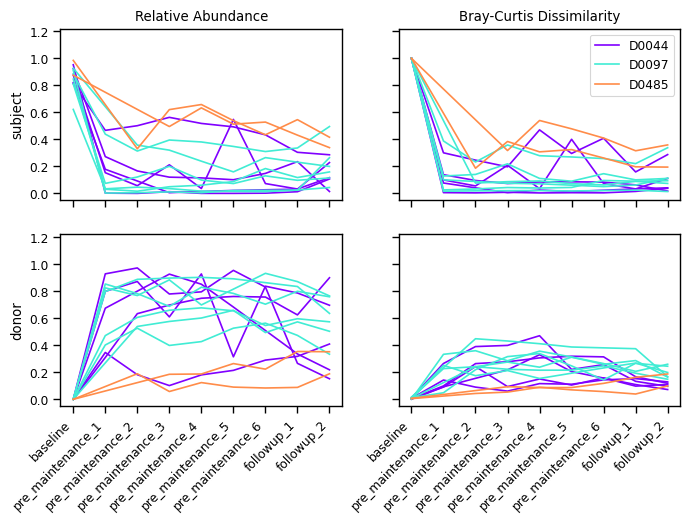

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)
pvalue_for = "donor_subject_id"
colorby = "donor_subject_id"
colorby_order = donor_order
colorby_pallete = subject_color_palette

for (score, (score_title, d0)), ax_col in zip(
    dict(
        taxon_class_rabund=("Relative Abundance", sotu_taxon_class_rabund),
        braycurtis=("Bray-Curtis Dissimilarity", 1 - sotu_braycurtis),
    ).items(),
    axs.T,
):
    d1 = (
        d0.join(sample)
        .join(subject, on="subject_id")
        .join(lib.project_style.SAMPLE_TYPE_INDEX.rename("x"), on="sample_type")
    )
    ax_col[0].set_title(score_title)
    for taxon_class, ax in zip(lib.engraftment.TAXON_CLASS_ORDER, ax_col):
        for colorby_feat, d2 in d1.groupby(colorby):
            for subject_id, d3 in d2.groupby("subject_id"):
                if taxon_class not in d3:
                    ax.set_visible(False)
                    continue
                ax.plot(
                    "x",
                    taxon_class,
                    data=d3.sort_values("x"),
                    color=colorby_pallete[colorby_feat],
                    label="__nolegend__",
                )
        for sample_type, x in lib.project_style.SAMPLE_TYPE_INDEX.to_dict().items():
            try:
                annotation = lib.project_style.pvalue_to_annotation(
                    sotu_taxon_class_pvalues[(pvalue_for, taxon_class, score, sample_type)]
                )
                if annotation == "∙":
                    y = 1.101
                elif annotation == "**":
                    y = 1.08
                elif annotation == "*":
                    y = 1.08
                elif annotation == "":
                    y = 1.08
                ax.annotate(annotation, xy=(x, y), ha="center", va="center")
            except KeyError:
                continue
    ax.set_xticks(
        lib.project_style.SAMPLE_TYPE_INDEX,
    )
    ax.set_xticklabels(lib.project_style.SAMPLE_TYPE_INDEX.index)
    lib.plot.rotate_xticklabels(ax=ax)
    ax.set_ylim(-0.05, 1.22)

for taxon_class, ax in zip(lib.engraftment.TAXON_CLASS_ORDER, axs[:, 0]):
    ax.set_ylabel(taxon_class)

ax = axs[0, -1]
for colorby_feat in colorby_order:
    ax.plot([], [], color=colorby_pallete[colorby_feat], label=colorby_feat)
ax.legend(bbox_to_anchor=(1, 1))

fig.savefig("fig/engraftment_profile_donor.pdf", dpi=250, bbox_inches="tight")

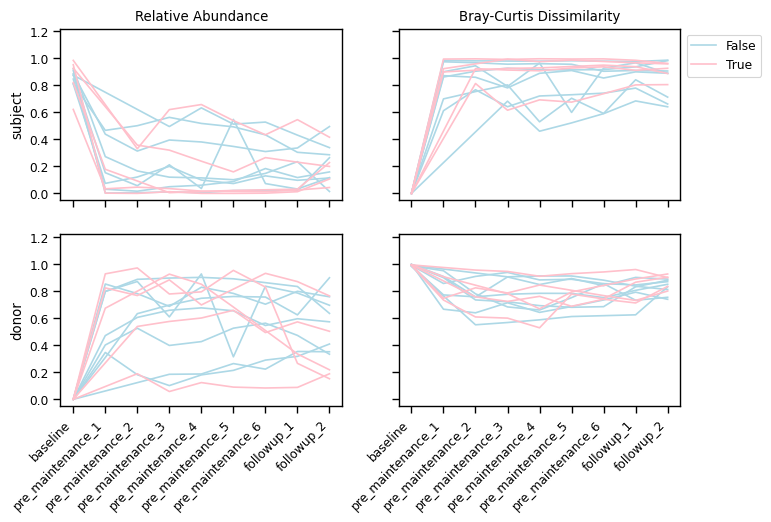

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)
pvalue_for = "remission"
colorby = "remission"
colorby_order = [False, True]
colorby_pallete = lib.project_style.DEFAULT_COLOR_PALETTE

for (score, (score_title, d0)), ax_col in zip(
    dict(
        taxon_class_rabund=("Relative Abundance", sotu_taxon_class_rabund),
        braycurtis=("Bray-Curtis Dissimilarity", sotu_braycurtis),
    ).items(),
    axs.T,
):
    d1 = (
        d0.join(sample)
        .join(subject, on="subject_id")
        .join(lib.project_style.SAMPLE_TYPE_INDEX.rename("x"), on="sample_type")
    )
    ax_col[0].set_title(score_title)
    for taxon_class, ax in zip(lib.engraftment.TAXON_CLASS_ORDER, ax_col):
        for colorby_feat, d2 in d1.groupby(colorby):
            for subject_id, d3 in d2.groupby("subject_id"):
                if taxon_class not in d3:
                    ax.set_visible(False)
                    continue
                ax.plot(
                    "x",
                    taxon_class,
                    data=d3.sort_values("x"),
                    color=lib.project_style.DEFAULT_COLOR_PALETTE[colorby_feat],
                    label="__nolegend__",
                )
        for sample_type, x in lib.project_style.SAMPLE_TYPE_INDEX.to_dict().items():
            try:
                annotation = lib.project_style.pvalue_to_annotation(
                    sotu_taxon_class_pvalues[(pvalue_for, taxon_class, score, sample_type)]
                )
                if annotation == "∙":
                    y = 1.101
                elif annotation == "**":
                    y = 1.08
                elif annotation == "*":
                    y = 1.08
                elif annotation == "":
                    y = 1.08
                ax.annotate(annotation, xy=(x, y), ha="center", va="center")
            except KeyError:
                continue
    ax.set_xticks(
        lib.project_style.SAMPLE_TYPE_INDEX,
    )
    ax.set_xticklabels(lib.project_style.SAMPLE_TYPE_INDEX.index)
    lib.plot.rotate_xticklabels(ax=ax)
    ax.set_ylim(-0.05, 1.22)

for taxon_class, ax in zip(lib.engraftment.TAXON_CLASS_ORDER, axs[:, 0]):
    ax.set_ylabel(taxon_class)

ax = axs[0, -1]
for colorby_feat in colorby_order:
    ax.plot([], [], color=colorby_pallete[colorby_feat], label=colorby_feat)
ax.legend(bbox_to_anchor=(1, 1))

### All levels combined

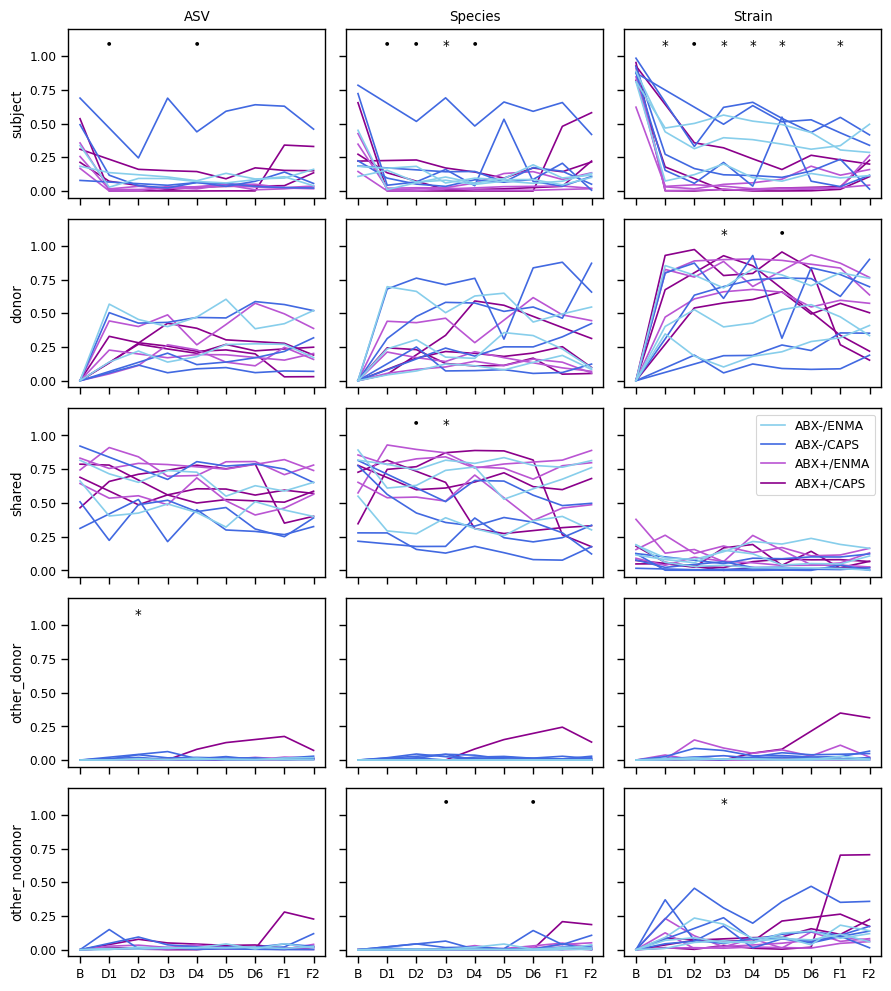

In [ ]:
# TODO: Plot all five taxon classes profiles over time-points

pvalue_for = "antibiotics_"
colorby = "arm"
colorby_order = lib.project_style.ARM_ORDER
colorby_pallete = lib.project_style.DEFAULT_COLOR_PALETTE

taxon_classification_levels = [
    (
        'ASV',
        rotu_taxon_class_rabund,
        rotu_taxon_class_pvalues,
    ),
    (
        'Species',
        motu_taxon_class_rabund,
        motu_taxon_class_pvalues,
    ),
    (
        'Strain',
        sotu_taxon_class_rabund,
        sotu_taxon_class_pvalues,
    ),
]

ncol = len(taxon_classification_levels)
nrow = len(lib.engraftment.TAXON_CLASS_ORDER)


fig, axs = plt.subplots(nrow, ncol, figsize=(3*ncol, 2*nrow), sharex=True, sharey=True)
# axs = axs.reshape((nrow, -1))


for (taxon_level_name, d0, _taxon_class_pvalues), ax_col in zip(taxon_classification_levels, axs.T):
    d1 = (
        d0.join(sample)
        .join(subject, on="subject_id")
        .join(lib.project_style.SAMPLE_TYPE_INDEX.rename("x"), on="sample_type")
    )
    ax_col[0].set_title(taxon_level_name)
    for taxon_class, ax in zip(
        lib.engraftment.TAXON_CLASS_ORDER, ax_col,
    ):
        for colorby_feat, d2 in d1.groupby(colorby):
            for subject_id, d3 in d2.groupby("subject_id"):
                # if taxon_class not in d3:
                #     ax.set_visible(False)
                #     continue
                ax.plot(
                    "x",
                    taxon_class,
                    data=d3.sort_values("x"),
                    color=lib.project_style.DEFAULT_COLOR_PALETTE[colorby_feat],
                    label="__nolegend__",
                )
        for sample_type, x in lib.project_style.SAMPLE_TYPE_INDEX.to_dict().items():
            try:
                annotation = lib.project_style.pvalue_to_annotation(
                    _taxon_class_pvalues[(pvalue_for, taxon_class, 'taxon_class_rabund', sample_type)]
                )
                if annotation == "∙":
                    y = 1.101
                elif annotation == "**":
                    y = 1.08
                elif annotation == "*":
                    y = 1.08
                elif annotation == "":
                    y = 1.08
                ax.annotate(annotation, xy=(x, y), ha="center", va="center")
            except KeyError:
                pass

        ax.set_xticks(lib.project_style.SAMPLE_TYPE_INDEX)
        ax.set_xticklabels(
            lib.project_style.SAMPLE_TYPE_INDEX.index.to_series().map(
                lib.project_style.SAMPLE_TYPE_LABELS
            )
        )

for taxon_class, ax_row in zip(lib.engraftment.TAXON_CLASS_ORDER, axs):
    ax_row[0].set_ylabel(taxon_class)
    ax_row[0].set_ylim(-0.05, 1.2)


# for taxon_class, ax in zip(lib.engraftment.TAXON_CLASS_ORDER, axs[:, 0]):
#     ax.set_ylabel(taxon_class)

ax = axs[2, 2]
for colorby_feat in colorby_order:
    ax.plot([], [], color=colorby_pallete[colorby_feat], label=colorby_feat)
ax.legend()

fig.tight_layout()
# fig.savefig('fig/engraftment_profile_antibiotics.png', dpi=250, bbox_inches='tight')
fig.savefig('doc/static/engraftment_extended_figure.svg', dpi=250, bbox_inches='tight')

In [ ]:
d0 = sotu_taxon_class_rabund.assign(other=lambda x: x.other_donor + x.other_nodonor)
d1 = (
    d0.join(sample)
    .join(subject, on="subject_id")
    .join(lib.project_style.SAMPLE_TYPE_INDEX.rename("x"), on="sample_type")
)
d2 = d1.loc[lambda x: x.sample_type == 'followup_1'].set_index('subject_id')['other']
print(d2.sort_values())
print(d2.median())
print(d2.quantile([0.9]))

subject_id
S0004    0.048893
S0013    0.090213
S0021    0.102436
S0007    0.115407
S0027    0.116531
S0055    0.124251
S0041    0.140742
S0001    0.143032
S0024    0.172143
S0056    0.185607
S0008    0.360152
S0047    0.612340
S0053    0.705289
Name: other, dtype: float64
0.14074218694141724
0.9    0.561902
Name: other, dtype: float64


In [ ]:
d0 = sotu_taxon_class_rabund
d1 = (
    d0.join(sample)
    .join(subject, on="subject_id")
    .join(lib.project_style.SAMPLE_TYPE_INDEX.rename("x"), on="sample_type")
)
d2 = d1.loc[lambda x: x.sample_type == 'followup_1'].set_index('subject_id')['other_donor']
print(d2.sort_values())
print(d2.median())

subject_id
S0004    0.001648
S0027    0.002909
S0056    0.003478
S0053    0.004127
S0013    0.005133
S0021    0.008076
S0007    0.008348
S0008    0.008879
S0055    0.024112
S0001    0.027512
S0041    0.042944
S0024    0.110069
S0047    0.348534
Name: other_donor, dtype: float64
0.008348017125288307


### Assess potential false positive rate of assigning strain "transfer" events

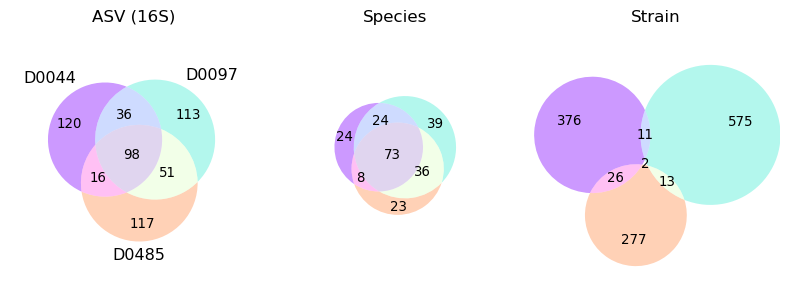

In [ ]:
# Let's build venn-diagrams of strains across the three donors' mean samples
from matplotlib_venn import venn3

thresh = 1e-4

fig, axs = plt.subplots(1, 3, figsize=(8, 4))
span = 25

venn_list = []
for (name, d), ax in zip(
    {
        "ASV (16S)": sample_x_rotu,
        "Species": sample_x_motu,
        "Strain": sample_x_sotu,
    }.items(),
    axs,
):
    d0 = (d.loc[donor_means_list] > thresh).T
    d0 = d0[d0.sum(1) >= 1]
    d0 = d0.rename(columns=lambda s: s[:-5])

    if name == "ASV (16S)":
        set_labels = d0.columns
    else:
        set_labels = None
    v = venn3(
        [set(idxwhere(d0[col])) for col in d0],
        set_labels=set_labels,
        set_colors=[subject_color_palette[col] for col in d0],
        normalize_to=d0.sum().sum(),
        ax=ax,
    )
    ax.set_title(name, fontsize=12)
    ax.set_ylim(-span, span)
    ax.set_xlim(-span, span)
    venn_list.append(v)

for v in venn_list[1:]:
    v.set_labels = None

fig.tight_layout(pad=0.98)
fig.savefig("fig/taxa_venn_diagram_donors.pdf", bbox_inches="tight")

In [ ]:
sample_x_sotu.groupby([sample.subject_id, sample.sample_type]).apply(len).loc[
    ["D0044", "D0097", "D0485"]
]

subject_id  sample_type  
D0044       donor_enema       5
            donor_initial     5
            donor_mean        1
D0097       donor_enema      25
            donor_initial     6
            donor_mean        1
D0485       donor_initial     1
            donor_mean        1
dtype: int64

### Strain transfer differs over phyla

In [ ]:
d0 = sample_x_sotu
thresh = 1e-4
baseline_sample_type = "baseline"

strain_transfer = {}
for subject_id in recipient_has_mgen_order:
    donor_subject_id = subject.loc[
        subject_id
    ].donor_subject_id  # TODO: Use incorrect donor matching to check FPs
    donor_sample_id = donor_subject_id + "_mean"

    baseline_sample_id = idxwhere(
        (sample.sample_class == baseline_sample_type)
        & (sample.subject_id == subject_id)
    )
    assert len(baseline_sample_id) == 1
    if not baseline_sample_id[0] in d0.index:
        warn(
            f"No {baseline_sample_type} sample for {subject_id}. Skipping this subject."
        )
        continue
    # TODO; if subject_id == 'S0047': skip because this person received feces from a diff donor.
    baseline_sample_id = baseline_sample_id[0]

    taxon_class = lib.engraftment.classify_taxon_sets(
        d0, baseline_sample_id, donor_sample_id, thresh=thresh
    )

    for followup_sample_type in lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE[1:]:
        followup_sample_id = idxwhere(
            (sample.sample_type == followup_sample_type)
            & (sample.subject_id == subject_id)
        )
        if not (followup_sample_id and (followup_sample_id[0] in d0.index)):
            warn(
                f"No {followup_sample_type} sample for {subject_id}. Skipping this sample."
            )
            continue
        #        assert (len(followup_sample_id) == 1)
        followup_sample_id = followup_sample_id[0]
        strain_transfer[(followup_sample_type, subject_id)] = (
            d0.loc[followup_sample_id, taxon_class == "donor"] > thresh
        ).astype(float)

subject_x_strain_transfer = pd.DataFrame(strain_transfer).rename_axis(
    columns=("sample_type", "subject_id")
)

/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/490653557.py:35: UserWarning: No pre_maintenance_2 sample for S0047. Skipping this sample.
  warn(
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/490653557.py:35: UserWarning: No pre_maintenance_6 sample for S0047. Skipping this sample.
  warn(
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/490653557.py:35: UserWarning: No pre_maintenance_5 sample for S0004. Skipping this sample.
  warn(
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/490653557.py:35: UserWarning: No pre_maintenance_6 sample for S0021. Skipping this sample.
  warn(
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/490653557.py:35: UserWarning: No pre_maintenance_1 sample for S0027. Skipping this sample.
  warn(
/var/folders/vv/8wpk7cln4lgb9qyqchjvcsmh0000gq/T/ipykernel_17922/490653557.py:35: UserWarning: No pre_maintenance_1 sample for S0007. Skipping this sample.
  warn(
/var/folders/vv/

In [ ]:
taxon_level = "p__"
sample_type = "followup_1"

opportunities = (
    (subject_x_strain_transfer.notna())
    .groupby(sotu_to_taxonomy[taxon_level])
    .sum()
    .groupby(level="sample_type", axis="columns")
    .sum()
)
transfers = (
    (subject_x_strain_transfer)
    .groupby(sotu_to_taxonomy[taxon_level])
    .sum()
    .groupby(level="sample_type", axis="columns")
    .sum()
)

d = (
    opportunities[sample_type]
    .to_frame(name="opportunities")
    .assign(transfers=transfers[sample_type])
    .assign(transfer_rate=lambda x: x.transfers / x.opportunities)
    .sort_values("transfer_rate", ascending=False)
)
d

,opportunities,transfers,transfer_rate
p__,,,
d__Bacteria;p__Desulfobacterota;,13,8.0,0.615385
d__Archaea;p__Euryarchaeota;,14,7.0,0.500000
d__Bacteria;p__Firmicutes_C;,30,13.0,0.433333
d__Bacteria;p__Bacteroidota;,1062,362.0,0.340866
d__Bacteria;p__Firmicutes;,219,71.0,0.324201
d__Bacteria;p__Actinobacteriota;,339,98.0,0.289086
d__Bacteria;p__Firmicutes_A;,4305,1138.0,0.264344
d__Bacteria;p__Proteobacteria;,110,29.0,0.263636
d__Bacteria;p__Verrucomicrobiota;,35,1.0,0.028571


In [ ]:
taxon_level = "p__"
sample_type = "followup_1"

opportunities = (
    (subject_x_strain_transfer.notna())
    .groupby(sotu_to_taxonomy[taxon_level])
    .sum()
    .groupby(level="sample_type", axis="columns")
    .sum()
)
transfers = (
    (subject_x_strain_transfer)
    .groupby(sotu_to_taxonomy[taxon_level])
    .sum()
    .groupby(level="sample_type", axis="columns")
    .sum()
)

d = (
    opportunities[sample_type]
    .to_frame(name="opportunities")
    .assign(transfers=transfers[sample_type])
    .assign(transfer_rate=lambda x: x.transfers / x.opportunities)
    .sort_values("transfer_rate", ascending=False)
)
d[d.index.str.startswith("d__Bacteria;p__Verrucomicrobiota;")].T

p__,d__Bacteria;p__Verrucomicrobiota;
opportunities,35.000000
transfers,1.000000
transfer_rate,0.028571


In [ ]:
from scipy.stats import fisher_exact

table = []
for t1, t2 in product(idxwhere(d.opportunities > 20), repeat=2):
    table.append(
        (t1, t2, fisher_exact(d.loc[[t1, t2], ["opportunities", "transfers"]])[1])
    )

print(
    pd.DataFrame(table, columns=["t1", "t2", "pvalue"])
    .set_index(["t1", "t2"])
    .pvalue.unstack()
)

t2                                 d__Bacteria;p__Actinobacteriota;  \
t1                                                                    
d__Bacteria;p__Actinobacteriota;                           1.000000   
d__Bacteria;p__Bacteroidota;                               0.228376   
d__Bacteria;p__Firmicutes;                                 0.531234   
d__Bacteria;p__Firmicutes_A;                               0.464049   
d__Bacteria;p__Firmicutes_C;                               0.257248   
d__Bacteria;p__Proteobacteria;                             0.726380   
d__Bacteria;p__Verrucomicrobiota;                          0.002486   

t2                                 d__Bacteria;p__Bacteroidota;  \
t1                                                                
d__Bacteria;p__Actinobacteriota;                       0.228376   
d__Bacteria;p__Bacteroidota;                           1.000000   
d__Bacteria;p__Firmicutes;                             0.767225   
d__Bacteria;p__Firmicutes

### Strain co-existence within species

In [ ]:
thresh = 1e-6


sample_x_motu_x_taxon_class = (
    pd.merge(
        sample[['subject_id']],
        sotu_taxon_class.unstack('subject_id').T,
        left_on='subject_id',
        right_index=True
    )
    .drop(columns='subject_id')
    .rename_axis(columns='sotu_id')
    .stack()
    .to_frame(name='taxon_class')
    .join(sample_x_sotu.stack().rename('rabund'))
    .dropna()
    [lambda x: x.rabund > thresh]
    .join(sotu_to_taxonomy.motu_id)
    .set_index(['motu_id', 'taxon_class'], append=True)
    .groupby(level=['sample_id', 'motu_id', 'taxon_class'])
    .apply(len)
    # .unstack()
)

assert sample_x_motu_x_taxon_class.index.is_unique

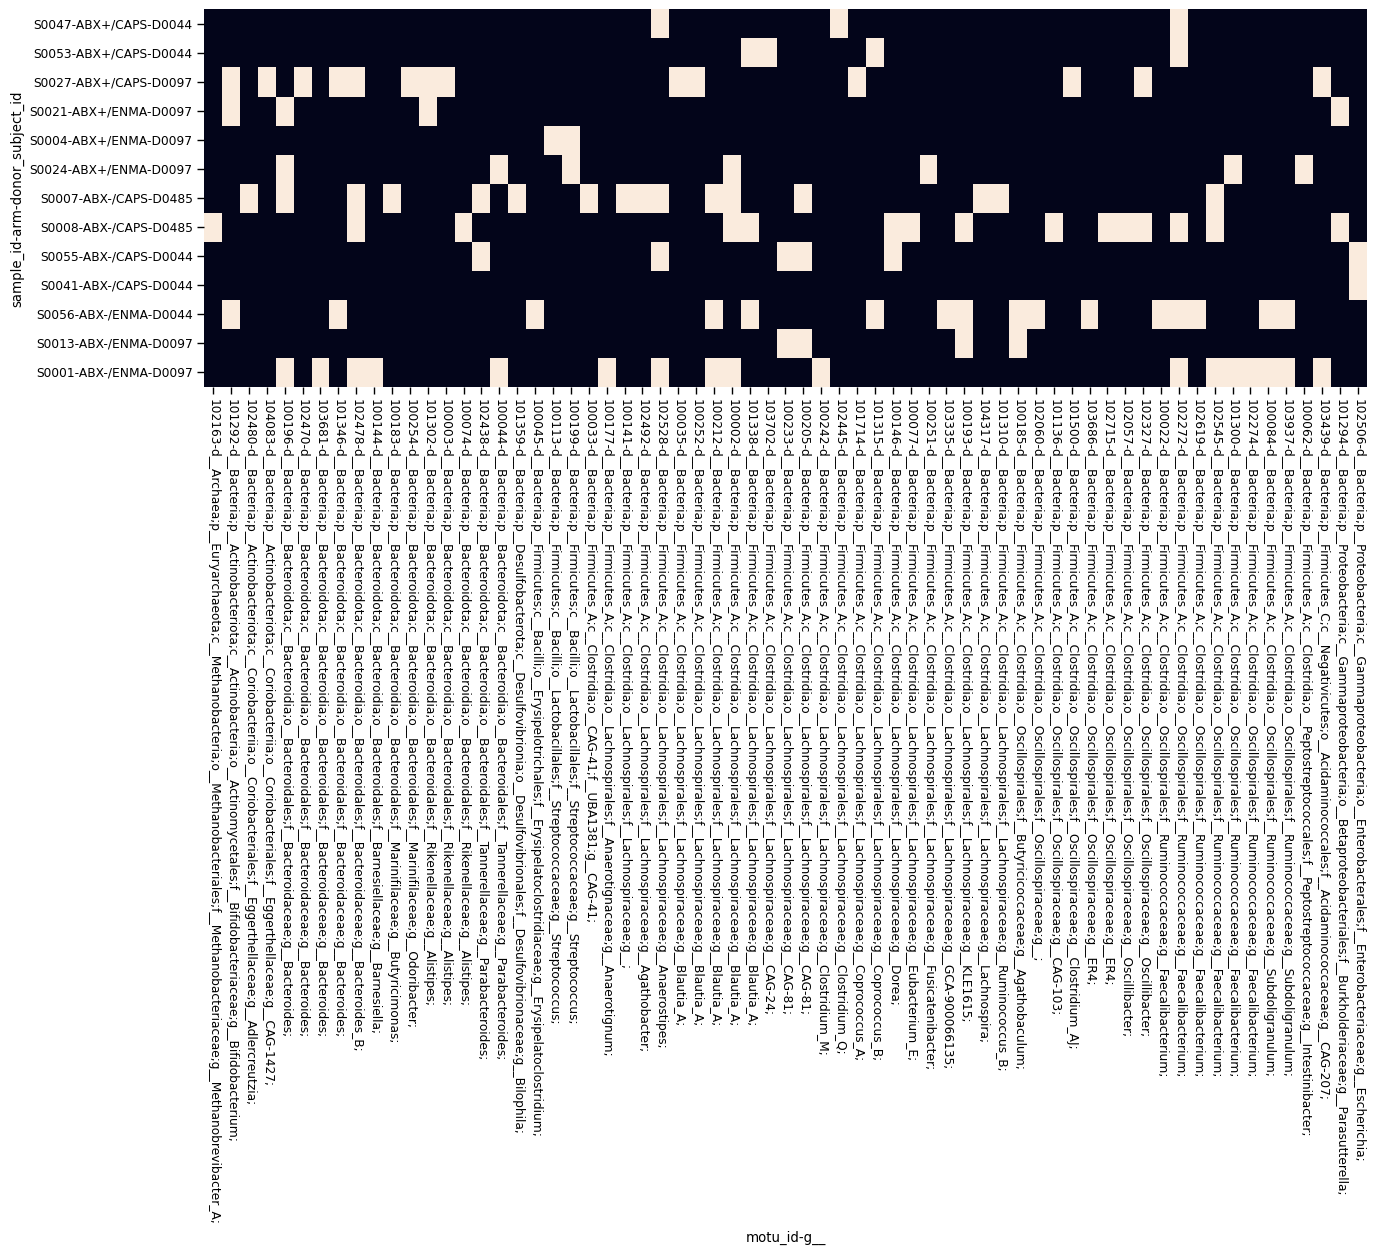

In [ ]:
donor_recipient_coexist = (
    sample_x_motu_x_taxon_class
    .unstack(fill_value=0)
    .assign(donor_recipient_coexist=lambda x: (x.donor>0) & (x.subject>0))
    .donor_recipient_coexist
    .astype(int)
    .unstack('motu_id')
    .reindex(idxwhere(sample.sample_type == 'followup_1'))
    .rename(sample.subject_id)
    .reindex(recipient_has_mgen_data_list)
    .fillna(0)
    .assign(arm=subject['arm'], donor_subject_id=subject['donor_subject_id'])
    .sort_values('arm')
    .set_index(['arm', 'donor_subject_id'], append=True)
    .T
    .assign(g__=motu_to_taxonomy['g__'])
    .sort_values('g__')
    .set_index(['g__'], append=True)
    .T
)

fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(donor_recipient_coexist.loc[:, donor_recipient_coexist.sum() > 0], xticklabels=1, yticklabels=1, ax=ax, cbar=False)#, figsize=(20, 15))
ax.set_xticklabels(ax.get_xmajorticklabels(), fontdict=dict(rotation=-90, ha='center'))

fig.savefig('doc/static/strain_coexistence_figure.svg', bbox_inches='tight')

## Subsection: Antibiotics and donors may modulate effects of FMT on the microbiome

### GEE on donor/subject similarity profiles

In [ ]:
# TODO: Figure out how to use weeks_since_intiial_fmt as a term in the covariance specification but NOT in the model.

#### Load/Shape Data

In [ ]:
# TODO: Create dataframe with either (bc-dissilarity to donor) or (fraction donor strains)
# across time for each subject.

import statsmodels.formula.api as smf
import statsmodels.genmod.cov_struct as cov_struct
import statsmodels.genmod.families as families


engraftment_gee_data = (
    sample.assign(
        donor_bc=sotu_braycurtis["donor"],
        baseline_bc=sotu_braycurtis["subject"],
        subject_rabund=sotu_taxon_class_rabund["subject"],
        donor_rabund=sotu_taxon_class_rabund["donor"],
        other_rabund=sotu_taxon_class_rabund["other_nodonor"] + sotu_taxon_class_rabund["other_donor"],
    )
    .join(subject, on="subject_id")[
        lambda x: x.sample_type.isin(lib.project_data.SAMPLE_TYPE_ORDER_SIMPLE)
        & ~x.sample_type.isin(["baseline", "post_antibiotic"])
    ]
    .assign(
        remission=lambda x: x.remission.astype(float),
        responder=lambda x: x.responder.astype(float),
        mayo_endo_improved=lambda x: x.mayo_endo_improved.astype(float),
    )
    .drop(columns=["treatment_abx_pre", "withdrawal_due_to_failure"])
    .sort_values(["subject_id", "days_post_fmt"])
    .assign(weeks_post_fmt=lambda x: x.days_post_fmt / 7)
)

In [ ]:
%%R -i engraftment_gee_data

library("geepack")

variables = c("weeks_post_fmt", "antibiotics_", "donor_subject_id", "maintenance_", "responder")
engraftment_gee_data$subject_id <- as.factor(engraftment_gee_data$subject_id)

engraftment_gee_data_dr <- engraftment_gee_data[complete.cases(engraftment_gee_data[c('donor_rabund', variables)]),]
engraftment_gee_data_sr <- engraftment_gee_data[complete.cases(engraftment_gee_data[c('subject_rabund', variables)]),]
engraftment_gee_data_db <- engraftment_gee_data[complete.cases(engraftment_gee_data[c('donor_bc', variables)]),]
engraftment_gee_data_sb <- engraftment_gee_data[complete.cases(engraftment_gee_data[c('baseline_bc', variables)]),]
engraftment_gee_data_or <- engraftment_gee_data[complete.cases(engraftment_gee_data[c('other_rabund', variables)]),]

#### Null Model

In [ ]:
%%R

# WARNING: d$subject_id (or whatever "id" is, must be sorted)

lm0_dr <- geeglm(
    donor_rabund ~ weeks_post_fmt,
    id=subject_id,
    data=engraftment_gee_data_dr,
    corstr="ar1",
    waves=engraftment_gee_data_dr$weeks_post_fmt,
)
print(summary(lm0_dr))
print(confint.geeglm(lm0_dr))
print('--------')

lm0_sr <- geeglm(
    subject_rabund ~ weeks_post_fmt,
    id=subject_id,
    data=engraftment_gee_data_sr,
    corstr="ar1",
    waves=engraftment_gee_data_dr$weeks_post_fmt
)
print(summary(lm0_sr))
print(confint.geeglm(lm0_sr))
print('--------')

lm0_db <- geeglm(
    donor_bc ~ weeks_post_fmt,
    id=subject_id,
    data=engraftment_gee_data_db,
    corstr="ar1",
    waves=engraftment_gee_data_dr$weeks_post_fmt
)
print(summary(lm0_db))
print(confint.geeglm(lm0_db))
print('--------')

lm0_sb <- geeglm(
    baseline_bc ~ weeks_post_fmt,
    id=subject_id,
    data=engraftment_gee_data_sb,
    corstr="ar1",
    waves=engraftment_gee_data_dr$weeks_post_fmt
)
print(summary(lm0_sb))
print(confint.geeglm(lm0_sb))
print('--------')

lm0_or <- geeglm(
    other_rabund ~ weeks_post_fmt,
    id=subject_id,
    data=engraftment_gee_data_sb,
    corstr="ar1",
    waves=engraftment_gee_data_dr$weeks_post_fmt
)
print(summary(lm0_sb))
print(confint.geeglm(lm0_sb))
print('--------')


Call:
geeglm(formula = donor_rabund ~ weeks_post_fmt, data = engraftment_gee_data_dr, 
    id = subject_id, waves = engraftment_gee_data_dr$weeks_post_fmt, 
    corstr = "ar1")

 Coefficients:
               Estimate  Std.err  Wald Pr(>|W|)    
(Intercept)     0.59633  0.07485 63.47  1.7e-15 ***
weeks_post_fmt -0.00715  0.00622  1.32     0.25    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = ar1 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)   0.0665  0.0143
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.973  0.0124
Number of clusters:   13  Maximum cluster size: 8 
                   lwr     upr
(Intercept)     0.4496 0.74304
weeks_post_fmt -0.0193 0.00505
[1] "--------"

Call:
geeglm(formula = subject_rabund ~ weeks_post_fmt, data = engraftment_gee_data_sr, 
    id = subject_id, waves = engraftment_gee_data_dr$weeks_post_fmt, 
    corstr = "ar1")

 Coefficients:
           

#### Antibiotics

In [ ]:
%%R

lm_abx_dr <- geeglm(
    donor_rabund ~ weeks_post_fmt + antibiotics_,
    id=subject_id,
    data=engraftment_gee_data_dr,
    corstr="ar1",
    waves=engraftment_gee_data_dr$weeks_post_fmt,
)
print(summary(lm_abx_dr))
print(confint.geeglm(lm_abx_dr))
print(anova(lm0_dr, lm_abx_dr))
print('--------')

lm_abx_sr <- geeglm(
    subject_rabund ~ weeks_post_fmt + antibiotics_,
    id=subject_id,
    data=engraftment_gee_data_sr,
    corstr="ar1",
    waves=engraftment_gee_data_sr$weeks_post_fmt
)
print(summary(lm_abx_sr))
print(confint.geeglm(lm_abx_sr))
print(anova(lm0_sr, lm_abx_sr))
print('--------')

lm_abx_db <- geeglm(
    donor_bc ~ weeks_post_fmt + antibiotics_,
    id=subject_id,
    data=engraftment_gee_data_db,
    corstr="ar1",
    waves=engraftment_gee_data_db$weeks_post_fmt
)
print(summary(lm_abx_db))
print(confint.geeglm(lm_abx_db))
print(anova(lm0_db, lm_abx_db))
print('--------')

lm_abx_sb <- geeglm(
    baseline_bc ~ weeks_post_fmt + antibiotics_,
    id=subject_id,
    data=engraftment_gee_data_sb,
    corstr="ar1",
    waves=engraftment_gee_data_db$weeks_post_fmt
)
print(summary(lm_abx_sb))
print(confint.geeglm(lm_abx_sb))
print(anova(lm0_sb, lm_abx_sb))
print('--------')


lm_abx_or <- geeglm(
    other_rabund ~ weeks_post_fmt + antibiotics_,
    id=subject_id,
    data=engraftment_gee_data_sb,
    corstr="ar1",
    waves=engraftment_gee_data_db$weeks_post_fmt
)
print(summary(lm_abx_or))
print(confint.geeglm(lm_abx_or))
print(anova(lm0_or, lm_abx_or))
print('--------')


Call:
geeglm(formula = donor_rabund ~ weeks_post_fmt + antibiotics_, 
    data = engraftment_gee_data_dr, id = subject_id, waves = engraftment_gee_data_dr$weeks_post_fmt, 
    corstr = "ar1")

 Coefficients:
                 Estimate Std.err  Wald Pr(>|W|)    
(Intercept)        0.6801  0.1382 24.20  8.7e-07 ***
weeks_post_fmt    -0.0434  0.0183  5.59    0.018 *  
antibiotics_ABX+   0.2632  0.1077  5.98    0.015 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = ar1 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)   0.0718  0.0199
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha      1.2  0.0111
Number of clusters:   13  Maximum cluster size: 8 
                     lwr      upr
(Intercept)       0.4091  0.95101
weeks_post_fmt   -0.0793 -0.00743
antibiotics_ABX+  0.0522  0.47423
Analysis of 'Wald statistic' Table

Model 1 donor_rabund ~ weeks_post_fmt + antibiotics_ 
Model 2 donor_rabu

#### Maintenance Delivery

In [ ]:
%%R

lm_mnt_dr <- geeglm(
    donor_rabund ~ weeks_post_fmt + maintenance_,
    id=subject_id,
    data=engraftment_gee_data_dr,
    corstr="ar1",
    waves=engraftment_gee_data_dr$weeks_post_fmt,
)
print(summary(lm_mnt_dr))
print(confint.geeglm(lm_mnt_dr))
print(anova(lm0_dr, lm_mnt_dr))
# print(aov(lm_mnt_dr))
print('--------')

lm_mnt_sr <- geeglm(
    subject_rabund ~ weeks_post_fmt + maintenance_,
    id=subject_id,
    data=engraftment_gee_data_sr,
    corstr="ar1",
    waves=engraftment_gee_data_sr$weeks_post_fmt
)
print(summary(lm_mnt_sr))
print(confint.geeglm(lm_mnt_sr))
print(anova(lm0_sr, lm_mnt_sr))
print('--------')

lm_mnt_db <- geeglm(
    donor_bc ~ weeks_post_fmt + maintenance_,
    id=subject_id,
    data=engraftment_gee_data_db,
    corstr="ar1",
    waves=engraftment_gee_data_db$weeks_post_fmt
)
print(summary(lm_mnt_db))
print(confint.geeglm(lm_mnt_db))
print(anova(lm0_db, lm_mnt_db))
print('--------')

lm_mnt_sb <- geeglm(
    baseline_bc ~ weeks_post_fmt + maintenance_,
    id=subject_id,
    data=engraftment_gee_data_sb,
    corstr="ar1",
    waves=engraftment_gee_data_db$weeks_post_fmt
)
print(summary(lm_mnt_sb))
print(confint.geeglm(lm_mnt_sb))
print(anova(lm0_sb, lm_mnt_sb))
print('--------')


Call:
geeglm(formula = donor_rabund ~ weeks_post_fmt + maintenance_, 
    data = engraftment_gee_data_dr, id = subject_id, waves = engraftment_gee_data_dr$weeks_post_fmt, 
    corstr = "ar1")

 Coefficients:
                 Estimate  Std.err  Wald Pr(>|W|)    
(Intercept)       0.54242  0.08806 37.94  7.3e-10 ***
weeks_post_fmt   -0.00695  0.00621  1.25     0.26    
maintenance_ENMA  0.11274  0.10502  1.15     0.28    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = ar1 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)   0.0657  0.0137
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.974  0.0122
Number of clusters:   13  Maximum cluster size: 8 
                     lwr     upr
(Intercept)       0.3698 0.71501
weeks_post_fmt   -0.0191 0.00523
maintenance_ENMA -0.0931 0.31857
Analysis of 'Wald statistic' Table

Model 1 donor_rabund ~ weeks_post_fmt + maintenance_ 
Model 2 donor_rabu

#### Donor Subject ID

In [ ]:
%%R

lm_dnr_dr <- geeglm(
    donor_rabund ~ weeks_post_fmt + donor_subject_id,
    id=subject_id,
    data=engraftment_gee_data_dr,
    corstr="ar1",
    waves=engraftment_gee_data_dr$weeks_post_fmt,
)
print(summary(lm_dnr_dr))
print(confint.geeglm(lm_dnr_dr))
print(anova(lm0_dr, lm_dnr_dr))
# print(aov(lm_dnr_dr))
print('--------')

lm_dnr_sr <- geeglm(
    subject_rabund ~ weeks_post_fmt + donor_subject_id,
    id=subject_id,
    data=engraftment_gee_data_sr,
    corstr="ar1",
    waves=engraftment_gee_data_sr$weeks_post_fmt
)
print(summary(lm_dnr_sr))
print(confint.geeglm(lm_dnr_sr))
print(anova(lm0_sr, lm_dnr_sr))
print('--------')

lm_dnr_db <- geeglm(
    donor_bc ~ weeks_post_fmt + donor_subject_id,
    id=subject_id,
    data=engraftment_gee_data_db,
    corstr="ar1",
    waves=engraftment_gee_data_db$weeks_post_fmt
)
print(summary(lm_dnr_db))
print(confint.geeglm(lm_dnr_db))
print(anova(lm0_db, lm_dnr_db))
print('--------')

lm_dnr_sb <- geeglm(
    baseline_bc ~ weeks_post_fmt + donor_subject_id,
    id=subject_id,
    data=engraftment_gee_data_sb,
    corstr="ar1",
    waves=engraftment_gee_data_db$weeks_post_fmt
)
print(summary(lm_dnr_sb))
print(confint.geeglm(lm_dnr_sb))
print(anova(lm0_sb, lm_dnr_sb))
print('--------')


Call:
geeglm(formula = donor_rabund ~ weeks_post_fmt + donor_subject_id, 
    data = engraftment_gee_data_dr, id = subject_id, waves = engraftment_gee_data_dr$weeks_post_fmt, 
    corstr = "ar1")

 Coefficients:
                      Estimate  Std.err  Wald Pr(>|W|)    
(Intercept)            0.60708  0.07856 59.71  1.1e-14 ***
weeks_post_fmt        -0.00688  0.00640  1.16     0.28    
donor_subject_idD0097  0.08970  0.08787  1.04     0.31    
donor_subject_idD0485 -0.34602  0.07343 22.20  2.5e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = ar1 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)   0.0423  0.0095
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.958  0.0207
Number of clusters:   13  Maximum cluster size: 8 
                          lwr      upr
(Intercept)            0.4531  0.76107
weeks_post_fmt        -0.0194  0.00566
donor_subject_idD0097 -0.0825  0.26192
d

#### Antibiotics compared to alternative null

In [ ]:
%%R

lm_abx_dnr_dr <- geeglm(
    donor_rabund ~ weeks_post_fmt + antibiotics_ + donor_subject_id,
    id=subject_id,
    data=engraftment_gee_data_dr,
    corstr="ar1",
    waves=engraftment_gee_data_dr$weeks_post_fmt,
)
print(summary(lm_abx_dnr_dr))
print(confint.geeglm(lm_abx_dnr_dr))
print(anova(lm_dnr_dr, lm_abx_dnr_dr))
# print(aov(lm_abx_dnr_dr))
print('--------')

lm_abx_dnr_sr <- geeglm(
    subject_rabund ~ weeks_post_fmt + antibiotics_ + donor_subject_id,
    id=subject_id,
    data=engraftment_gee_data_sr,
    corstr="ar1",
    waves=engraftment_gee_data_sr$weeks_post_fmt
)
print(summary(lm_abx_dnr_sr))
print(confint.geeglm(lm_abx_dnr_sr))
print(anova(lm_dnr_sr, lm_abx_dnr_sr))
print('--------')

lm_abx_dnr_db <- geeglm(
    donor_bc ~ weeks_post_fmt + antibiotics_ + donor_subject_id,
    id=subject_id,
    data=engraftment_gee_data_db,
    corstr="ar1",
    waves=engraftment_gee_data_db$weeks_post_fmt
)
print(summary(lm_abx_dnr_db))
print(confint.geeglm(lm_abx_dnr_db))
print(anova(lm_dnr_db, lm_abx_dnr_db))
print('--------')

lm_abx_dnr_sb <- geeglm(
    baseline_bc ~ weeks_post_fmt + antibiotics_ + donor_subject_id,
    id=subject_id,
    data=engraftment_gee_data_sb,
    corstr="ar1",
    waves=engraftment_gee_data_db$weeks_post_fmt
)
print(summary(lm_abx_dnr_sb))
print(confint.geeglm(lm_abx_dnr_sb))
print(anova(lm_dnr_sb, lm_abx_dnr_sb))
print('--------')


Call:
geeglm(formula = donor_rabund ~ weeks_post_fmt + antibiotics_ + 
    donor_subject_id, data = engraftment_gee_data_dr, id = subject_id, 
    waves = engraftment_gee_data_dr$weeks_post_fmt, corstr = "ar1")

 Coefficients:
                      Estimate  Std.err  Wald Pr(>|W|)    
(Intercept)            0.59117  0.09525 38.52  5.4e-10 ***
weeks_post_fmt        -0.00658  0.00643  1.05  0.30589    
antibiotics_ABX+       0.02600  0.09375  0.08  0.78154    
donor_subject_idD0097  0.07990  0.08762  0.83  0.36187    
donor_subject_idD0485 -0.32541  0.09744 11.15  0.00084 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = ar1 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)   0.0417 0.00805
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.959  0.0192
Number of clusters:   13  Maximum cluster size: 8 
                          lwr      upr
(Intercept)            0.4045  0.77786
weeks

#### Maintenance method compared to alternative null

In [ ]:
%%R

lm_mnt_dnr_dr <- geeglm(
    donor_rabund ~ weeks_post_fmt + maintenance_ + donor_subject_id,
    id=subject_id,
    data=engraftment_gee_data_dr,
    corstr="ar1",
    waves=engraftment_gee_data_dr$weeks_post_fmt,
)
print(summary(lm_mnt_dnr_dr))
print(confint.geeglm(lm_mnt_dnr_dr))
print(anova(lm_dnr_dr, lm_mnt_dnr_dr))
# print(aov(lm_mnt_dnr_dr))
print('--------')

lm_mnt_dnr_sr <- geeglm(
    subject_rabund ~ weeks_post_fmt + maintenance_ + donor_subject_id,
    id=subject_id,
    data=engraftment_gee_data_sr,
    corstr="ar1",
    waves=engraftment_gee_data_sr$weeks_post_fmt
)
print(summary(lm_mnt_dnr_sr))
print(confint.geeglm(lm_mnt_dnr_sr))
print(anova(lm_dnr_sr, lm_mnt_dnr_sr))
print('--------')

lm_mnt_dnr_db <- geeglm(
    donor_bc ~ weeks_post_fmt + maintenance_ + donor_subject_id,
    id=subject_id,
    data=engraftment_gee_data_db,
    corstr="ar1",
    waves=engraftment_gee_data_db$weeks_post_fmt
)
print(summary(lm_mnt_dnr_db))
print(confint.geeglm(lm_mnt_dnr_db))
print(anova(lm_dnr_db, lm_mnt_dnr_db))
print('--------')

lm_mnt_dnr_sb <- geeglm(
    baseline_bc ~ weeks_post_fmt + maintenance_ + donor_subject_id,
    id=subject_id,
    data=engraftment_gee_data_sb,
    corstr="ar1",
    waves=engraftment_gee_data_db$weeks_post_fmt
)
print(summary(lm_mnt_dnr_sb))
print(confint.geeglm(lm_mnt_dnr_sb))
print(anova(lm_dnr_sb, lm_mnt_dnr_sb))
print('--------')


Call:
geeglm(formula = donor_rabund ~ weeks_post_fmt + maintenance_ + 
    donor_subject_id, data = engraftment_gee_data_dr, id = subject_id, 
    waves = engraftment_gee_data_dr$weeks_post_fmt, corstr = "ar1")

 Coefficients:
                      Estimate  Std.err   Wald Pr(>|W|)    
(Intercept)            0.62832  0.06041 108.17  < 2e-16 ***
weeks_post_fmt        -0.00708  0.00643   1.21     0.27    
maintenance_ENMA      -0.09407  0.13586   0.48     0.49    
donor_subject_idD0097  0.15015  0.13623   1.21     0.27    
donor_subject_idD0485 -0.36778  0.06119  36.13  1.8e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = ar1 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)   0.0395 0.00579
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.952  0.0213
Number of clusters:   13  Maximum cluster size: 8 
                          lwr      upr
(Intercept)            0.5099  0.74672

#### Responder Status

In [ ]:
%%R

lm_rsp_dr <- geeglm(
    donor_rabund ~ weeks_post_fmt + responder,
    id=subject_id,
    data=engraftment_gee_data_dr,
    corstr="ar1",
    waves=engraftment_gee_data_dr$weeks_post_fmt,
)
print(summary(lm_rsp_dr))
print(confint.geeglm(lm_rsp_dr))
print(anova(lm0_dr, lm_rsp_dr))
# print(aov(lm_rsp_dr))
print('--------')

lm_rsp_sr <- geeglm(
    subject_rabund ~ weeks_post_fmt + responder,
    id=subject_id,
    data=engraftment_gee_data_sr,
    corstr="ar1",
    waves=engraftment_gee_data_sr$weeks_post_fmt
)
print(summary(lm_rsp_sr))
print(confint.geeglm(lm_rsp_sr))
print(anova(lm0_sr, lm_rsp_sr))
print('--------')

lm_rsp_db <- geeglm(
    donor_bc ~ weeks_post_fmt + responder,
    id=subject_id,
    data=engraftment_gee_data_db,
    corstr="ar1",
    waves=engraftment_gee_data_db$weeks_post_fmt
)
print(summary(lm_rsp_db))
print(confint.geeglm(lm_rsp_db))
print(anova(lm0_db, lm_rsp_db))
print('--------')

lm_rsp_sb <- geeglm(
    baseline_bc ~ weeks_post_fmt + responder,
    id=subject_id,
    data=engraftment_gee_data_sb,
    corstr="ar1",
    waves=engraftment_gee_data_db$weeks_post_fmt
)
print(summary(lm_rsp_sb))
print(confint.geeglm(lm_rsp_sb))
print(anova(lm0_sb, lm_rsp_sb))
print('--------')


Call:
geeglm(formula = donor_rabund ~ weeks_post_fmt + responder, data = engraftment_gee_data_dr, 
    id = subject_id, waves = engraftment_gee_data_dr$weeks_post_fmt, 
    corstr = "ar1")

 Coefficients:
               Estimate  Std.err  Wald Pr(>|W|)    
(Intercept)     0.63378  0.09020 49.37  2.1e-12 ***
weeks_post_fmt -0.00707  0.00624  1.28     0.26    
responder      -0.08103  0.10688  0.57     0.45    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation structure = ar1 
Estimated Scale Parameters:

            Estimate Std.err
(Intercept)   0.0661  0.0142
  Link = identity 

Estimated Correlation Parameters:
      Estimate Std.err
alpha    0.972  0.0125
Number of clusters:   13  Maximum cluster size: 8 
                   lwr     upr
(Intercept)     0.4570 0.81056
weeks_post_fmt -0.0193 0.00516
responder      -0.2905 0.12845
Analysis of 'Wald statistic' Table

Model 1 donor_rabund ~ weeks_post_fmt + responder 
Model 2 donor_rabund ~ weeks_post_fmt
  

### Fraction of donor strains transferred as a function of treatment

In [ ]:
subject_x_strain_transfer.stack("sample_type")

subject_id                     S0001  S0004  S0007  S0008  S0013  S0021  \
sotu_id     sample_type                                                   
100002-s001 followup_1           NaN    1.0    NaN    NaN    0.0    1.0   
            followup_2           NaN    1.0    NaN    NaN    0.0    0.0   
            pre_maintenance_1    NaN    1.0    NaN    NaN    0.0    0.0   
            pre_maintenance_2    NaN    0.0    NaN    NaN    0.0    1.0   
            pre_maintenance_3    NaN    1.0    NaN    NaN    0.0    1.0   
...                              ...    ...    ...    ...    ...    ...   
104593-s020 pre_maintenance_2    NaN    NaN    NaN    0.0    NaN    NaN   
            pre_maintenance_3    NaN    NaN    0.0    0.0    NaN    NaN   
            pre_maintenance_4    NaN    NaN    0.0    0.0    NaN    NaN   
            pre_maintenance_5    NaN    NaN    0.0    0.0    NaN    NaN   
            pre_maintenance_6    NaN    NaN    0.0    0.0    NaN    NaN   

subject_id                     S0024  S0027  S0041  S0047  S0053  S0055  S0056  
sotu_id     sample_type                                                         
100002-s001 followup_1           0.0    1.0    NaN    NaN    NaN    NaN    NaN  
            followup_2           0.0    1.0    NaN    NaN    NaN    NaN    NaN  
            pre_maintenance_1    0.0    NaN    NaN    NaN    NaN    NaN    NaN  
            pre_maintenance_2    0.0    1.0    NaN    NaN    NaN    NaN    NaN  
            pre_maintenance_3    0.0    1.0    NaN    NaN    NaN    NaN    NaN  
...                              ...    ...    ...    ...    ...    ...    ...  
104593-s020 pre_maintenance_2    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
            pre_maintenance_3    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
            pre_maintenance_4    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
            pre_maintenance_5    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
            pre_maintenance_6    NaN    NaN    NaN    NaN    NaN    NaN    NaN  

[9956 rows x 13 columns]

d__
d__Bacteria;    (0.7619047619047619, 0.13752913752913754)
dtype: object


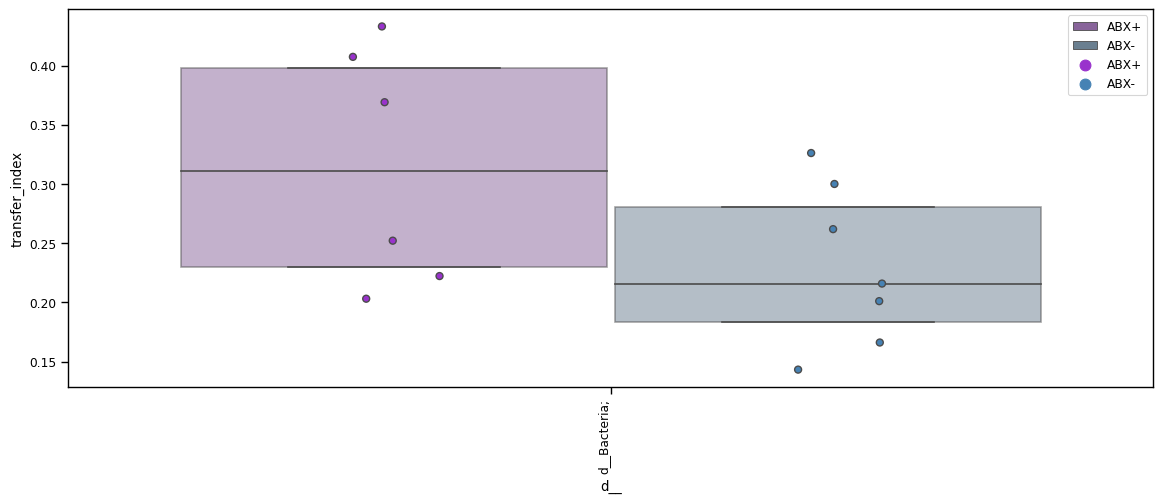

In [ ]:
taxon_level = "d__"
taxon_order = ["d__Bacteria;"]
comparison = "antibiotics_"
sample_type = "followup_1"

opportunities = (
    (subject_x_strain_transfer.notna()).groupby(sotu_to_taxonomy[taxon_level]).sum()
)
transfers = (subject_x_strain_transfer).groupby(sotu_to_taxonomy[taxon_level]).sum()
no_transfers = opportunities - transfers
d = (
    (transfers / opportunities)
    .unstack()
    .rename("transfer_index")
    .reset_index()
    .rename(columns={"level_1": "subject_id", "level_0": "sample_type"})
    .join(subject, on="subject_id")
    .sort_values(taxon_level)[lambda x: x.sample_type == sample_type]
)

fig, ax = plt.subplots(figsize=(14, 5))
lib.plot.boxplot_with_points(
    y="transfer_index",
    x=taxon_level,
    hue=comparison,
    palette=lib.project_style.DEFAULT_COLOR_PALETTE,
    order=taxon_order,
    data=d,
    ax=ax,
    dodge=True,
    dist_kwargs={"boxprops": {"alpha": 0.5}},
)
lib.plot.rotate_xticklabels(ax, rotation=90)
ax.legend(bbox_to_anchor=(1, 1))

print(
    d[lambda x: x[taxon_level].isin(taxon_order)]
    .groupby(taxon_level)
    .apply(
        lambda d: lib.stats.mannwhitneyu(
            comparison, "transfer_index", data=d, na_action="drop"
        )
    )
    .loc[taxon_order]
)

d__
d__Bacteria;    (0.7619047619047619, 0.13752913752913754)
dtype: object


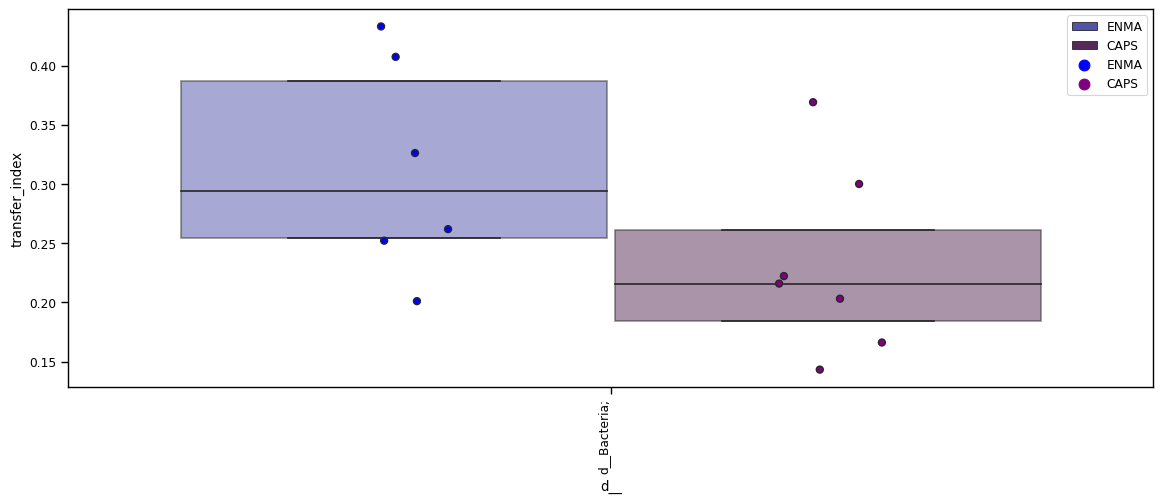

In [ ]:
taxon_level = "d__"
taxon_order = ["d__Bacteria;"]
comparison = "maintenance_"
sample_type = "followup_1"

opportunities = (
    (subject_x_strain_transfer.notna()).groupby(sotu_to_taxonomy[taxon_level]).sum()
)
transfers = (subject_x_strain_transfer).groupby(sotu_to_taxonomy[taxon_level]).sum()
no_transfers = opportunities - transfers
d = (
    (transfers / opportunities)
    .unstack()
    .rename("transfer_index")
    .reset_index()
    .rename(columns={"level_1": "subject_id", "level_0": "sample_type"})
    .join(subject, on="subject_id")
    .sort_values(taxon_level)[lambda x: x.sample_type == sample_type]
)

fig, ax = plt.subplots(figsize=(14, 5))
lib.plot.boxplot_with_points(
    y="transfer_index",
    x=taxon_level,
    hue=comparison,
    palette=lib.project_style.DEFAULT_COLOR_PALETTE,
    order=taxon_order,
    data=d,
    ax=ax,
    dodge=True,
    dist_kwargs={"boxprops": {"alpha": 0.5}},
)
lib.plot.rotate_xticklabels(ax, rotation=90)
ax.legend(bbox_to_anchor=(1, 1))

print(
    d[lambda x: x[taxon_level].isin(taxon_order)]
    .groupby(taxon_level)
    .apply(
        lambda d: lib.stats.mannwhitneyu(
            comparison, "transfer_index", data=d, na_action="drop"
        )
    )
    .loc[taxon_order]
)

d__
d__Bacteria;    (0.8333333333333334, 0.08225108225108226)
dtype: object


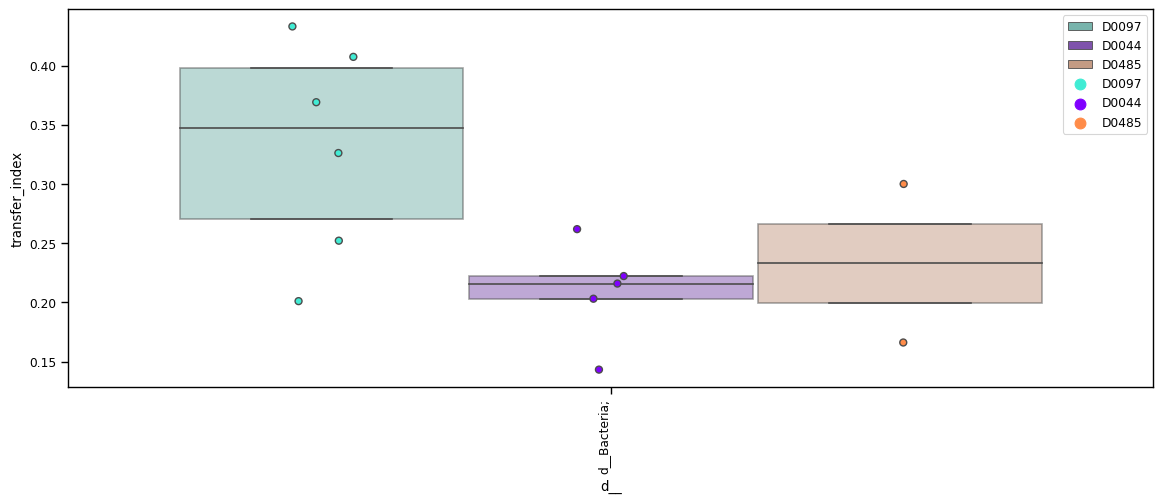

In [ ]:
taxon_level = "d__"
taxon_order = ["d__Bacteria;"]
comparison = "donor_subject_id"
sample_type = "followup_1"
pallete = subject_color_palette


opportunities = (
    (subject_x_strain_transfer.notna()).groupby(sotu_to_taxonomy[taxon_level]).sum()
)
transfers = (subject_x_strain_transfer).groupby(sotu_to_taxonomy[taxon_level]).sum()
no_transfers = opportunities - transfers
d = (
    (transfers / opportunities)
    .unstack()
    .rename("transfer_index")
    .reset_index()
    .rename(columns={"level_1": "subject_id", "level_0": "sample_type"})
    .join(subject, on="subject_id")
    .sort_values(taxon_level)[lambda x: x.sample_type == sample_type]
)

fig, ax = plt.subplots(figsize=(14, 5))
lib.plot.boxplot_with_points(
    y="transfer_index",
    x=taxon_level,
    hue=comparison,
    palette=pallete,
    order=taxon_order,
    data=d,
    ax=ax,
    dodge=True,
    dist_kwargs={"boxprops": {"alpha": 0.5}},
)
lib.plot.rotate_xticklabels(ax, rotation=90)
ax.legend(bbox_to_anchor=(1, 1))

print(
    d[lambda x: x[taxon_level].isin(taxon_order)]
    .groupby(taxon_level)
    .apply(
        lambda d: lib.stats.mannwhitneyu(
            comparison,
            "transfer_index",
            data=d[d.donor_subject_id.isin(["D0044", "D0097"])],
            na_action="drop",
        )
    )
    .loc[taxon_order]
)

d__
d__Bacteria;    (0.7142857142857143, 0.23426573426573427)
dtype: object


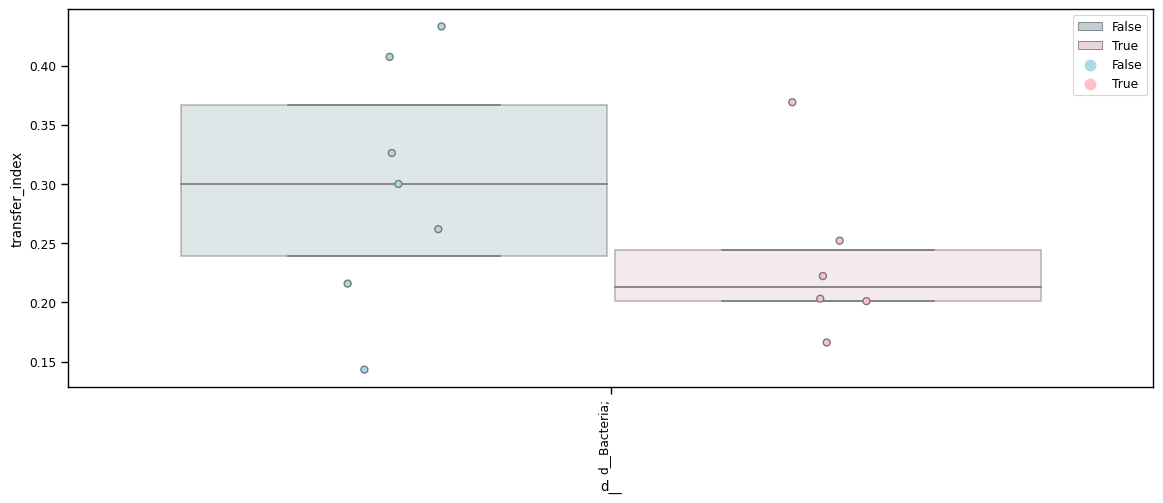

In [ ]:
taxon_level = "d__"
taxon_order = ["d__Bacteria;"]
comparison = "responder"
sample_type = "followup_1"

opportunities = (
    (subject_x_strain_transfer.notna()).groupby(sotu_to_taxonomy[taxon_level]).sum()
)
transfers = (subject_x_strain_transfer).groupby(sotu_to_taxonomy[taxon_level]).sum()
no_transfers = opportunities - transfers
d = (
    (transfers / opportunities)
    .unstack()
    .rename("transfer_index")
    .reset_index()
    .rename(columns={"level_1": "subject_id", "level_0": "sample_type"})
    .join(subject, on="subject_id")
    .sort_values(taxon_level)[lambda x: x.sample_type == sample_type]
)

fig, ax = plt.subplots(figsize=(14, 5))
lib.plot.boxplot_with_points(
    y="transfer_index",
    x=taxon_level,
    hue=comparison,
    palette=lib.project_style.DEFAULT_COLOR_PALETTE,
    order=taxon_order,
    data=d,
    ax=ax,
    dodge=True,
    dist_kwargs={"boxprops": {"alpha": 0.5}},
)
lib.plot.rotate_xticklabels(ax, rotation=90)
ax.legend(bbox_to_anchor=(1, 1))

print(
    d[lambda x: x[taxon_level].isin(taxon_order)]
    .groupby(taxon_level)
    .apply(
        lambda d: lib.stats.mannwhitneyu(
            comparison, "transfer_index", data=d, na_action="drop"
        )
    )
    .loc[taxon_order]
)

In [ ]:
sample_x_sotu.loc[sample.sample_type.isin(["donor_mean", "baseline"])].groupby(
    sotu_to_taxonomy.p__, axis="columns"
).sum().mean().sort_values().tail(6)

p__
d__Bacteria;p__Firmicutes_C;        0.028479
d__Bacteria;p__Proteobacteria;      0.036457
d__Bacteria;p__Firmicutes;          0.081450
d__Bacteria;p__Actinobacteriota;    0.103703
d__Bacteria;p__Bacteroidota;        0.183250
d__Bacteria;p__Firmicutes_A;        0.539989
dtype: float64

In [ ]:
top_phylum_donor_median_abundance = (
    sample_x_phylum.loc[["D0044_mean", "D0097_mean", "D0485_mean"]]
    .median()
    .sort_values(ascending=False)
    .head(6)
)
top_phylum_donor_median_abundance

p__
d__Bacteria;p__Firmicutes_A;        0.730048
d__Bacteria;p__Bacteroidota;        0.230452
d__Bacteria;p__Actinobacteriota;    0.038871
d__Bacteria;p__Firmicutes;          0.014149
d__Bacteria;p__Proteobacteria;      0.010157
d__Bacteria;p__Firmicutes_C;        0.008239
dtype: float64

p__
d__Bacteria;p__Firmicutes_A;        (0.16666666666666666, 0.05128205128205128)
d__Bacteria;p__Bacteroidota;          (0.6428571428571429, 0.4452214452214452)
d__Bacteria;p__Actinobacteriota;    (0.23809523809523808, 0.13254585342192138)
d__Bacteria;p__Firmicutes;          (0.8690476190476191, 0.031652756841673554)
d__Bacteria;p__Proteobacteria;      (0.23809523809523808, 0.12825007684924755)
d__Bacteria;p__Firmicutes_C;                                        (0.5, 1.0)
dtype: object


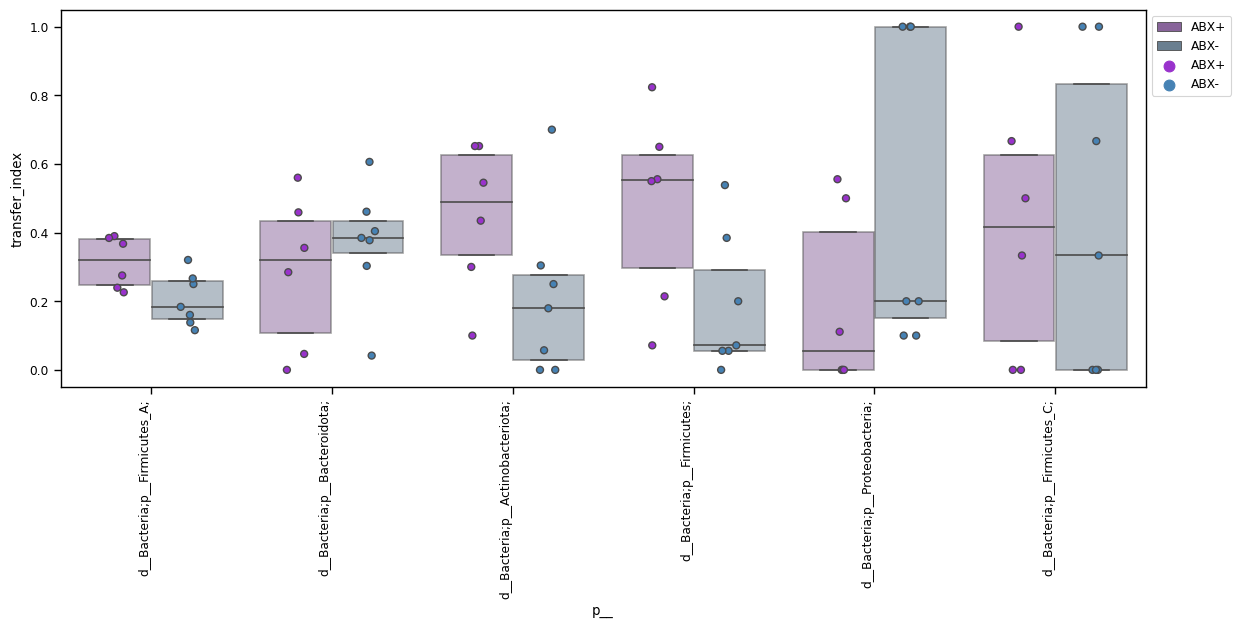

In [ ]:
taxon_level = "p__"
taxon_order = top_phylum_donor_median_abundance.index
comparison = "antibiotics_"
sample_type = "followup_1"

opportunities = (
    (subject_x_strain_transfer.notna()).groupby(sotu_to_taxonomy[taxon_level]).sum()
)
transfers = (subject_x_strain_transfer).groupby(sotu_to_taxonomy[taxon_level]).sum()
no_transfers = opportunities - transfers
d = (
    (transfers / opportunities)
    .unstack()
    .rename("transfer_index")
    .reset_index()
    .rename(columns={"level_1": "subject_id", "level_0": "sample_type"})
    .join(subject, on="subject_id")
    .sort_values(taxon_level)[lambda x: x.sample_type == sample_type]
)

fig, ax = plt.subplots(figsize=(14, 5))
lib.plot.boxplot_with_points(
    y="transfer_index",
    x=taxon_level,
    hue=comparison,
    palette=lib.project_style.DEFAULT_COLOR_PALETTE,
    order=taxon_order,
    data=d,
    ax=ax,
    dodge=True,
    dist_kwargs={"boxprops": {"alpha": 0.5}},
)
lib.plot.rotate_xticklabels(ax, rotation=90)
ax.legend(bbox_to_anchor=(1, 1))

print(
    d[lambda x: x[taxon_level].isin(taxon_order)]
    .groupby(taxon_level)
    .apply(
        lambda d: lib.stats.mannwhitneyu(
            comparison, "transfer_index", data=d, na_action="drop"
        )
    )
    .loc[taxon_order]
)

p__
d__Bacteria;p__Actinobacteriota;    0.132546
d__Bacteria;p__Bacteroidota;        0.445221
d__Bacteria;p__Firmicutes;          0.031653
d__Bacteria;p__Firmicutes_A;        0.051282
d__Bacteria;p__Firmicutes_C;        1.000000
d__Bacteria;p__Proteobacteria;      0.128250
dtype: float64

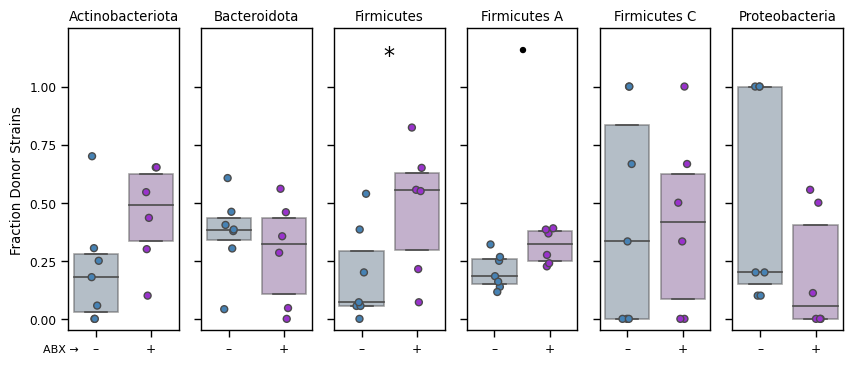

In [ ]:
def simplify_tax_string(s, prefix):
    return s.split(";")[-2].replace("_", " ")[len(prefix) :]


taxon_level = "p__"
taxon_order = sorted(top_phylum_donor_median_abundance.index)
comparison = "antibiotics_"
comparison_order = ["ABX-", "ABX+"]
sample_type = "followup_1"

opportunities = (
    (subject_x_strain_transfer.notna()).groupby(sotu_to_taxonomy[taxon_level]).sum()
)
transfers = (subject_x_strain_transfer).groupby(sotu_to_taxonomy[taxon_level]).sum()
no_transfers = opportunities - transfers
d0 = (
    (transfers / opportunities)
    .unstack()
    .rename("transfer_index")
    .reset_index()
    .rename(columns={"level_1": "subject_id", "level_0": "sample_type"})
    .join(subject, on="subject_id")
    .sort_values(taxon_level)[lambda x: x.sample_type == sample_type]
)

pvalues = (
    d0[lambda x: x[taxon_level].isin(taxon_order)]
    .groupby(taxon_level)
    .apply(
        lambda d: lib.stats.mannwhitneyu(
            comparison, "transfer_index", data=d, na_action="drop"
        )[1]
    )
    .loc[taxon_order]
)

fig, axs = plt.subplots(
    1,
    len(top_phylum_donor_median_abundance.index),
    figsize=(10, 4),
    sharex=True,
    sharey=True,
)

for tax, ax in zip(taxon_order, axs):
    d1 = d0[d0[taxon_level] == tax]
    lib.plot.boxplot_with_points(
        y="transfer_index",
        x=comparison,
        order=comparison_order,
        palette=lib.project_style.DEFAULT_COLOR_PALETTE,
        data=d1,
        ax=ax,
        dodge=True,
        dist_kwargs={"boxprops": {"alpha": 0.5}},
    )
    ax.set_title(simplify_tax_string(tax, taxon_level))
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.legend_.set_visible(False)
    annotation = lib.project_style.pvalue_to_annotation(pvalues[tax])
    if annotation == "∙":
        y = 1.161
    elif annotation == "**":
        y = 1.133
    elif annotation == "*":
        y = 1.133
    elif annotation == "":
        y = 1.133
    ax.annotate(annotation, xy=(0.5, y), fontsize=16, ha="center", va="center")
    ax.set_ylim(-0.05, 1.25)
    ax.set_xticklabels(["–", "+"])
    ax.set_yticks(np.linspace(0, 1, num=5))
#     lib.plot.rotate_xticklabels(ax, rotation=-45, ha='left')
# ax.legend(bbox_to_anchor=(1, 1))

axs[0].set_ylabel("Fraction Donor Strains")
ax.text(0.1, 0.072, "ABX →", fontsize=8, transform=fig.transFigure)


pvalues

In [ ]:
top_phylum_donor_median_abundance

p__
d__Bacteria;p__Firmicutes_A;        0.730048
d__Bacteria;p__Bacteroidota;        0.230452
d__Bacteria;p__Actinobacteriota;    0.038871
d__Bacteria;p__Firmicutes;          0.014149
d__Bacteria;p__Proteobacteria;      0.010157
d__Bacteria;p__Firmicutes_C;        0.008239
dtype: float64

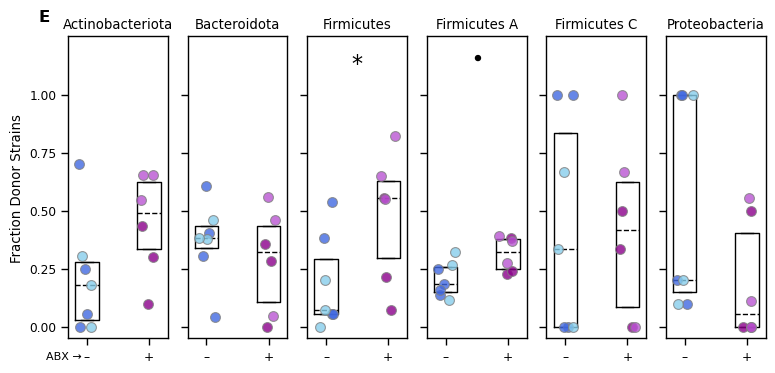

In [ ]:
def simplify_tax_string(s, prefix):
    return s.split(";")[-2].replace("_", " ")[len(prefix) :]


taxon_level = "p__"
taxon_order = sorted(top_phylum_donor_median_abundance.index)
comparison = "antibiotics_"
comparison_order = ["ABX-", "ABX+"]
sample_type = "followup_1"

opportunities = (
    (subject_x_strain_transfer.notna()).groupby(sotu_to_taxonomy[taxon_level]).sum()
)
transfers = (subject_x_strain_transfer).groupby(sotu_to_taxonomy[taxon_level]).sum()
no_transfers = opportunities - transfers
d0 = (
    (transfers / opportunities)
    .unstack()
    .rename("transfer_index")
    .reset_index()
    .rename(columns={"level_1": "subject_id", "level_0": "sample_type"})
    .join(subject, on="subject_id")
    .sort_values(taxon_level)[lambda x: x.sample_type == sample_type]
)
jitter_width = 0.15
d0["jitter"] = np.random.uniform(
    -jitter_width,
    jitter_width,
    size=d0.shape[0],
)
comparison_x = pd.Series(range(len(comparison_order)), index=comparison_order)

pvalues = (
    d0[lambda x: x[taxon_level].isin(taxon_order)]
    .groupby(taxon_level)
    .apply(
        lambda d: lib.stats.mannwhitneyu(
            comparison, "transfer_index", data=d, na_action="drop"
        )[1]
    )
    .loc[taxon_order]
)

fig, axs = plt.subplots(
    # fig, ax = plt.subplots(
    nrows=1,
    #     ncols=1,
    ncols=len(top_phylum_donor_median_abundance.index),
    figsize=(9, 4),
    sharex=True,
    sharey=True,
)

# tax = 'd__Bacteria;p__Firmicutes;'
for tax, ax in zip(taxon_order, axs):
    d1 = d0[d0[taxon_level] == tax]

    for antibiotics_, d2 in d1.groupby("antibiotics_"):
        for maintenance_, d3 in d2.groupby("maintenance_"):
            arm = antibiotics_ + "/" + maintenance_
            ax.scatter(
                d3.jitter + comparison_x[antibiotics_],
                d3.transfer_index,
                c=lib.project_style.DEFAULT_COLOR_PALETTE[arm],
                edgecolor="grey",
                #                 edgecolor='none',
                s=50,
                zorder=1,
                alpha=0.8,
            )
        ax.boxplot(
            d2.transfer_index,
            positions=[comparison_x[antibiotics_]],
            widths=jitter_width * 2.5,
            boxprops=dict(lw=1),
            medianprops=dict(lw=1, linestyle="--", color="k"),
            whis=0,
            showfliers=False,
            zorder=0,
        )
    ax.set_title(simplify_tax_string(tax, taxon_level))
    ax.set_ylabel("")
    ax.set_xlabel("")
    # ax.legend_.set_visible(False)
    annotation = lib.project_style.pvalue_to_annotation(pvalues[tax])
    if annotation == "∙":
        y = 1.161
    elif annotation == "**":
        y = 1.133
    elif annotation == "*":
        y = 1.133
    elif annotation == "":
        y = 1.133
    ax.annotate(annotation, xy=(0.5, y), fontsize=16, ha="center", va="center")
    ax.set_ylim(-0.05, 1.25)
    ax.set_xlim(-2 * jitter_width, 1 + 2 * jitter_width)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["–", "+"])
    ax.set_yticks(np.linspace(0, 1, num=5))

axs[0].set_ylabel("Fraction Donor Strains")
ax.text(0.1, 0.072, "ABX →", fontsize=8, transform=fig.transFigure)

axs[0].text(
    -0.3, 1.05, "E", fontsize=12, fontweight="heavy", transform=axs[0].transAxes
)

fig.savefig("fig/engraftment_rates_by_phylum.pdf", bbox_inches="tight")
# pvalues

p__
d__Bacteria;p__Firmicutes_A;         (0.7380952380952381, 0.18065268065268064)
d__Bacteria;p__Bacteroidota;         (0.2857142857142857, 0.23426573426573427)
d__Bacteria;p__Actinobacteriota;    (0.36904761904761907, 0.47383319059283024)
d__Bacteria;p__Firmicutes;           (0.39285714285714285, 0.5666413565522703)
d__Bacteria;p__Proteobacteria;                                      (0.5, 1.0)
d__Bacteria;p__Firmicutes_C;          (0.4642857142857143, 0.8821455812960055)
dtype: object


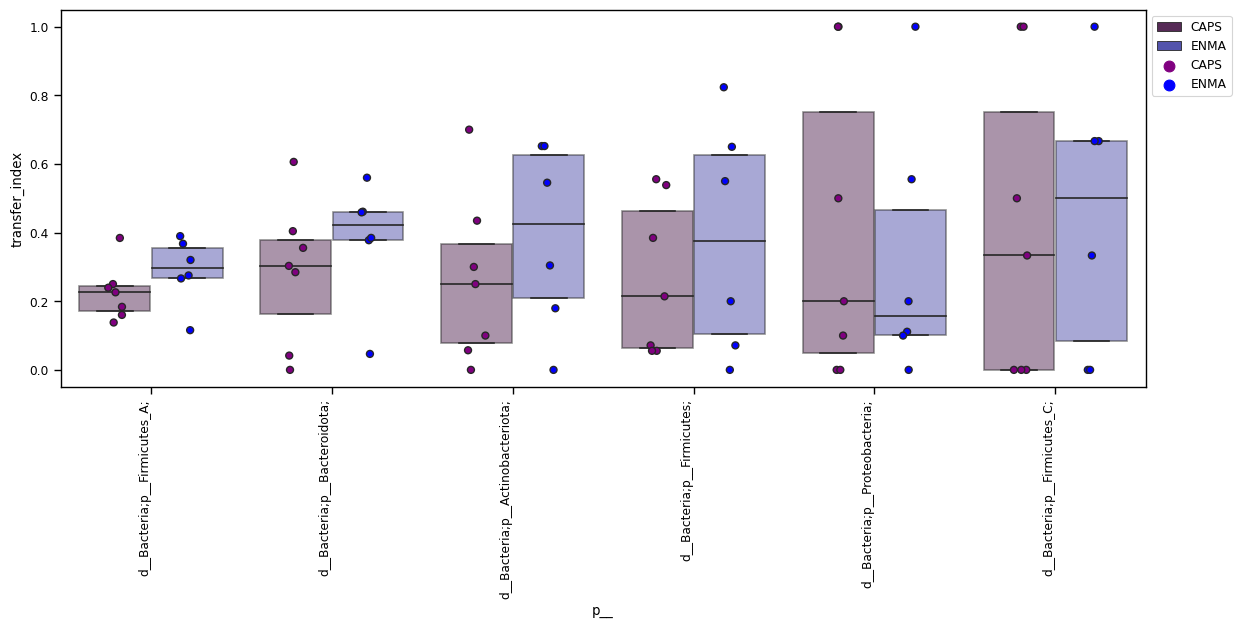

In [ ]:
taxon_level = "p__"
taxon_order = top_phylum_donor_median_abundance.index
comparison = "maintenance_"
sample_type = "followup_1"

opportunities = (
    (subject_x_strain_transfer.notna()).groupby(sotu_to_taxonomy[taxon_level]).sum()
)
transfers = (subject_x_strain_transfer).groupby(sotu_to_taxonomy[taxon_level]).sum()
no_transfers = opportunities - transfers
d = (
    (transfers / opportunities)
    .unstack()
    .rename("transfer_index")
    .reset_index()
    .rename(columns={"level_1": "subject_id", "level_0": "sample_type"})
    .join(subject, on="subject_id")
    .sort_values(taxon_level)[lambda x: x.sample_type == sample_type]
)

fig, ax = plt.subplots(figsize=(14, 5))
lib.plot.boxplot_with_points(
    y="transfer_index",
    x=taxon_level,
    hue=comparison,
    palette=lib.project_style.DEFAULT_COLOR_PALETTE,
    order=taxon_order,
    data=d,
    ax=ax,
    dodge=True,
    dist_kwargs={"boxprops": {"alpha": 0.5}},
)
lib.plot.rotate_xticklabels(ax, rotation=90)
ax.legend(bbox_to_anchor=(1, 1))

print(
    d[lambda x: x[taxon_level].isin(taxon_order)]
    .groupby(taxon_level)
    .apply(
        lambda d: lib.stats.mannwhitneyu(
            comparison, "transfer_index", data=d, na_action="drop"
        )
    )
    .loc[taxon_order]
)

p__
d__Bacteria;p__Firmicutes_A;         (0.8333333333333334, 0.08225108225108226)
d__Bacteria;p__Bacteroidota;         (0.7666666666666667, 0.17748917748917747)
d__Bacteria;p__Actinobacteriota;    (0.16666666666666666, 0.08213856110808998)
d__Bacteria;p__Firmicutes;           (0.7333333333333333, 0.23426713617079375)
d__Bacteria;p__Proteobacteria;       (0.8166666666666667, 0.09570475117488142)
d__Bacteria;p__Firmicutes_C;          (0.3333333333333333, 0.3970009440149582)
dtype: object


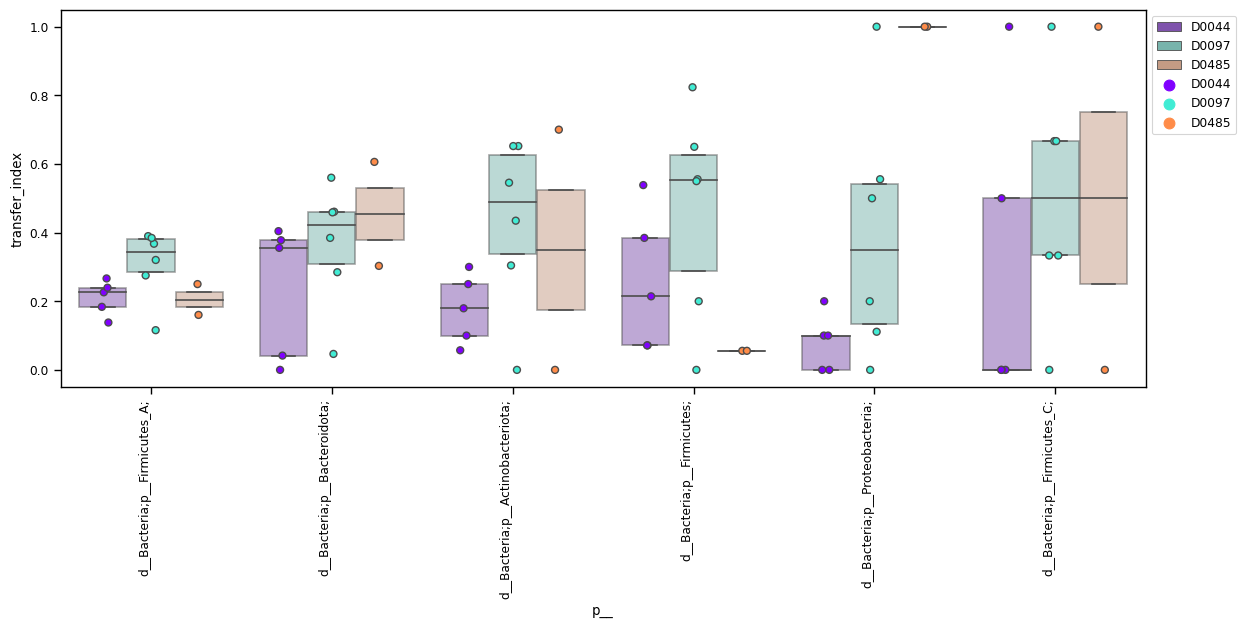

In [ ]:
taxon_level = "p__"
taxon_order = top_phylum_donor_median_abundance.index
comparison = "donor_subject_id"
sample_type = "followup_1"
pallete = subject_color_palette

opportunities = (
    (subject_x_strain_transfer.notna()).groupby(sotu_to_taxonomy[taxon_level]).sum()
)
transfers = (subject_x_strain_transfer).groupby(sotu_to_taxonomy[taxon_level]).sum()
no_transfers = opportunities - transfers
d = (
    (transfers / opportunities)
    .unstack()
    .rename("transfer_index")
    .reset_index()
    .rename(columns={"level_1": "subject_id", "level_0": "sample_type"})
    .join(subject, on="subject_id")
    .sort_values(taxon_level)[lambda x: x.sample_type == sample_type]
)

fig, ax = plt.subplots(figsize=(14, 5))
lib.plot.boxplot_with_points(
    y="transfer_index",
    x=taxon_level,
    hue=comparison,
    palette=pallete,
    order=taxon_order,
    data=d,
    ax=ax,
    dodge=True,
    dist_kwargs={"boxprops": {"alpha": 0.5}},
)
lib.plot.rotate_xticklabels(ax, rotation=90)
ax.legend(bbox_to_anchor=(1, 1))

print(
    d[lambda x: x[taxon_level].isin(taxon_order)]
    .groupby(taxon_level)
    .apply(
        lambda d: lib.stats.mannwhitneyu(
            comparison,
            "transfer_index",
            data=d[d.donor_subject_id.isin(["D0044", "D0097"])],
            na_action="drop",
        )
    )
    .loc[taxon_order]
)

p__
d__Bacteria;p__Firmicutes_A;         (0.6428571428571429, 0.4452214452214452)
d__Bacteria;p__Bacteroidota;        (0.7857142857142857, 0.10139860139860139)
d__Bacteria;p__Actinobacteriota;      (0.6785714285714286, 0.315977335831649)
d__Bacteria;p__Firmicutes;          (0.42857142857142855, 0.7202474654940236)
d__Bacteria;p__Proteobacteria;      (0.42857142857142855, 0.7172383586012208)
d__Bacteria;p__Firmicutes_C;         (0.42857142857142855, 0.710917113388619)
dtype: object


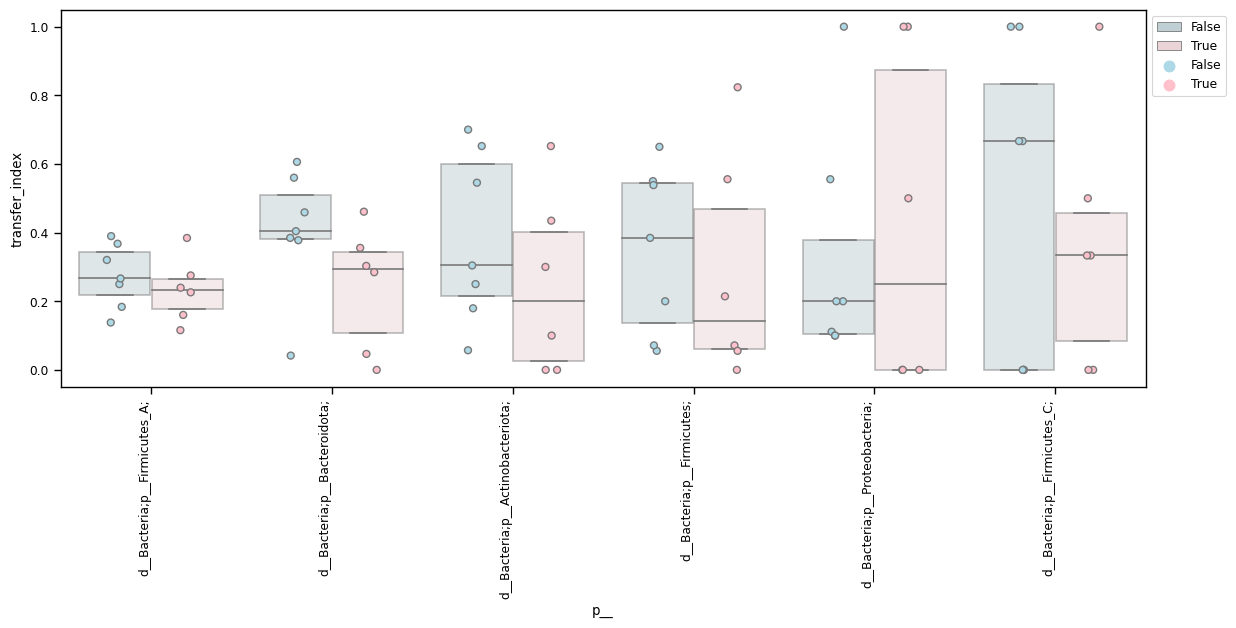

In [ ]:
taxon_level = "p__"
taxon_order = top_phylum_donor_median_abundance.index
comparison = "responder"
sample_type = "followup_1"

opportunities = (
    (subject_x_strain_transfer.notna()).groupby(sotu_to_taxonomy[taxon_level]).sum()
)
transfers = (subject_x_strain_transfer).groupby(sotu_to_taxonomy[taxon_level]).sum()
no_transfers = opportunities - transfers
d = (
    (transfers / opportunities)
    .unstack()
    .rename("transfer_index")
    .reset_index()
    .rename(columns={"level_1": "subject_id", "level_0": "sample_type"})
    .join(subject, on="subject_id")
    .sort_values(taxon_level)[lambda x: x.sample_type == sample_type]
)

fig, ax = plt.subplots(figsize=(14, 5))
lib.plot.boxplot_with_points(
    y="transfer_index",
    x=taxon_level,
    hue=comparison,
    palette=lib.project_style.DEFAULT_COLOR_PALETTE,
    order=taxon_order,
    data=d,
    ax=ax,
    dodge=True,
    dist_kwargs={"boxprops": {"alpha": 0.5}},
)
lib.plot.rotate_xticklabels(ax, rotation=90)
ax.legend(bbox_to_anchor=(1, 1))

print(
    d[lambda x: x[taxon_level].isin(taxon_order)]
    .groupby(taxon_level)
    .apply(
        lambda d: lib.stats.mannwhitneyu(
            comparison, "transfer_index", data=d, na_action="drop"
        )
    )
    .loc[taxon_order]
)

In [ ]:
top_family_donor_median_abundance = (
    sample_x_family.loc[["D0044_mean", "D0097_mean", "D0485_mean"]]
    .median()
    .sort_values(ascending=False)
    .head(10)
)
top_family_donor_median_abundance

f__
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;                0.320751
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;               0.210927
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;                 0.136459
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__DTU089;                        0.050016
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;              0.042416
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;                  0.031743
d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Bifidobacteriaceae;    0.030945
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;                 0.012909
d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;       0.010586
d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Corioba

f__
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;                 (0.8333333333333334, 0.05128205128205128)
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;                 (0.5714285714285714, 0.7307692307692307)
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;                  (0.42857142857142855, 0.7307692307692307)
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__DTU089;                          (0.4166666666666667, 0.6678058142504256)
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;                (0.6904761904761905, 0.2948717948717949)
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;                   (0.6666666666666666, 0.34910823732597074)
d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Bifidobacteriaceae;    (0.16666666666666666, 0.07934368319771502)
d__Bacteria;p__Bacteroidota;c_

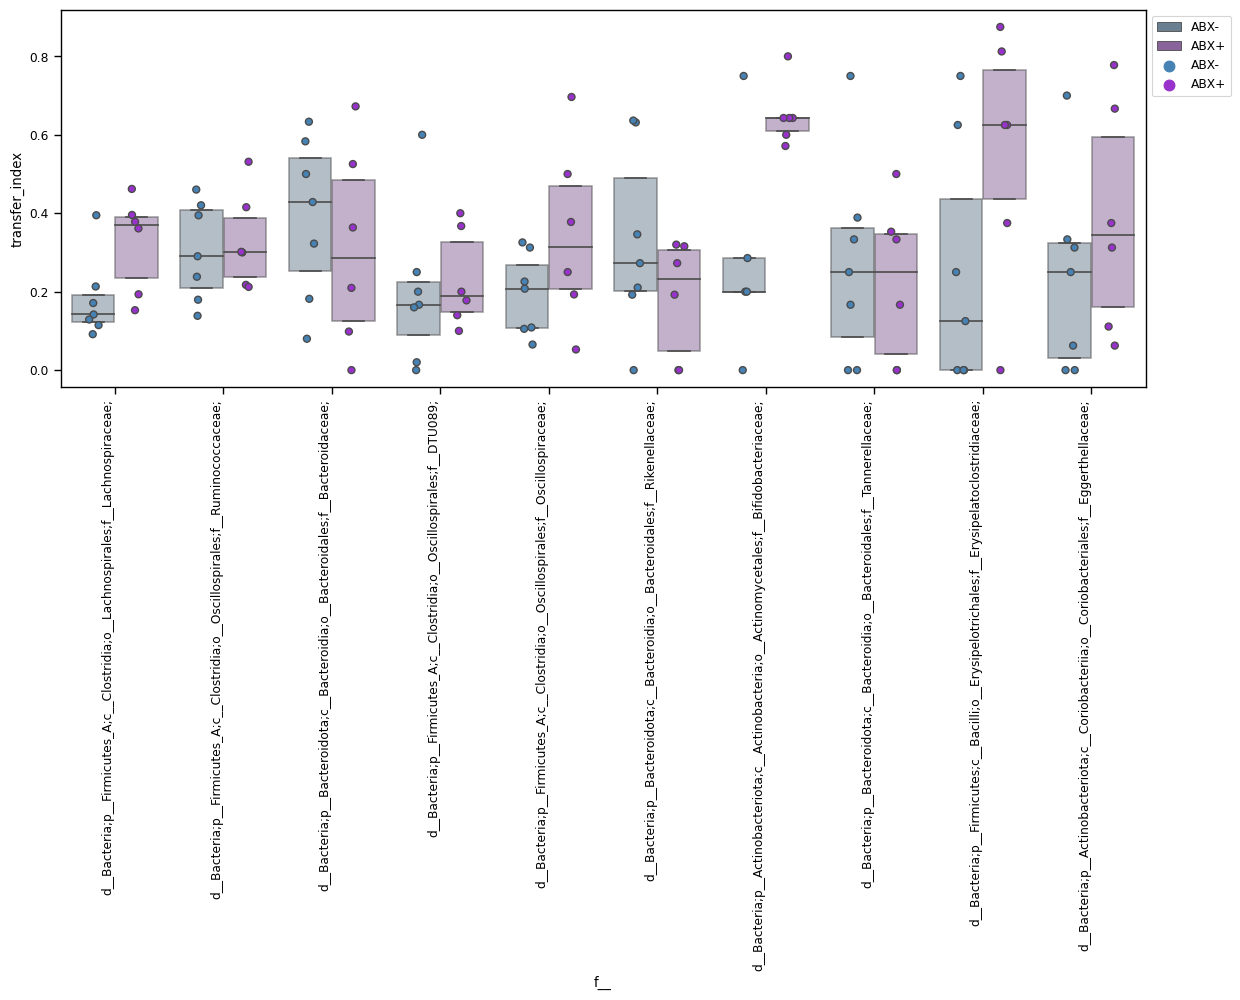

In [ ]:
taxon_level = "f__"
taxon_order = top_family_donor_median_abundance.index
comparison = "antibiotics_"
sample_type = "followup_1"

opportunities = (
    (subject_x_strain_transfer.notna()).groupby(sotu_to_taxonomy[taxon_level]).sum()
)
transfers = (subject_x_strain_transfer).groupby(sotu_to_taxonomy[taxon_level]).sum()
no_transfers = opportunities - transfers
d = (
    (transfers / opportunities)
    .unstack()
    .rename("transfer_index")
    .reset_index()
    .rename(columns={"level_1": "subject_id", "level_0": "sample_type"})
    .join(subject, on="subject_id")
    .sort_values(taxon_level)[lambda x: x.sample_type == sample_type]
)

fig, ax = plt.subplots(figsize=(14, 5))
lib.plot.boxplot_with_points(
    y="transfer_index",
    x=taxon_level,
    hue=comparison,
    palette=lib.project_style.DEFAULT_COLOR_PALETTE,
    order=taxon_order,
    data=d,
    ax=ax,
    dodge=True,
    dist_kwargs={"boxprops": {"alpha": 0.5}},
)
lib.plot.rotate_xticklabels(ax, rotation=90)
ax.legend(bbox_to_anchor=(1, 1))

print(
    d[lambda x: x[taxon_level].isin(taxon_order)]
    .groupby(taxon_level)
    .apply(
        lambda d: lib.stats.mannwhitneyu(
            comparison, "transfer_index", data=d, na_action="drop"
        )
    )
    .loc[taxon_order]
)

f__
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;                  (-0.0441883550641489, 0.10138021371948537)
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;               (-0.031729800624144135, 0.22525226946319699)
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;                  (0.017881524626337207, 0.46945960978174905)
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__DTU089;                        (-0.0010533809246115894, 0.9656863994849314)
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;                (0.013923939227668084, 0.5705670737737062)
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;                    (0.012388267746704304, 0.6133146780094056)
d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Bifidobacteriaceae;     (0.0012715098992452335, 0.9704275113421342)
d__Bacteria;p__B

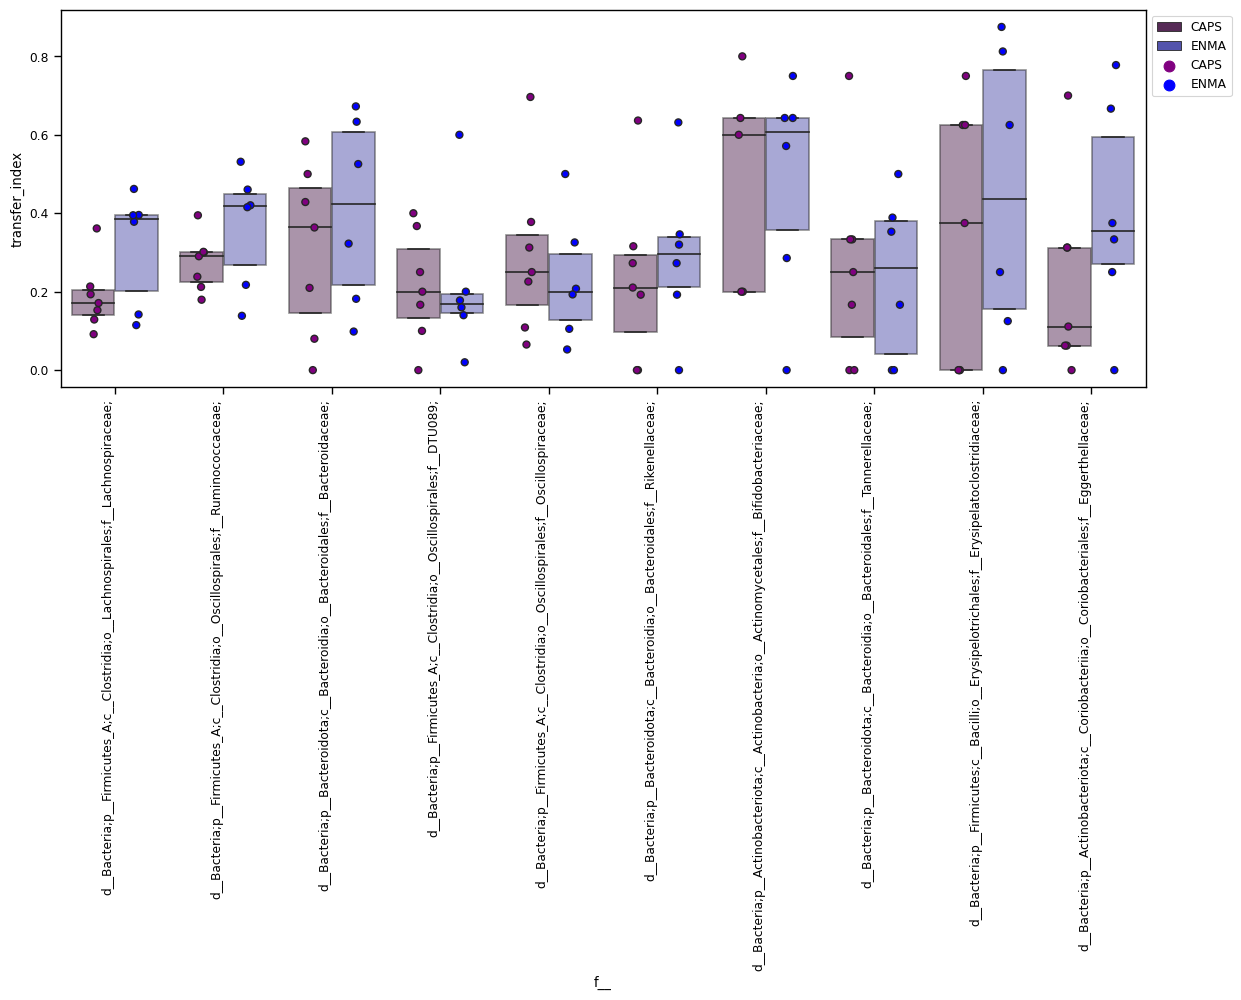

In [ ]:
taxon_level = "f__"
taxon_order = top_family_donor_median_abundance.index
comparison = "maintenance_"
sample_type = "followup_1"

opportunities = (
    (subject_x_strain_transfer.notna()).groupby(sotu_to_taxonomy[taxon_level]).sum()
)
transfers = (subject_x_strain_transfer).groupby(sotu_to_taxonomy[taxon_level]).sum()
no_transfers = opportunities - transfers
d = (
    (transfers / opportunities)
    .unstack()
    .rename("transfer_index")
    .reset_index()
    .rename(columns={"level_1": "subject_id", "level_0": "sample_type"})
    .join(subject, on="subject_id")
    .sort_values(taxon_level)[lambda x: x.sample_type == sample_type]
)

fig, ax = plt.subplots(figsize=(14, 5))
lib.plot.boxplot_with_points(
    y="transfer_index",
    x=taxon_level,
    hue=comparison,
    palette=lib.project_style.DEFAULT_COLOR_PALETTE,
    order=taxon_order,
    data=d,
    ax=ax,
    dodge=True,
    dist_kwargs={"boxprops": {"alpha": 0.5}},
)
lib.plot.rotate_xticklabels(ax, rotation=90)
ax.legend(bbox_to_anchor=(1, 1))

print(
    d[lambda x: x[taxon_level].isin(taxon_order)]
    .groupby(taxon_level)
    .apply(
        lambda d: lib.stats.ttest(
            comparison, "transfer_index", data=d, na_action="drop", equal_var=False
        )
    )
    .loc[taxon_order]
)

f__
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;                (-0.1275591623440232, 0.010191198120217623)
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;               (-0.002011356334610464, 0.9533788725422642)
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;                   (0.03951030159849838, 0.2674118772211199)
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__DTU089;                          (-0.02348700355352938, 0.510081599124989)
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;                (0.01875557505811198, 0.5892931811533324)
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;                  (-0.0028656487468788922, 0.934527887007324)
d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Bifidobacteriaceae;      (0.008960527611399104, 0.794650728972796)
d__Bacteria;p__Bacteroi

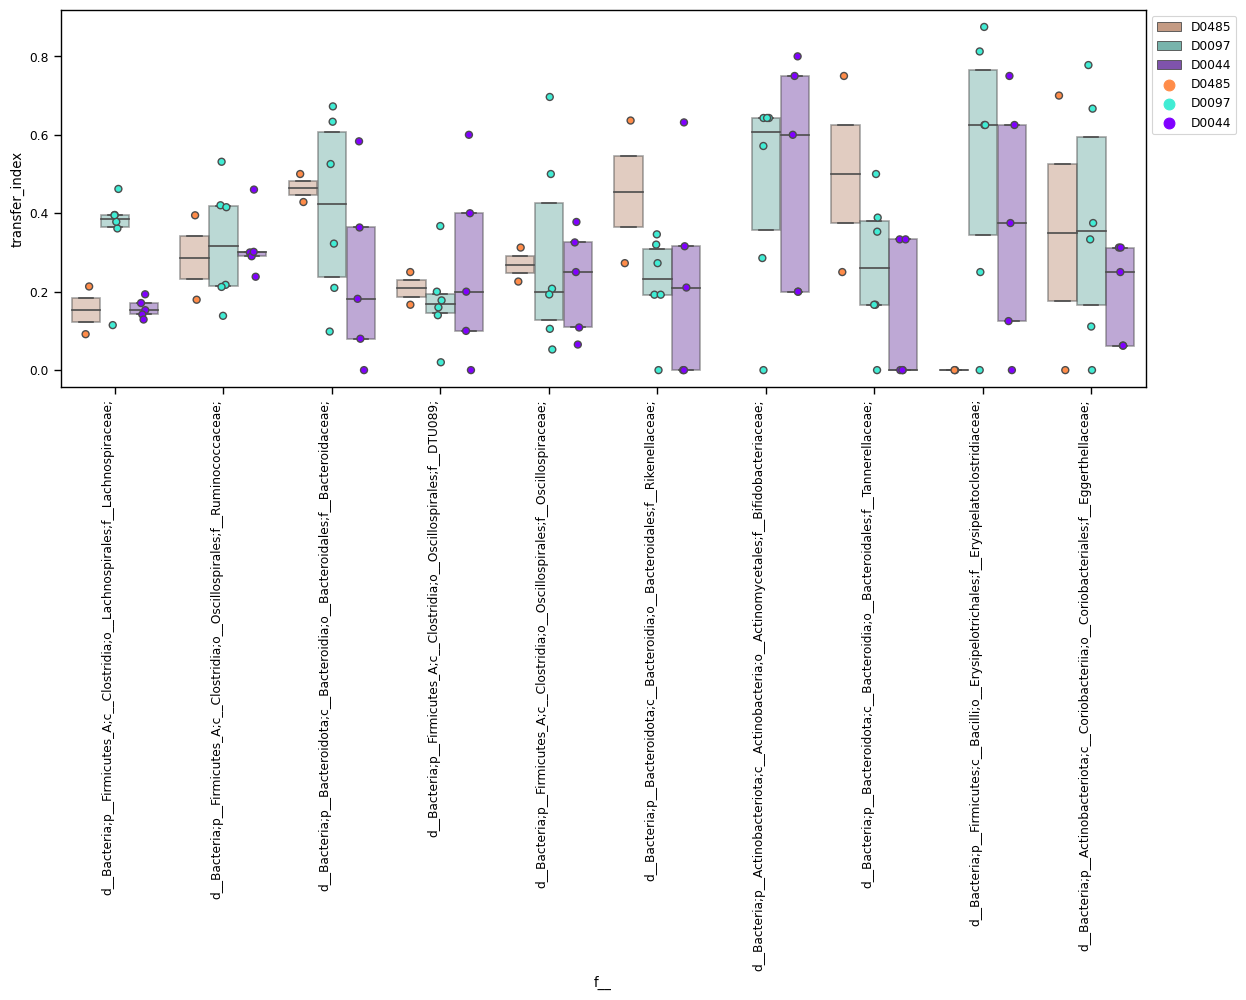

In [ ]:
taxon_level = "f__"
taxon_order = top_family_donor_median_abundance.index
comparison = "donor_subject_id"
sample_type = "followup_1"
palette = subject_color_palette

opportunities = (
    (subject_x_strain_transfer.notna()).groupby(sotu_to_taxonomy[taxon_level]).sum()
)
transfers = (subject_x_strain_transfer).groupby(sotu_to_taxonomy[taxon_level]).sum()
no_transfers = opportunities - transfers
d = (
    (transfers / opportunities)
    .unstack()
    .rename("transfer_index")
    .reset_index()
    .rename(columns={"level_1": "subject_id", "level_0": "sample_type"})
    .join(subject, on="subject_id")
    .sort_values(taxon_level)[lambda x: x.sample_type == sample_type]
)

fig, ax = plt.subplots(figsize=(14, 5))
lib.plot.boxplot_with_points(
    y="transfer_index",
    x=taxon_level,
    hue=comparison,
    palette=palette,
    order=taxon_order,
    data=d,
    ax=ax,
    dodge=True,
    dist_kwargs={"boxprops": {"alpha": 0.5}},
)
lib.plot.rotate_xticklabels(ax, rotation=90)
ax.legend(bbox_to_anchor=(1, 1))

print(
    d[lambda x: x[taxon_level].isin(taxon_order)]
    .groupby(taxon_level)
    .apply(
        lambda d: lib.stats.ttest(
            comparison,
            "transfer_index",
            data=d[d.donor_subject_id.isin(["D0044", "D0097"])],
            na_action="drop",
            equal_var=False,
        )
    )
    .loc[taxon_order]
)

f__
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;                (-0.018556263305716313, 0.45225212983551866)
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;               (-0.08682611970398871, 0.004214813531685746)
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;                   (-0.02276136172370172, 0.3606358960860395)
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__DTU089;                          (0.004253019537100326, 0.8614881852258324)
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;                (0.015879353205430376, 0.5217057200527233)
d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;                  (-0.029665783813836426, 0.24009195219157117)
d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Bifidobacteriaceae;     (-0.018695077529913593, 0.5911526052524638)
d__Bacteria;p__B

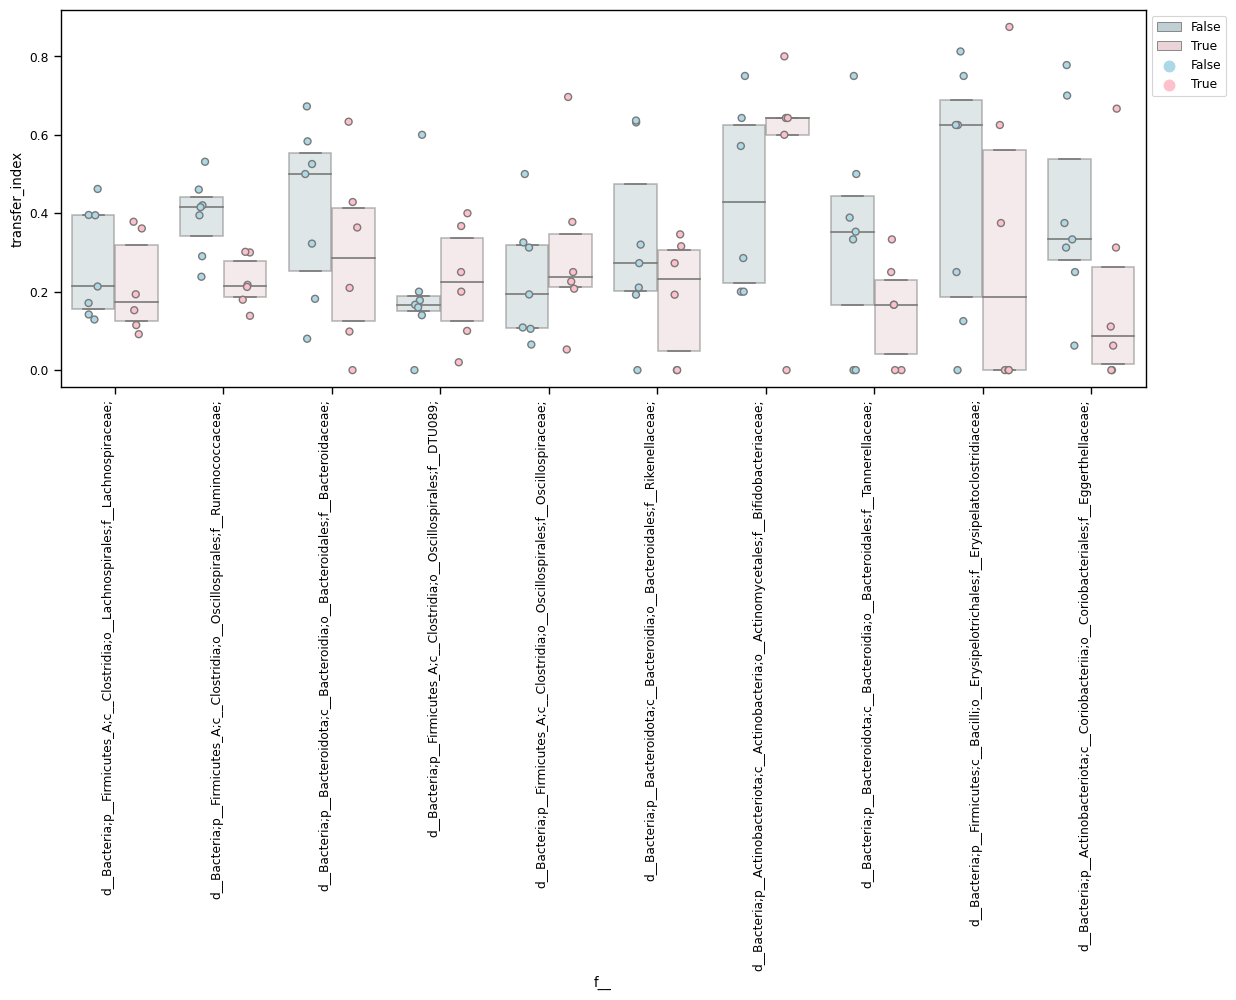

In [ ]:
taxon_level = "f__"
taxon_order = top_family_donor_median_abundance.index
comparison = "responder"
sample_type = "followup_1"

opportunities = (
    (subject_x_strain_transfer.notna()).groupby(sotu_to_taxonomy[taxon_level]).sum()
)
transfers = (subject_x_strain_transfer).groupby(sotu_to_taxonomy[taxon_level]).sum()
no_transfers = opportunities - transfers
d = (
    (transfers / opportunities)
    .unstack()
    .rename("transfer_index")
    .reset_index()
    .rename(columns={"level_1": "subject_id", "level_0": "sample_type"})
    .join(subject, on="subject_id")
    .sort_values(taxon_level)[lambda x: x.sample_type == sample_type]
)

fig, ax = plt.subplots(figsize=(14, 5))
lib.plot.boxplot_with_points(
    y="transfer_index",
    x=taxon_level,
    hue=comparison,
    palette=lib.project_style.DEFAULT_COLOR_PALETTE,
    order=taxon_order,
    data=d,
    ax=ax,
    dodge=True,
    dist_kwargs={"boxprops": {"alpha": 0.5}},
)
lib.plot.rotate_xticklabels(ax, rotation=90)
ax.legend(bbox_to_anchor=(1, 1))

print(
    d[lambda x: x[taxon_level].isin(taxon_order)]
    .groupby(taxon_level)
    .apply(
        lambda d: lib.stats.ttest(
            comparison, "transfer_index", data=d, na_action="drop", equal_var=False
        )
    )
    .loc[taxon_order]
)

## Subsection: Broad correlations between datasets

In [ ]:
import skbio as skb

m = (
    sample.join(subject, on="subject_id", lsuffix="_")
    .assign(subject_type=lambda x: x.recipient.map({True: "recipient", False: "donor"}))
    .assign(zorder=lambda x: x.recipient.map({True: 0, False: 1}))
)

d = sample_x_rotu_cvrg.rename(columns=lambda s: s.replace("_", " "))

tree = skb.io.read(
    "sraw/2020-12-30-Dose_Finding_Study_Box_mirror/16S data files/dada2_optim_tree_OTUtips_FMT_VED_May2019.tre",
    into=skb.TreeNode,
).root_at_midpoint()


motu_unifrac_dmat = skb.diversity.beta_diversity(
    "weighted_unifrac",
    counts=d,
    ids=d.index,
    otu_ids=d.columns,
    tree=tree,
    normalized=True,
).to_data_frame()

In [ ]:
# TODO: Only calculate for reasonable data subset

datasets = (
    ("subject", sample[["subject_id"]], lambda x, y: x != y),
    ("time", sample[["days_post_fmt"]], "cityblock"),
    ("rotu", sample_x_rotu, "braycurtis"),
    ("motu", sample_x_motu, "braycurtis"),
    ("motu_bact", sample_x_motu_bacteroidota, "braycurtis"),
    ("motu_firm_A", sample_x_motu_firmicutes_A, "braycurtis"),
    ("motu_firm", sample_x_motu_firmicutes, "braycurtis"),
    ("motu_firm_C", sample_x_motu_firmicutes_C, "braycurtis"),
    ("motu_actino", sample_x_motu_actinobacteria, "braycurtis"),
    ("motu_proteo", sample_x_motu_proteobacteria, "braycurtis"),
    ("sotu_bact", sample_x_sotu_bacteroidota, "braycurtis"),
    ("sotu_firm_A", sample_x_sotu_firmicutes_A, "braycurtis"),
    ("sotu_firm_C", sample_x_sotu_firmicutes_C, "braycurtis"),
    ("sotu_firm", sample_x_sotu_firmicutes, "braycurtis"),
    ("sotu_actino", sample_x_sotu_actinobacteria, "braycurtis"),
    ("sotu_proteo", sample_x_sotu_proteobacteria, "braycurtis"),
    ("sotu", sample_x_sotu, "braycurtis"),
    ("family", sample_x_family, "braycurtis"),
    ("family_bact", sample_x_family_bacteroidota, "braycurtis"),
    ("family_firm_A", sample_x_family_firmicutes_A, "braycurtis"),
    ("family_firm", sample_x_family_firmicutes, "braycurtis"),
    ("family_firm_C", sample_x_family_firmicutes_C, "braycurtis"),
    ("family_actino", sample_x_family_actinobacteria, "braycurtis"),
    ("family_proteo", sample_x_family_proteobacteria, "braycurtis"),
    #     ('eggnog', sample_x_eggnog_cvrg, 'cosine'),
    ("ko", sample_x_ko_cvrg, "cosine"),
    #     ('keggmodule', sample_x_keggmodule_cvrg, 'cosine'),
    #     ('chem', sample_x_chem_std2, 'cosine'),
    ("chem_ba", sample_x_chem_ba_std2, "cosine"),
)

dmatrices = {}
for dataset_name, _data, metric in tqdm(datasets, ascii=True):
    dmatrices[dataset_name] = dmatrix(_data, metric=metric)

dmatrices["sqrt_time"] = np.sqrt(dmatrices["time"])
dmatrices["log_time"] = np.log(dmatrices["time"])
dmatrices["cbrt_time"] = np.cbrt(dmatrices["time"])
dmatrices["rotu_unifrac"] = motu_unifrac_dmat

100%|########################################################################################################################| 26/26 [00:01<00:00, 19.24it/s]


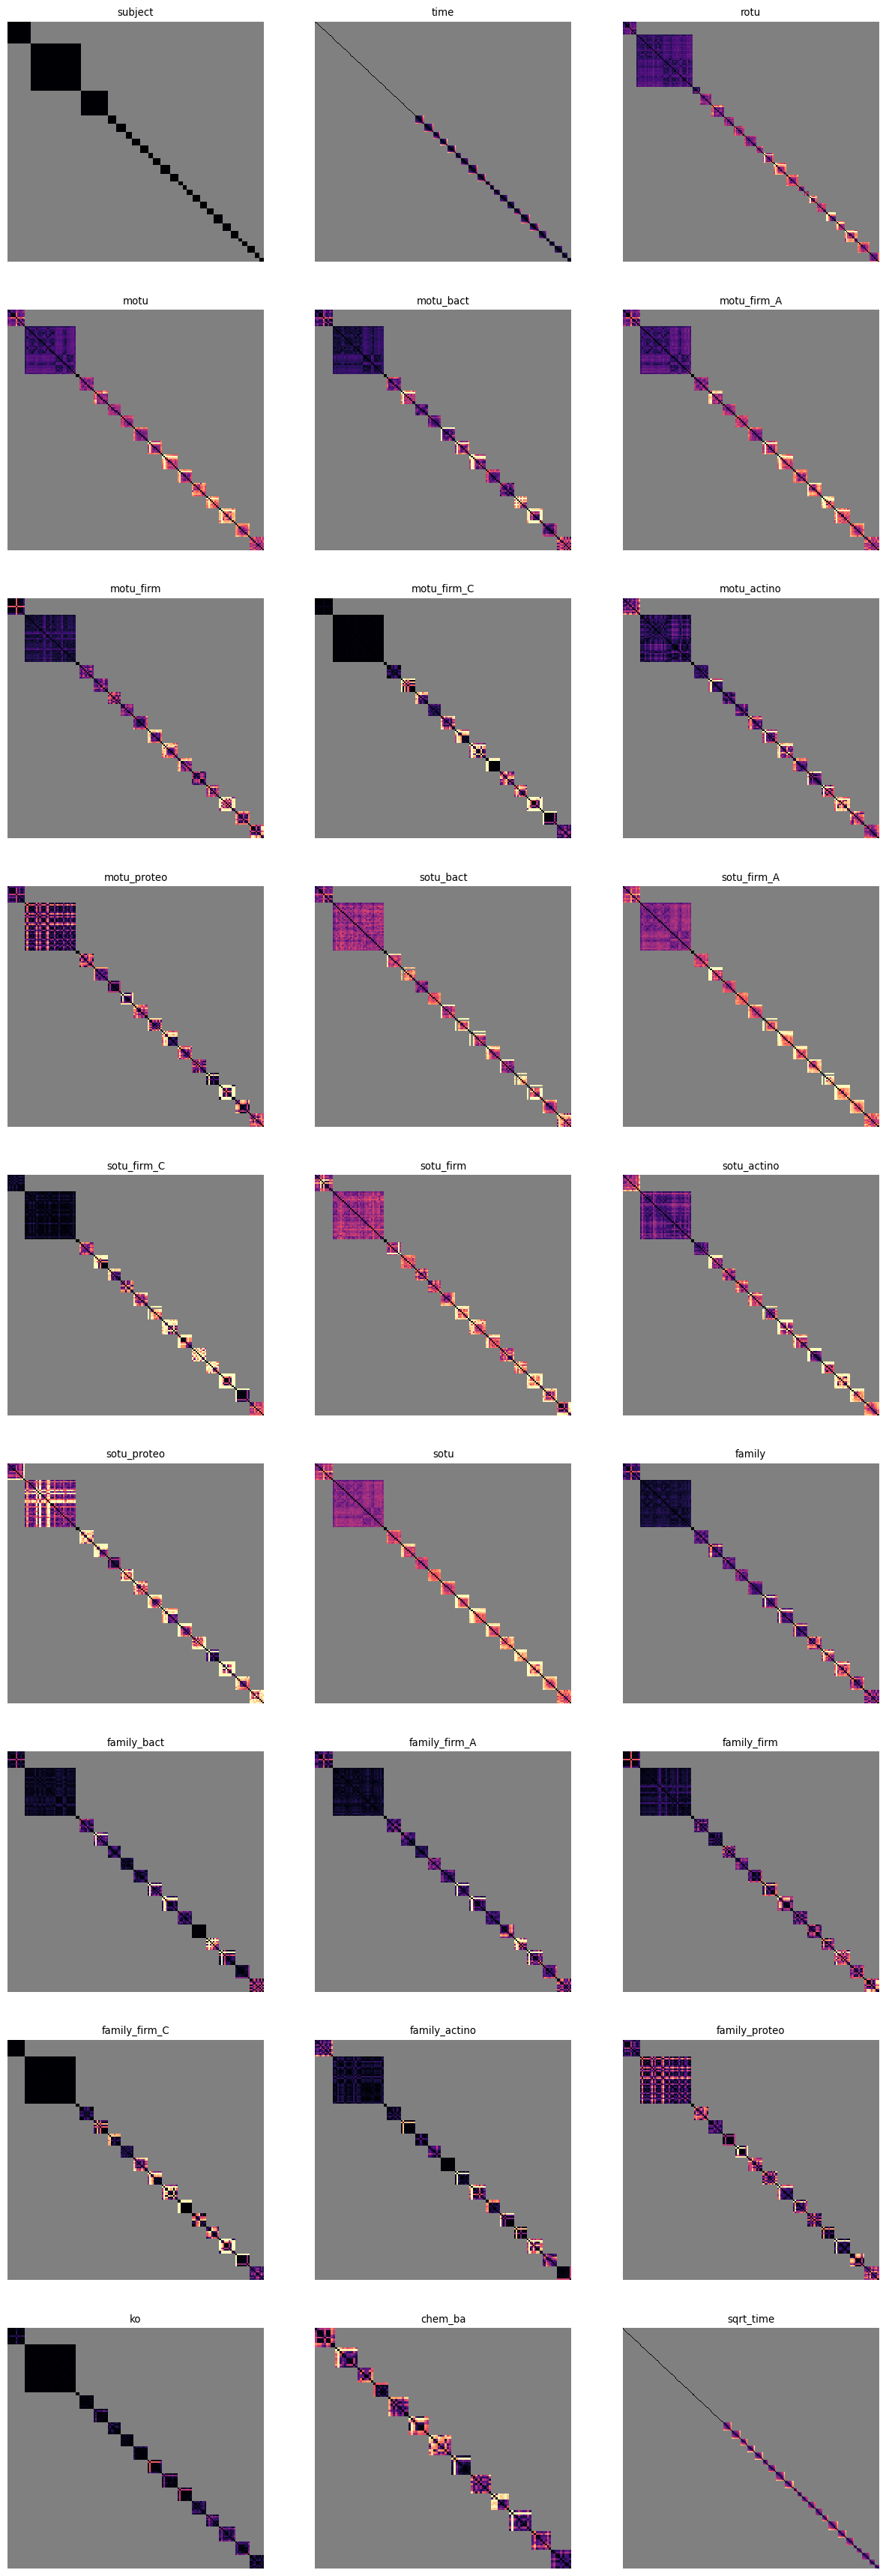

In [ ]:
nrows, ncols = 9, 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

for dataset_name, ax in zip(dmatrices, axs.flatten()):
    _time, _subject, _x = align_dmatrices(
        dmatrices["time"], dmatrices["subject"], dmatrices[dataset_name]
    )
    if dataset_name in ["time", "sqrt_time", "log_time", "cbrt_time"]:
        vmax = None
    else:
        vmax = 1
    sns.heatmap(
        data=_x,
        mask=_subject.astype(bool),
        cmap="magma",
        cbar=False,
        ax=ax,
        xticklabels=0,
        yticklabels=0,
        vmin=0,
        vmax=vmax,
    )
    ax.set_facecolor("grey")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title(dataset_name)

In [ ]:
drop = idxwhere(
    sample.sample_type.isin(
        [
            "post_antibiotic",
            "donor_mean",
            "donor_initial",
            "donor_capsule",
            "donor_enema",
        ]
    )
)

for xname, yname in [
    #     ('eggnog', 'time'),
    #     ('eggnog', 'sqrt_time'),
    #     ('eggnog', 'cbrt_time'),
    #     ('eggnog', 'log_time'),
    ("ko", "time"),
    ("ko", "sqrt_time"),
    ("ko", "cbrt_time"),
    ("ko", "log_time"),
    #     ('keggmodule', 'time'),
    #     ('keggmodule', 'sqrt_time'),
    #     ('keggmodule', 'cbrt_time'),
    #     ('keggmodule', 'log_time'),
    ("sotu", "time"),
    ("sotu", "sqrt_time"),
    ("sotu", "cbrt_time"),
    ("sotu", "log_time"),
    ("motu", "time"),
    ("motu", "sqrt_time"),
    ("motu", "cbrt_time"),
    ("motu", "log_time"),
    ("rotu", "time"),
    ("rotu", "sqrt_time"),
    ("rotu", "cbrt_time"),
    ("rotu", "log_time"),
    ("family", "time"),
    ("family", "sqrt_time"),
    ("family", "cbrt_time"),
    ("family", "log_time"),
    #     ('chem', 'time'),
    #     ('chem', 'sqrt_time'),
    #     ('chem', 'cbrt_time'),
    #     ('chem', 'log_time'),
    ("chem_ba", "time"),
    ("chem_ba", "sqrt_time"),
    ("chem_ba", "cbrt_time"),
    ("chem_ba", "log_time"),
]:
    t, m, x, y = align_dmatrices(
        dmatrices["time"],
        dmatrices["subject"],
        dmatrices[xname],
        dmatrices[yname],
        drop_labels=drop,
    )
    t, x, y = [mask_dmatrix(d, m.astype(bool)) for d in [t, x, y]]
    s = sample.subject_id.loc[m.index]
    print(
        xname, yname, *mantel_test(x, y, strata=s, permutations=999, method="pearson")
    )

ko time 0.155226166677554 0.014
ko sqrt_time 0.16638781039562173 0.01
ko cbrt_time 0.16822947860585036 0.008
ko log_time 0.16856134780441823 0.003
sotu time 0.2879527761385169 0.001
sotu sqrt_time 0.33262023377638555 0.001
sotu cbrt_time 0.34552316259172045 0.001
sotu log_time 0.3659097351434171 0.001
motu time 0.2435144357294096 0.001
motu sqrt_time 0.2772146281019003 0.001
motu cbrt_time 0.28690999480614593 0.001
motu log_time 0.3021864209875207 0.001
rotu time 0.2907227225790046 0.001
rotu sqrt_time 0.3297764016531522 0.001
rotu cbrt_time 0.3422005183094123 0.001
rotu log_time 0.36305251525228666 0.001
family time 0.1401223377703447 0.007
family sqrt_time 0.1614155811150649 0.004
family cbrt_time 0.16726683760358835 0.002
family log_time 0.17603195328981672 0.001
chem_ba time 0.1724687585393343 0.014
chem_ba sqrt_time 0.18262410454246497 0.009
chem_ba cbrt_time 0.1854607811941613 0.005
chem_ba log_time 0.18924717372039265 0.004


In [ ]:
drop = idxwhere(
    sample.sample_type.isin(
        [
            "post_antibiotic",
            "donor_mean",
            "donor_initial",
            "donor_capsule",
            "donor_enema",
        ]
    )
)

for xname, yname, zname in [
    #     ('eggnog', 'sotu', 'sqrt_time'),
    #     ('eggnog', 'motu', 'sqrt_time'),
    #     ('eggnog', 'rotu', 'sqrt_time'),
    #     ('eggnog', 'sotu', 'motu'),
    ("ko", "sotu", "sqrt_time"),
    ("ko", "motu", "sqrt_time"),
    ("ko", "rotu", "sqrt_time"),
    ("ko", "sotu", "motu"),
    #     ('chem', 'sotu', 'sqrt_time'),
    #     ('chem', 'motu', 'sqrt_time'),
    #     ('chem', 'rotu', 'sqrt_time'),
    #     ('chem', 'ko', 'sqrt_time'),
    ("chem_ba", "family", "sqrt_time"),
    ("chem_ba", "family_bact", "sqrt_time"),
    ("chem_ba", "family_firm", "sqrt_time"),
    ("chem_ba", "family_firm_A", "sqrt_time"),
    ("chem_ba", "family_firm_C", "sqrt_time"),
    ("chem_ba", "family_actino", "sqrt_time"),
    ("chem_ba", "family_proteo", "sqrt_time"),
    ("chem_ba", "motu", "sqrt_time"),
    ("chem_ba", "motu_bact", "sqrt_time"),
    ("chem_ba", "motu_firm", "sqrt_time"),
    ("chem_ba", "motu_firm_A", "sqrt_time"),
    ("chem_ba", "motu_firm_C", "sqrt_time"),
    ("chem_ba", "motu_actino", "sqrt_time"),
    ("chem_ba", "motu_proteo", "sqrt_time"),
    ("chem_ba", "sotu", "sqrt_time"),
    ("chem_ba", "sotu_bact", "sqrt_time"),
    ("chem_ba", "sotu_firm", "sqrt_time"),
    ("chem_ba", "sotu_firm_A", "sqrt_time"),
    ("chem_ba", "sotu_firm_C", "sqrt_time"),
    ("chem_ba", "sotu_actino", "sqrt_time"),
    ("chem_ba", "sotu_proteo", "sqrt_time"),
    ("chem_ba", "sotu", "motu"),
    ("chem_ba", "sotu", "rotu"),
    ("chem_ba", "sotu", "ko"),
    ("chem_ba", "sotu_firm", "motu_firm"),
    ("chem_ba", "sotu_firm_A", "motu_firm_A"),
    ("chem_ba", "sotu_firm_C", "motu_firm_C"),
    ("chem_ba", "sotu_actino", "motu_actino"),
    ("chem_ba", "sotu_bact", "motu_bact"),
    ("chem_ba", "ko", "sqrt_time"),
    ("chem_ba", "ko", "sqrt_time"),
    ("chem_ba", "rotu", "sqrt_time"),
    ("chem_ba", "family", "sqrt_time"),
    ("chem_ba", "rotu", "sotu"),
    ("chem_ba", "rotu", "motu"),
]:
    t, m, x, y, z = align_dmatrices(
        dmatrices["time"],
        dmatrices["subject"],
        dmatrices[xname],
        dmatrices[yname],
        dmatrices[zname],
        drop_labels=drop,
    )
    t, x, y, z = [mask_dmatrix(d, m.astype(bool)) for d in [t, x, y, z]]
    s = sample.subject_id.loc[m.index]
    print(
        xname,
        yname,
        zname,
        *partial_mantel_test(x, y, z, strata=s, permutations=999, method="pearson"),
    )

ko sotu sqrt_time 0.5619669102291576 0.001
ko motu sqrt_time 0.7249648496501688 0.001
ko rotu sqrt_time 0.4442590436857634 0.001
ko sotu motu -0.2614348321514883 1.0
chem_ba family sqrt_time 0.18013627426520712 0.001
chem_ba family_bact sqrt_time 0.1888176989126553 0.017
chem_ba family_firm sqrt_time -0.02641651888241617 0.329
chem_ba family_firm_A sqrt_time 0.1389311528491224 0.013
chem_ba family_firm_C sqrt_time 0.2238514921124214 0.003
chem_ba family_actino sqrt_time -0.020544766890465666 0.097
chem_ba family_proteo sqrt_time 0.006999701695863209 0.186
chem_ba motu sqrt_time 0.29086684050610595 0.001
chem_ba motu_bact sqrt_time 0.27539810127829073 0.001
chem_ba motu_firm sqrt_time -0.03670518579333471 0.527
chem_ba motu_firm_A sqrt_time 0.33109330136627024 0.001
chem_ba motu_firm_C sqrt_time 0.25753300752918545 0.001
chem_ba motu_actino sqrt_time 0.07463254572004246 0.045
chem_ba motu_proteo sqrt_time 0.014428652391759892 0.025
chem_ba sotu sqrt_time 0.27929820262502847 0.001
chem_b

In [ ]:
drop = idxwhere(
    sample.sample_type.isin(
        [
            "post_antibiotic",
            "donor_mean",
            "donor_initial",
            "donor_capsule",
            "donor_enema",
        ]
    )
)

for xname, yname in [
    #     ('eggnog', 'sqrt_time'),
    #     ('eggnog', 'sotu'),
    #     ('eggnog', 'motu'),
    #     ('eggnog', 'rotu'),
    #     ('eggnog', 'family'),
    ("ko", "sqrt_time"),
    ("ko", "sotu"),
    ("ko", "motu"),
    ("ko", "rotu"),
    ("ko", "family"),
    ("ko", "sqrt_time"),
    ("ko", "sotu"),
    ("ko", "motu"),
    ("ko", "rotu"),
    ("ko", "family"),
    #     ('chem', 'sqrt_time'),
    #     ('chem', 'sotu'),
    #     ('chem', 'motu'),
    #     ('chem', 'rotu'),
    #     ('chem', 'family'),
    #     ('chem', 'eggnog'),
    #     ('chem', 'ko'),
    ("chem_ba", "sqrt_time"),
    ("chem_ba", "family"),
    ("chem_ba", "family_bact"),
    ("chem_ba", "family_firm"),
    ("chem_ba", "family_firm_A"),
    ("chem_ba", "family_firm_C"),
    ("chem_ba", "family_actino"),
    ("chem_ba", "family_proteo"),
    #     ('chem_ba', 'eggnog'),
    ("chem_ba", "ko"),
    ("chem_ba", "motu"),
    ("chem_ba", "motu_bact"),
    ("chem_ba", "motu_firm"),
    ("chem_ba", "motu_firm_A"),
    ("chem_ba", "motu_firm_C"),
    ("chem_ba", "motu_actino"),
    ("chem_ba", "motu_proteo"),
    ("chem_ba", "sotu"),
    ("chem_ba", "sotu_bact"),
    ("chem_ba", "sotu_firm"),
    ("chem_ba", "sotu_firm_A"),
    ("chem_ba", "sotu_firm_C"),
    ("chem_ba", "sotu_actino"),
    ("chem_ba", "sotu_proteo"),
]:
    t, m, x, y = align_dmatrices(
        dmatrices["time"],
        dmatrices["subject"],
        dmatrices[xname],
        dmatrices[yname],
        drop_labels=drop,
    )
    t, x, y = [mask_dmatrix(d, m.astype(bool)) for d in [t, x, y]]
    s = sample.subject_id.loc[m.index]
    print(
        xname, yname, *mantel_test(x, y, strata=s, permutations=999, method="spearman")
    )

ko sqrt_time 0.1743185030096906 0.003
ko sotu 0.6397464423950604 0.001
ko motu 0.7917612516527884 0.001
ko rotu 0.5631032806962835 0.001
ko family 0.8585165326549447 0.001
ko sqrt_time 0.1743185030096906 0.004
ko sotu 0.6397464423950604 0.001
ko motu 0.7917612516527884 0.001
ko rotu 0.5631032806962835 0.001
ko family 0.8585165326549447 0.001
chem_ba sqrt_time 0.18718179613569222 0.001
chem_ba family 0.24262043299202782 0.001
chem_ba family_bact 0.11932004171423047 0.011
chem_ba family_firm 0.035323043790380475 0.099
chem_ba family_firm_A 0.153923565194393 0.001
chem_ba family_firm_C 0.21736158701811834 0.01
chem_ba family_actino -0.020338346825213818 0.144
chem_ba family_proteo 0.0483247199318189 0.046
chem_ba ko 0.19704367703177544 0.001
chem_ba motu 0.3293988740695961 0.001
chem_ba motu_bact 0.26629136813467413 0.001
chem_ba motu_firm 0.04131107051338199 0.143
chem_ba motu_firm_A 0.3202539010843692 0.001
chem_ba motu_firm_C 0.26893146446697586 0.004
chem_ba motu_actino 0.119318396493

In [ ]:
from itertools import combinations

drop = idxwhere(
    sample.sample_type.isin(
        [
            "post_antibiotic",
            "donor_mean",
            "donor_initial",
            "donor_capsule",
            "donor_enema",
        ]
    )
)


dmats_to_compare = [
    "rotu",
    "family",
    "rotu_unifrac",
    "motu",  #'motu_bact', 'motu_firm', 'motu_actino', 'motu_proteo',
    "sotu",  #'sotu_bact', 'sotu_firm', 'sotu_actino', 'sotu_proteo',
    #     'eggnog',
    "ko",
    #     'keggmodule',
    #     'chem',
    "chem_ba",
]

mantel_results = []
mantel_partial_results = []
for xname, yname in tqdm(list(combinations(dmats_to_compare, r=2)), ascii=True):
    zname = "sqrt_time"

    t, m, x, y, z = align_dmatrices(
        dmatrices["time"],
        dmatrices["subject"],
        dmatrices[xname],
        dmatrices[yname],
        dmatrices[zname],
        drop_labels=drop,
    )
    t, x, y, z = [mask_dmatrix(d, m.astype(bool)) for d in [t, x, y, z]]
    s = sample.subject_id.loc[m.index]
    mantel_partial_results.append(
        (
            xname,
            yname,
            *partial_mantel_test(x, y, z, strata=s, permutations=999, method="pearson"),
        )
    )
    mantel_results.append(
        (xname, yname, *mantel_test(x, y, strata=s, permutations=999, method="pearson"))
    )

mantel_partial_results = pd.DataFrame(
    mantel_partial_results, columns=["X", "Y", "r", "p"]
).set_index(["X", "Y"])
mantel_results = pd.DataFrame(mantel_results, columns=["X", "Y", "r", "p"]).set_index(
    ["X", "Y"]
)

mantel_partial_r_matrix = (
    mantel_partial_results["r"]
    .unstack()
    .reindex(index=dmats_to_compare, columns=dmats_to_compare)
)
mantel_partial_p_matrix = (
    mantel_partial_results["p"]
    .unstack()
    .reindex(index=dmats_to_compare, columns=dmats_to_compare)
)

mantel_r_matrix = (
    mantel_results["r"]
    .unstack()
    .reindex(index=dmats_to_compare, columns=dmats_to_compare)
)
mantel_p_matrix = (
    mantel_results["p"]
    .unstack()
    .reindex(index=dmats_to_compare, columns=dmats_to_compare)
)

100%|########################################################################################################################| 21/21 [00:24<00:00,  1.15s/it]


<AxesSubplot:xlabel='Y', ylabel='X'>

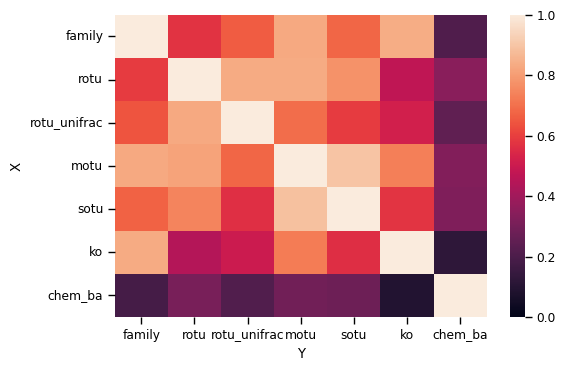

In [ ]:
# dist = squareform(1 - d)
# linkage = scipy.cluster.hierarchy.linkage(y=dist, method='single', optimal_ordering=True)
order = [
    #     'motu_proteo', 'sotu_proteo',
    #     'motu_actino', 'sotu_actino',
    #     'motu_bact', 'sotu_bact',
    #     'motu_firm', 'sotu_firm',
    #    'rotu',
    "family",
    "rotu",
    "rotu_unifrac",
    "motu",
    "sotu",
    #     'eggnog',
    "ko",
    #     'keggmodule',
    #     'chem',
    "chem_ba",
]

d = mantel_r_matrix.fillna(mantel_partial_r_matrix.T).fillna(1)
p = mantel_p_matrix.fillna(mantel_partial_p_matrix.T)

d = d.loc[order, order]
p = p.loc[order, order]

sns.heatmap(
    d,
    annot=p.applymap(lambda x: {True: "ø", False: ""}[x > 0.05]),
    fmt="",
    vmin=0,
    vmax=1,
)

In [ ]:
from itertools import combinations, product


def make_xy_coord_tables(d):
    return (
        pd.DataFrame(
            np.asarray([range(d.shape[1]) for _ in range(d.shape[0])]),
            index=d.index,
            columns=d.columns,
        ),
        pd.DataFrame(
            np.asarray([range(d.shape[0]) for _ in range(d.shape[1])]).T,
            index=d.index,
            columns=d.columns,
        ),
    )

In [ ]:
drop = idxwhere(
    sample.sample_type.isin(
        [
            "post_antibiotic",
            "donor_mean",
            "donor_initial",
            "donor_capsule",
            "donor_enema",
        ]
    )
)

xlist = ["ko", "chem_ba"]
ylist = ["ko", "family", "motu", "sotu", "rotu"]
mantel_results_overall = []
for xname, yname in tqdm(list(product(xlist, ylist)), ascii=True):
    zname = "sqrt_time"
    t, m, x, y, z = align_dmatrices(
        dmatrices["time"],
        dmatrices["subject"],
        dmatrices[xname],
        dmatrices[yname],
        dmatrices[zname],
        drop_labels=drop,
    )
    t, x, y, z = [mask_dmatrix(d, m.astype(bool)) for d in [t, x, y, z]]
    s = sample.subject_id.loc[m.index]
    mantel_results_overall.append(
        (
            xname,
            yname,
            *partial_mantel_test(
                x, y, z, strata=s, permutations=9999, method="pearson"
            ),
        )
    )

mantel_results_overall = pd.DataFrame(
    mantel_results_overall, columns=["xname", "yname", "r", "p"]
).set_index(["xname", "yname"])
mantel_results_overall_r = mantel_results_overall["r"].unstack().loc[xlist, ylist]
mantel_results_overall_p = mantel_results_overall["p"].unstack().loc[xlist, ylist]

100%|########################################################################################################################| 10/10 [00:45<00:00,  4.58s/it]


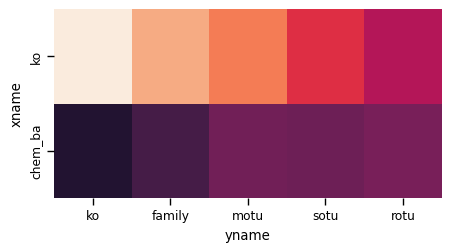

In [ ]:
rr = mantel_results_overall_r
pp = mantel_results_overall_p
xx, yy = make_xy_coord_tables(rr)

fig, ax = plt.subplots(figsize=(5, 2.5))
plot = sns.heatmap(
    rr,
    fmt="",
    vmin=0,
    vmax=1,
    ax=ax,
    cbar=False,
)


for _, (p, x, y) in pd.DataFrame(
    dict(p=pp.unstack(), x=xx.unstack(), y=yy.unstack())
).iterrows():
    if p > 0.05:
        ax.add_patch(
            mpl.patches.Rectangle(
                (x, y), 1, 1, hatch="//", edgecolor="lightgrey", linewidth=0, fill=False
            )
        )

/Users/byronsmith/anaconda3/envs/ucfmt2/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


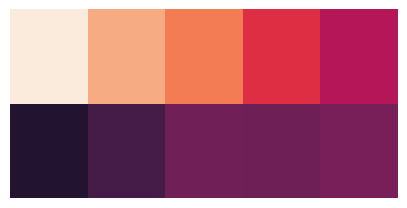

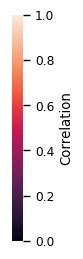

In [ ]:
rr = mantel_results_overall_r
pp = mantel_results_overall_p
xx, yy = make_xy_coord_tables(rr)

fig, ax = plt.subplots(figsize=(5, 2.5))
plot = sns.heatmap(
    rr,
    fmt="",
    vmin=0,
    vmax=1,
    ax=ax,
    cbar=False,
)

for _, (p, x, y) in pd.DataFrame(
    dict(p=pp.unstack(), x=xx.unstack(), y=yy.unstack())
).iterrows():
    if p > 0.05:
        ax.add_patch(
            mpl.patches.Rectangle(
                (x, y), 1, 1, hatch="//", edgecolor="lightgrey", linewidth=0, fill=False
            )
        )

# Remove chrome
ax.set_xticks([])
ax.set_xlabel(None)
ax.set_yticks([])
ax.set_ylabel(None)

fig.savefig("fig/mantel_multiomics_heatmap_nolabels.pdf", bbox_inches="tight")

# Color-bar
fig, ax = plt.subplots(figsize=(0.5, 3))
sns.heatmap(
    [[]],
    vmin=0,
    vmax=1,
    ax=ax,
    cbar=True,
    cbar_kws={"fraction": 1.0, "label": "Correlation"},
)
for spines in ["top", "right", "bottom", "left"]:
    ax.spines[spines].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig("fig/heatmap_colorbar.pdf", bbox_inches="tight")

In [ ]:
print(mantel_results_overall_r)
print(mantel_results_overall_p)

yname          ko    family      motu      sotu      rotu
xname                                                    
ko       1.000000  0.832267  0.724965  0.561967  0.444259
chem_ba  0.090629  0.180136  0.290867  0.279298  0.305723
yname        ko  family    motu    sotu    rotu
xname                                          
ko       0.0001  0.0001  0.0001  0.0001  0.0001
chem_ba  0.0416  0.0001  0.0001  0.0001  0.0001


In [ ]:
from itertools import combinations, product

drop = idxwhere(
    sample.sample_type.isin(
        [
            "post_antibiotic",
            "donor_mean",
            "donor_initial",
            "donor_capsule",
            "donor_enema",
        ]
    )
)

mantel_results_split = []
for tax_level, fraction in tqdm(
    list(
        product(
            ["family", "motu", "sotu"],
            ["", "_bact", "_firm", "_firm_A", "_firm_C", "_actino", "_proteo"],
        )
    ),
    ascii=True,
):
    zname = "sqrt_time"
    xname = "chem_ba"
    yname = tax_level + fraction
    t, m, x, y, z = align_dmatrices(
        dmatrices["time"],
        dmatrices["subject"],
        dmatrices[xname],
        dmatrices[yname],
        dmatrices[zname],
        drop_labels=drop,
    )
    t, x, y, z = [mask_dmatrix(d, m.astype(bool)) for d in [t, x, y, z]]
    s = sample.subject_id.loc[m.index]
    mantel_results_split.append(
        (
            tax_level,
            fraction,
            *partial_mantel_test(
                x, y, z, strata=s, permutations=9999, method="pearson"
            ),
        )
    )

mantel_results_split = pd.DataFrame(
    mantel_results_split, columns=["tax_level", "fraction", "r", "p"]
).set_index(["fraction", "tax_level"])
mantel_results_split_r = mantel_results_split["r"].unstack()
mantel_results_split_p = mantel_results_split["p"].unstack()

100%|########################################################################################################################| 21/21 [01:55<00:00,  5.50s/it]


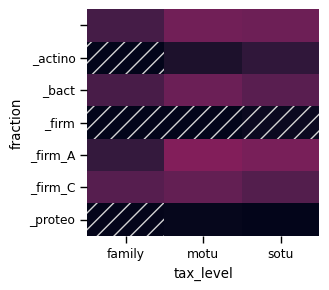

In [ ]:
rr = mantel_results_split_r
pp = mantel_results_split_p
xx, yy = make_xy_coord_tables(rr)

fig, ax = plt.subplots(figsize=(3, 3))
plot = sns.heatmap(
    rr,
    #     annot=pp.applymap(lambda x: {True: '.', False: ''}[x > 0.05]),
    fmt="",
    vmin=0,
    vmax=1,
    ax=ax,
    cbar=False,
)


for _, (p, x, y) in pd.DataFrame(
    dict(p=pp.unstack(), x=xx.unstack(), y=yy.unstack())
).iterrows():
    if p > 0.05:
        ax.add_patch(
            mpl.patches.Rectangle(
                (x, y), 1, 1, hatch="//", edgecolor="lightgrey", linewidth=0, fill=False
            )
        )

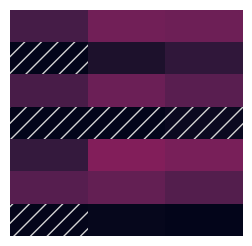

In [ ]:
rr = mantel_results_split_r
pp = mantel_results_split_p
xx, yy = make_xy_coord_tables(rr)

fig, ax = plt.subplots(figsize=(3, 3))
plot = sns.heatmap(
    rr,
    #     annot=pp.applymap(lambda x: {True: '.', False: ''}[x > 0.05]),
    fmt="",
    vmin=0,
    vmax=1,
    ax=ax,
    cbar=False,
)
# Remove chrome
ax.set_xticks([])
ax.set_xlabel(None)
ax.set_yticks([])
ax.set_ylabel(None)

for _, (p, x, y) in pd.DataFrame(
    dict(p=pp.unstack(), x=xx.unstack(), y=yy.unstack())
).iterrows():
    if p > 0.05:
        ax.add_patch(
            mpl.patches.Rectangle(
                (x, y), 1, 1, hatch="//", edgecolor="lightgrey", linewidth=0, fill=False
            )
        )

fig.savefig("fig/mantel_taxonomic_bileacids_heatmap_nolabels.pdf", bbox_inches="tight")

In [ ]:
print(mantel_results_split_r)
print("----------")
print(mantel_results_split_p)

tax_level    family      motu      sotu
fraction                               
           0.180136  0.290867  0.279298
_actino   -0.020545  0.074633  0.125841
_bact      0.188818  0.275398  0.232349
_firm     -0.026417 -0.036705  0.030897
_firm_A    0.138931  0.331093  0.308327
_firm_C    0.223851  0.257533  0.215158
_proteo    0.007000  0.014429 -0.029248
----------
tax_level  family    motu    sotu
fraction                         
           0.0001  0.0001  0.0001
_actino    0.1129  0.0468  0.0101
_bact      0.0105  0.0001  0.0004
_firm      0.3061  0.5353  0.3249
_firm_A    0.0154  0.0001  0.0002
_firm_C    0.0047  0.0024  0.0022
_proteo    0.1903  0.0270  0.0035
